# Проект молочного хозяйства "Вольный луг"

Настоящий проект разработан для молочного хозяйства «Вольный луг» (далее - Заказчик), которое заключило выгодный контракт с ассоциацией пастбищ «ЭкоФерма» (далее - ЭкоФерма) для расширения поголовья стада коров. Условия контракта позволяют Заказчику очень тщательно проводить отбор коров. Заказчик выставляет следующие требования к выбору коровы - удой с коровы не менее 6000 килограммов молока в год, а также требования к вкусу молока - строго по критериям Заказчика. Заказчик определяет вкус молока по собственной строгой методике. 

Заказчик предоставил данные о текущем поголовье Заказчика, а также данные о коровах ЭкоФермы для оценки перед покупкой. Необходимо обеспечить Заказчика инструментом управления рисками и оказания помощи в принятии решения о покупке коров.

Информация о породах коров не содержит сведения о параметрах корма, а характеристики молока указаны на момент продажи, когда ЭкоФерма давала коровам свой корм. Технологи Заказчика пересмотрели подход к кормлению новых коров и планируют увеличить все параметры корма на 5%.

**Цель проекта**: С помощью машинного обучения отобрать коров для принятия Заказчиком решения о покупке в соответствии со следующими критериями:
1. Средний удой за год — не менее 6000 килограммов;
2. Молоко должно быть вкусным по личным критериям Заказчика.

**Задачи проекта**: 
1. Разработать модель машинного обучения прогнозирования возможного годового удоя коровы;
2. Разработать модель машинного обучения для рассчета вероятности получить вкусное молоко;
3. Произвести отбор коров по критериям Заказчика.

In [1]:
# Установка библиотек
!pip install phik -q

# Импорт необходимых библиотек и функций
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
from typing import Union, Optional
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
    accuracy_score, confusion_matrix, recall_score, precision_score

# Определение константы RANDOM_STATE
RANDOM_STATE = 42

## Загрузка данных

In [2]:
ferma_main = pd.read_csv("https://code.s3.yandex.net/datasets/ferma_main.csv", 
                         delimiter=";", decimal=",")
display(ferma_main.sample(5))
ferma_main.info()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
574,575,6156,14.6,1955,0.94,РефлешнСоверинг,Холмистое,Соверин,3.73,3.077,вкусно,более_2_лет
461,462,6288,15.9,2020,0.93,РефлешнСоверинг,Холмистое,Соверин,3.71,3.072,не вкусно,более_2_лет
229,230,5877,12.5,1926,0.89,Вис Бик Айдиал,Холмистое,Айдиал,3.27,3.078,вкусно,более_2_лет
237,238,5884,14.6,1761,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.62,3.076,вкусно,более_2_лет
251,252,5846,14.3,1756,0.88,РефлешнСоверинг,Равнинное,Соверин,3.63,3.072,не вкусно,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Для удобства дальнейшей работы переименуем столбцы:

In [3]:
# Удои хотел назвать словом yield, но оказалось это ключевое слово, заменил его на milk_prod
ferma_main.columns = ["id", "milk_prod", "food_energy", "food_protein", "food_sugar_protein", 
                      "breed", "landscape", "dad_breed", "milk_fat", "milk_protein", "milk_taste", "age"]
ferma_main.columns

Index(['id', 'milk_prod', 'food_energy', 'food_protein', 'food_sugar_protein',
       'breed', 'landscape', 'dad_breed', 'milk_fat', 'milk_protein',
       'milk_taste', 'age'],
      dtype='object')

Файл `ferma_main.csv` содержит данные о стаде Заказчика на текущий момент. Столбцы были переименованы следующим образом:
- `id` — уникальный идентификатор коровы.
- `milk_prod` — продуктивность, удой в килограммах (масса молока, которую корова даёт в год).
- `food_energy` — ЭКЕ (Энергетическая кормовая единица), показатель питательности корма коровы.
- `food_protein` — содержание сырого протеина в корме (в граммах).
- `food_sugar_protein` — СПО (Сахаро-протеиновое соотношение), отношение сахара к протеину в корме коровы.
- `breed` — порода коровы.
- `landscape` — тип пастбища (ландшафт лугов, на которых паслась корова).
- `dad_breed` — порода папы коровы.
- `milk_fat` — содержание жиров в молоке (в процентах).
- `milk_protein` — содержание белков в молоке (в процентах).
- `milk_taste` — оценка вкуса по личным критериям Заказчика, бинарный признак (вкусно, не вкусно).
- `age` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [4]:
ferma_dad = pd.read_csv("https://code.s3.yandex.net/datasets/ferma_dad.csv", delimiter=";")
display(ferma_dad.sample(5))
ferma_dad.info()

,id,Имя Папы
436,437,Буйный
27,28,Буйный
266,267,Буйный
168,169,Буйный
235,236,Барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Также переименуем столбцы:

In [5]:
ferma_dad.columns = ["id", "dad_name"]
ferma_dad.columns

Index(['id', 'dad_name'], dtype='object')

Файл `ferma_dad.csv` хранит имя отца каждой коровы в стаде Заказчика. Переименованы столбцы:
- `id` — уникальный идентификатор коровы.
- `dad_name` — имя отца коровы.

In [6]:
cow_buy = pd.read_csv("https://code.s3.yandex.net/datasets/cow_buy.csv", 
                      delimiter=";", decimal=",")
display(cow_buy.sample(5))
cow_buy.info()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.34,3.069,более_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Переименуем столбцы:

In [7]:
cow_buy.columns = ["breed", "landscape", "dad_breed", "dad_name", "current_milk_fat", "current_milk_protein", "age"]
cow_buy.columns

Index(['breed', 'landscape', 'dad_breed', 'dad_name', 'current_milk_fat',
       'current_milk_protein', 'age'],
      dtype='object')

Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
- `breed` — порода коровы.
- `landscape` — тип пастбища (ландшафт лугов, на которых паслась корова.)
- `dad_breed` — порода папы коровы.
- `dad_name` — имя папы коровы.
- `current_milk_fat` — содержание жиров в молоке (в процентах).
- `current_milk_protein` — содержание белков в молоке (в процентах).
- `age` — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Отсутствуют параметры корма для коров «ЭкоФермы». Технологи Заказчика пересмотрели подход к кормлению - для новых коров планируется увеличить значения каждого из этих параметров на 5%.

### Промежуточные итоги

Получены следующие исходные выборки:
1. Данные о стаде Заказчика `main_ferma` - 634 записи, пропуски отсутствуют;
2. Данные об отцах коров Заказчика `ferma_dad` - 629 записей, пропуски отсутствуют, однако записей меньше чем коров в стаде;
3. Данные о коровах «ЭкоФермы» для анализа в целях покупки `cow_buy` - 20 записей, пропуски отсустствуют. Можно отметить отсутствие параметров корма в данных о коровах «ЭкоФермы». Технологи Заказчика планируют увеличить параметры корма для новых коров на 5%.

Были переименованы столбцы в таблицах - `breed` (порода), `age` (возраст коровы), `landscape` (пастбище), `food_energy` (ЭКЕ - Энергетическая кормовая единица), `food_protein` (содержание сырого протеина в корме), `food_sugar_protein` (СПО - Сахаро-протеиновое соотношение), `milk_fat` (содержание жиров в молоке), `milk_protein` (содержание белков в молоке), `milk_taste` (оценка вкуса), `milk_prod` (удой), `dad_breed` (порода папы коровы).

##  Предобработка данных

### Данные Заказчика

In [8]:
ferma_main[ferma_main.duplicated(keep=False)]

,id,milk_prod,food_energy,food_protein,food_sugar_protein,breed,landscape,dad_breed,milk_fat,milk_protein,milk_taste,age
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


В исходных данных о стаде Заказчика имеются явные дубликаты, корова с ID 627 повторяется еще 5 раз в самом конце таблицы. Вероятнее всего имеет место человеческая ошибка, либо ошибки при выгрузке данных. Избавимся от дубликатов.

In [9]:
ferma_main = ferma_main.drop_duplicates()
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  629 non-null    int64  
 1   milk_prod           629 non-null    int64  
 2   food_energy         629 non-null    float64
 3   food_protein        629 non-null    int64  
 4   food_sugar_protein  629 non-null    float64
 5   breed               629 non-null    object 
 6   landscape           629 non-null    object 
 7   dad_breed           629 non-null    object 
 8   milk_fat            629 non-null    float64
 9   milk_protein        629 non-null    float64
 10  milk_taste          629 non-null    object 
 11  age                 629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


После исключения дубликатов количество записей о стаде и записей об отцах коров выровнялись по количеству. Отдельно оценивать выборку по отцам коров не имеет смысла, нужно добавить сведения об отцах в основную таблицу по стаду.

In [10]:
ferma_main = ferma_main.merge(ferma_dad, on="id")
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  629 non-null    int64  
 1   milk_prod           629 non-null    int64  
 2   food_energy         629 non-null    float64
 3   food_protein        629 non-null    int64  
 4   food_sugar_protein  629 non-null    float64
 5   breed               629 non-null    object 
 6   landscape           629 non-null    object 
 7   dad_breed           629 non-null    object 
 8   milk_fat            629 non-null    float64
 9   milk_protein        629 non-null    float64
 10  milk_taste          629 non-null    object 
 11  age                 629 non-null    object 
 12  dad_name            629 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.8+ KB


После объединения двух таблиц отсутствуют пропущенные значения, соответственно в двух выборках было одинаковое количество коров.

Проверим числовые значения:

In [11]:
ferma_main.drop(columns="id").describe([0.0012, 0.01, .5, .99, .9988]).T.style.format("{:,.2f}")

,count,mean,std,min,0.1%,1%,50%,99%,99.9%,max
milk_prod,629.00,"6,188.75","1,644.80","5,204.00","5,206.26","5,254.84","6,133.00","7,164.04","16,682.28","45,616.00"
food_energy,629.00,14.54,1.31,10.90,11.05,11.80,14.70,16.70,16.80,16.80
food_protein,629.00,"1,923.36",182.96,"1,660.00","1,660.75","1,664.00","1,888.00","2,337.44","2,346.74","2,349.00"
food_sugar_protein,629.00,0.91,0.03,0.84,0.84,0.84,0.93,0.95,0.96,0.96
milk_fat,629.00,3.60,0.17,2.99,2.99,3.11,3.65,3.74,3.74,3.75
milk_protein,629.00,3.08,0.00,3.07,3.07,3.07,3.08,3.08,3.08,3.08


В целом по данным не видно сильных отклонений и выбросов, кроме показателей удоя. Основная масса коров по удою находится в пределах 5-7 тысяч килограммов в год, однако имеются значения более 45 тысяч килограммов. Очень высоким считаются удои порядка 15-17 тысяч килограммов в год, а мировые рекордсмены даже близко не приближались к 40 тысячам. Взглянем на ТОП5 коров Заказчика по удоям.

In [12]:
display(ferma_main["milk_prod"].sort_values(ascending=False).head(5))
ferma_main.query("milk_prod == 45616")

16     45616
70      7222
135     7207
296     7201
294     7197
Name: milk_prod, dtype: int64

,id,milk_prod,food_energy,food_protein,food_sugar_protein,breed,landscape,dad_breed,milk_fat,milk_protein,milk_taste,age,dad_name
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиалл,3.22,3.076,вкусно,более_2_лет,Буйный


Исключим явный выброс по значению молочной продуктивности в размере 45'616 килограмм в год. Вероятно это опечатка при вводе даных, однако исправить мы ее не можем, так как нет точного представления в какой части была допущена опечатка - в начале или в конце, а может и в середине значения. Нужно сообщить Заказчику о выявлении такого выброса, тем более молоко определено как вкусное.

In [13]:
ferma_main = ferma_main.query("milk_prod != 45616")
print(f"Количество оставшихся записей: {len(ferma_main)}")

Количество оставшихся записей: 628


Оценим уникальные значения категориальных полей.

In [14]:
for col in ["breed", "landscape", "milk_taste", "age", "dad_breed", "dad_name"]:
    print(f"Уникальные значения {col}: {ferma_main[col].unique()}")

Уникальные значения breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения landscape: ['Равнинное' 'Равнинные' 'Холмистое']
Уникальные значения milk_taste: ['вкусно' 'не вкусно']
Уникальные значения age: ['более_2_лет' 'менее_2_лет']
Уникальные значения dad_breed: ['Айдиал' 'Соверин' 'Айдиалл']
Уникальные значения dad_name: ['Буйный' 'Соловчик' 'Барин' 'Геркулес']


Имеются неявные дубликаты в значении пастбища - Равнинное и Равнинные, а также в значении породы отца - Айдиал и Айдиалл, остальные значения не дублируются. 

В части породы коров можно отметить, что в стаде Заказчика имеется только одна порода: самая распространенная порода молочного скота в мире - голштинская, в качестве породы в выборке представлены две генетические линии голштинской породы - Вис Бэк Айдиал и Рефлекшн Соверинг. Генетическая линия коровы скорее всего устанавливается по материнской линии, при этом в выборке учитывается влияние отцовской линии быка производителя. Cудя по производительности коров, можно сказать, что изначально использовались не чистокровные представители породы, а вероятнее всего черно-пестрая порода, на маточном поголовье которой производилось дальнейшее селекционирование с применением быков производителей голштинской породы. Хотя на молочную продуктивность здесь могут вносить свои коррективы внешние факторы (географическая зона может быть причиной более низких удоев по сравнению с мировыми) и условия содержания.

Отцовская линия сокращена по названию до "Соверинг" и "Айдиал", но в целом это одни и та же линии голштинской породы. Несмотря на то, что это одна и та же порода, различия между названиями пород для коровы и быков производителей не повлияют на дальнейший анализ. 

Исправим дублирующиеся значения:

In [15]:
ferma_main["landscape"] = ferma_main["landscape"].apply(lambda x: x if x != 'Равнинные' else 'Равнинное')
ferma_main["dad_breed"] = ferma_main["dad_breed"].apply(lambda x: x if x != 'Айдиалл' else 'Айдиал')
print(f"Уникальные значения пастбищ: {ferma_main.landscape.unique()}")
print(f"Уникальные значения породы отца: {ferma_main.dad_breed.unique()}")

Уникальные значения пастбищ: ['Равнинное' 'Холмистое']
Уникальные значения породы отца: ['Айдиал' 'Соверин']


Проверим наличие неявных дубликатов по всем полям, кроме id.

In [16]:
print(
    "Неявных дубликатов:",
    ferma_main.drop(columns="id").duplicated().sum()
)    

Неявных дубликатов: 0


### Данные ЭкоФермы:

In [17]:
display(cow_buy.describe().T.style.format("{:.2f}"))
for col in ["breed", "landscape", "age", "dad_breed", "dad_name"]:
    print(f"Уникальные значения {col}: {cow_buy[col].unique()}")

,count,mean,std,min,25%,50%,75%,max
current_milk_fat,20.00,3.58,0.13,3.34,3.51,3.59,3.65,3.77
current_milk_protein,20.00,3.07,0.01,3.05,3.06,3.07,3.08,3.08


Уникальные значения breed: ['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения landscape: ['холмистое' 'равнинное']
Уникальные значения age: ['более_2_лет' 'менее_2_лет']
Уникальные значения dad_breed: ['Айдиал' 'Соверин']
Уникальные значения dad_name: ['Геркулес' 'Буйный' 'Барин' 'Соловчик']


По данным ЭкоФермы породы аналогичные, явные выбросы по значениям отсутствуют. Жирность молока ЭкоФермы в среднем чуть меньше, хотя минимальные и максимальные значения выше, чем в стаде Заказчика. Содержание протеина в среднем чуть ниже.

Можно отметить, что наименования пастбища отличаются от таковых в выборке по стаду Заказчика, где они начинаются с заглавной буквы. Лучше приведем к одному виду для дальнейшего выделения категорий.

Оценим дубликаты:

In [18]:
cow_buy["landscape"] = cow_buy["landscape"].str.title()
print(f"Уникальные значения landscape: {cow_buy.landscape.unique()}")
print(f"\nЯвных дубликатов: {cow_buy.duplicated().sum()}")
cow_buy[cow_buy.duplicated()]

Уникальные значения landscape: ['Холмистое' 'Равнинное']

Явных дубликатов: 4


,breed,landscape,dad_breed,dad_name,current_milk_fat,current_milk_protein,age
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Имеются 4 явных дубликата, однако параметров в даннной выборке очень мало и отсутствуют уникальные идентификаторы коров, так что вероятней всего это разные коровы с очень близкими характеристиками молока. Риск случайно добавить дублирующиеся значения в список из 20 коров достаточно низкий, однако стоит даный факт также отметить для Заказчика.

### Промежуточные итоги

Проведена предобработка данных, по результатам которой можно отметить следующее:
1. По данным Заказчика:
    - имеются 5 дубликатов коровы ID 637 в конце таблицы. Дубликаты исключены из выборки;
    - обнаружен выброс значения (строка 17) равное 45616 килограмм за год. Запись исключена из выборки;
    - исправлены неявные дубликаты значения параметра типа пастбища.
2. По данным ЭкоФермы:
    - приведены к единым значения по параметру типа пастбища с выборкой Заказчика;
    - найдены 4 дубликата, которые вероятнее всего таковыми не являются, так как сравниваемых параметров выборки очень мало. Данный вопрос стоит уточнить в ЭкоФерме и в целом желательно иметь уникальные идентификационные данные по каждой корове, чтобы была возможность их явно отличать.


## Исследовательский анализ данных

In [19]:
# Функция для вывода линейчатых диаграмм 
def show_barh(
    data: Union[pd.Series, pd.DataFrame], title: str, ylabel: str, 
    xlabel: str ="Количество", columns: Optional[str] = None, 
    figsize: tuple = (15, 3), percent=True
):
    # Если данные Series, то считаем количество значений с сортировкой
    if isinstance(data, pd.Series):
        data = data.rename(ylabel).value_counts().sort_values().rename(xlabel).to_frame()
    # В противном случае нужно передавать pivot_table по нужным сто
    else:
        data = data.rename_axis(ylabel).rename_axis(columns, axis=1)
        data["sum"] = data.sum(axis=1)
        data = data.sort_values(by="sum").drop(columns="sum")
    data.plot(kind="barh", figsize=figsize, legend=(data.shape[1] > 1))
    plt.title(title, size=18, color="C0")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if(plt.gca().get_legend() != None):
        plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    if percent:
        if len(data.T) > 1:
            data = data.T.iloc[::-1,::-1]
        display((data / data.sum()).iloc[::-1].T.style.format("{:.1%}"))
    else:
        display(data).T

# Функция для вывода гистограмм
def show_hist(
    data: Union[pd.Series, pd.DataFrame], title: str, xlabel: str, 
    ylabel: str = "Количество", columns: Optional[str] = None, bins: 
    int = 50, figsize: tuple = (15, 5), alpha: float = 1, stacked=True,
    boxplot=False
):
    if isinstance(data, pd.Series):
        data = data.rename(xlabel).to_frame()
    else:
        data = data.rename_axis(columns, axis=1)
    fig = plt.figure(figsize=figsize)
    if boxplot:
        gs = fig.add_gridspec(
            2, 1, height_ratios=[4, 1]
        )
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[1,0])
        ax1.boxplot(data, vert=False)
    else:
        ax0 = plt.gca()
    ax0.hist(data, bins=bins, alpha=alpha, 
             stacked=stacked)
    if data.shape[1] > 1:
        ax0.legend(data.columns)
    ax0.grid()
    ax0.set_ylabel(ylabel, size=16)
    plt.suptitle(title, size=18, color="C0")
    plt.xlabel(xlabel, size=16)
    plt.tight_layout()
    plt.show()
    desc = data.describe().T
    # Тест Шапиро-Уилка для проверки нормальности
    for col in data.columns:
        stat, p = shapiro(data[col].dropna())
        if p > 0.05:
            desc.loc[col, "Gaussian"] = "Probably"
        else:
            desc.loc[col, "Gaussian"] = "Probably NOT"
        desc.loc[col, "p_value"] = p
    display(desc)
    

### Порода коровы

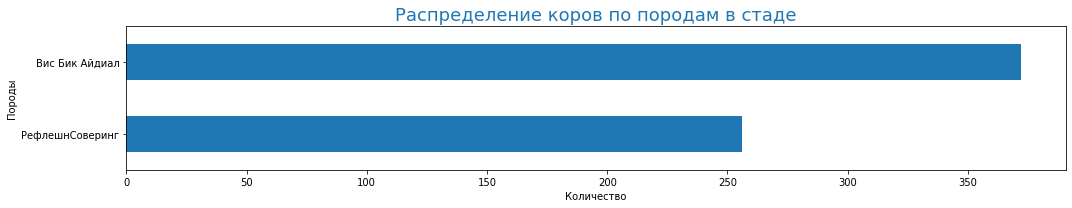

,Вис Бик Айдиал,РефлешнСоверинг
Количество,59.2%,40.8%


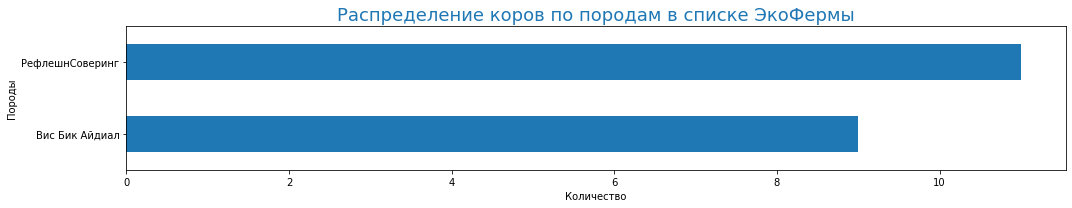

,РефлешнСоверинг,Вис Бик Айдиал
Количество,55.0%,45.0%


In [20]:
show_barh(ferma_main["breed"], "Распределение коров по породам в стаде", "Породы")
show_barh(cow_buy["breed"], "Распределение коров по породам в списке ЭкоФермы", "Породы")

В стаде Заказчика больше коров породы Вис Бик Айдиал, но разброс по количеству не очень большой, что хорошо для анализа, так как данные более репрезентативные и нет сильных сдвигов в одну сторону.

В предлагаемых для покупки Заказчику коров ЭкоФермы больше породы Соверинг, распределение также не сильно сдвинуто в одну сторону.

### Быки производители

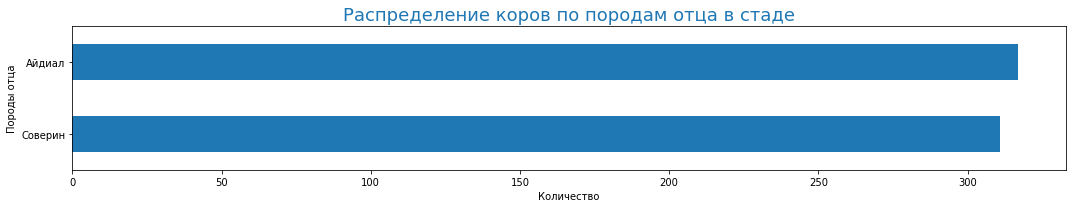

,Айдиал,Соверин
Количество,50.5%,49.5%


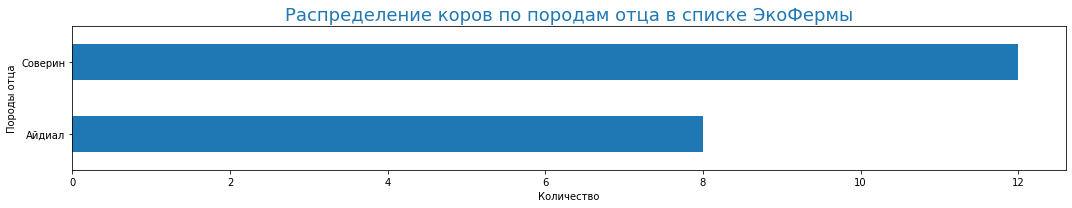

,Соверин,Айдиал
Количество,60.0%,40.0%


In [21]:
show_barh(ferma_main["dad_breed"], "Распределение коров по породам отца в стаде", "Породы отца")
show_barh(cow_buy["dad_breed"], "Распределение коров по породам отца в списке ЭкоФермы", "Породы отца")

По породам отца в стаде Заказчика коровы распределены довольно равномерно, с очень малым преимуществом породы Айдиал. В списке ЭкоФермы 12 коров из 20 имеют отцов породы Соверин.

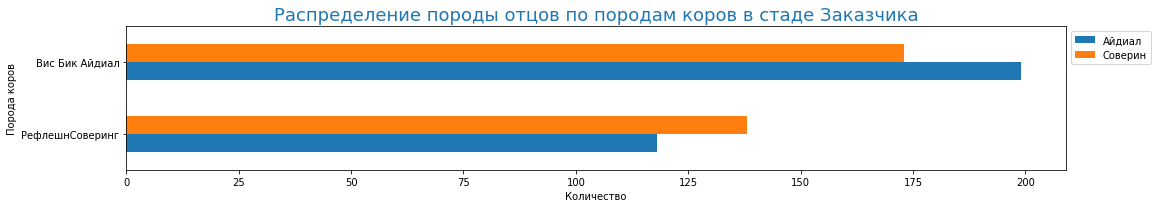

Порода отца,Айдиал,Соверин
Порода коров,,
Вис Бик Айдиал,53.5%,46.5%
РефлешнСоверинг,46.1%,53.9%


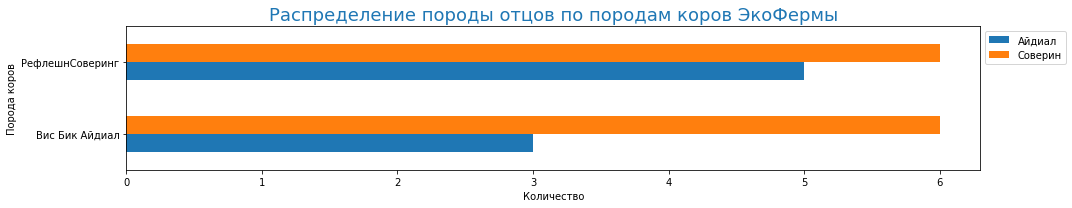

Порода отца,Айдиал,Соверин
Порода коров,,
РефлешнСоверинг,45.5%,54.5%
Вис Бик Айдиал,33.3%,66.7%


In [22]:
show_barh(
    ferma_main.pivot_table(
        index="breed", columns="dad_breed", 
        values="id", aggfunc="count"
    ),
    "Распределение породы отцов по породам коров в стаде Заказчика", 
    "Порода коров", columns="Порода отца", figsize=(15, 3)
)
show_barh(
    cow_buy.pivot_table(
        index="breed", columns="dad_breed", 
        values="age", aggfunc="count"
    ),
    "Распределение породы отцов по породам коров ЭкоФермы", 
    "Порода коров", columns="Порода отца", figsize=(15, 3)
)

Распределение породы отцов по породам коров также без больших сдвигов. У коров Заказчика больше отцов аналогичной с коровами породы, другой породы чуть меньше. По коровам ЭкоФермы больше отцов породы Соверин.

In [23]:
pd.DataFrame(
    {"Заказчик": ferma_main.groupby(["dad_breed", "dad_name"])["id"].count(),
    "ЭкоФерма": cow_buy.groupby(["dad_breed", "dad_name"])["age"].count()}
).fillna(0).rename_axis(index={"dad_breed": "Порода отца", "dad_name": "Имя отца"}).T.style.format("{:.0f}")

Заметно, что у Заказчика больше быков производителей линии Айдиал, при этом имеются быки производители с одинаковым именем и разными породами - Барин и Соловчик. Будем считать, что это разные животные, но отметим такой факт для Заказчика, для проверки возможных ошибок в данных.

По быкам производителям ЭкоФермы больше породы Соверин, при этом встречаются аналогичные имена быков, но в основном другой породы. Можно считать, что это абсолютно разные быки производители и в целом имена нужны чтобы различать отдельных быков по каждой породе друг от друга. 

Таким образом, несмотря на то, что конкретный бык производитель может оказывать влияние на производительность коров, быки производители стада Заказчика и ЭкоФермы это разные животные. Сравнивать по конкретному имени быка производителя ЭкоФермы и Заказчика не имеет смысла. Также можно сказать, что у нас имеются 4 аналогичные пары значений имен и пород для разных выборок - Айдиал Буйный, Айдиал Геркулес, Соверин Барин и Соверин Соловчик, которые вероятно являются различными животными. Либо в ЭкоФерме имеются 14 коров, быки производители которых являются отцами коров в стаде Заказчика.

### Тип пастбища

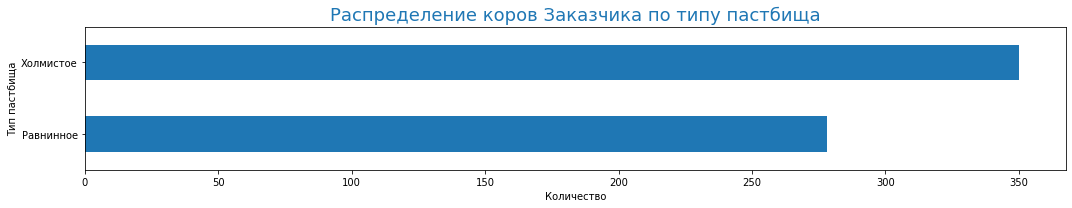

,Холмистое,Равнинное
Количество,55.7%,44.3%


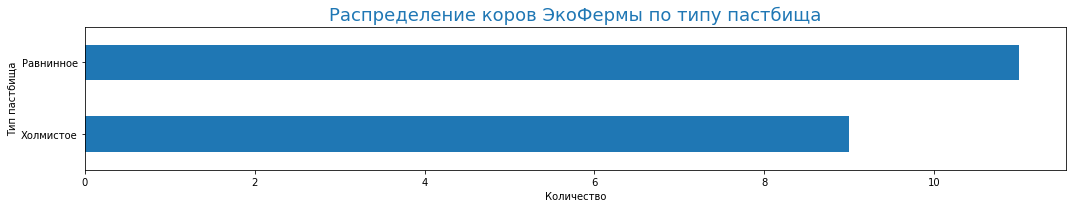

,Равнинное,Холмистое
Количество,55.0%,45.0%


In [24]:
show_barh(
    ferma_main["landscape"],
    "Распределение коров Заказчика по типу пастбища",
    "Тип пастбища"
)
show_barh(
    cow_buy["landscape"],
    "Распределение коров ЭкоФермы по типу пастбища",
    "Тип пастбища"
)

По типу пастбища распределение коров как в стаде Заказчика, так и ЭкоФермы достаточно близкое. В стаде Заказчика немного больше коров выпасаются на холмистых пастбищах, в ЭкоФерме наоборот больше на равнинных.

### Возвраст коровы

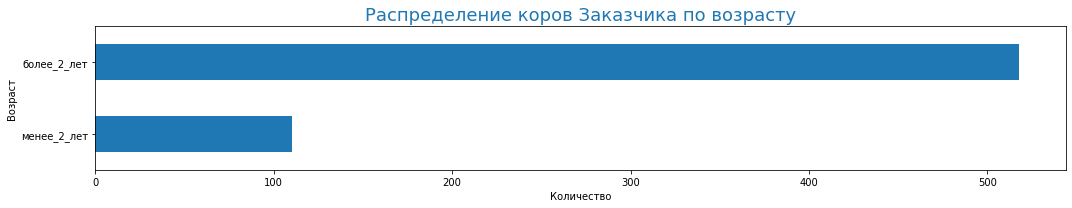

,более_2_лет,менее_2_лет
Количество,82.5%,17.5%


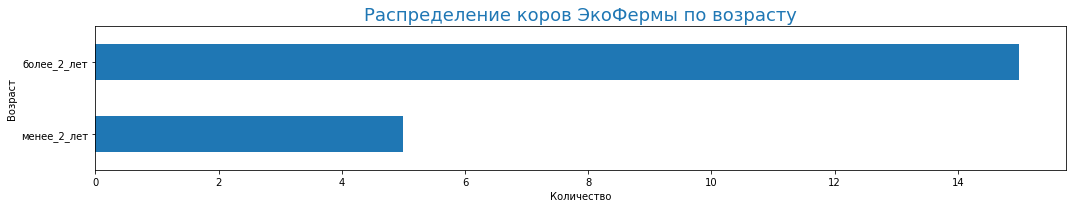

,более_2_лет,менее_2_лет
Количество,75.0%,25.0%


In [25]:
show_barh(
    ferma_main["age"],
    "Распределение коров Заказчика по возрасту",
    "Возраст"
)
show_barh(
    cow_buy["age"],
    "Распределение коров ЭкоФермы по возрасту",
    "Возраст"
)

По возрасту коров основная масса в стаде Заказчика и в списке коров ЭкоФермы возрастом старше 2-х лет. При этом соотношение коров ЭкоФермы моложе 2-х лет выше, чем в стаде Заказчика. Будем считать, что Заказчиком проведен анализ реального возраста коров в ЭкоФерме и возраст коров далек от того, когда начинается снижение удоя.

Разделение по возрасту считаю не очень удачным, таким мы только отделяем коров первого отела от остальных. Желательно было бы разделять либо по конкретному полному возрасту, либо делить на несколько групп, таких как: менее 2-х лет, от 2-х до 4-х, от 4-х до 7-ми и старше 7-ми лет. Так можно было бы точнее выявить зависимость удоя от возраста.

### Вкус молока

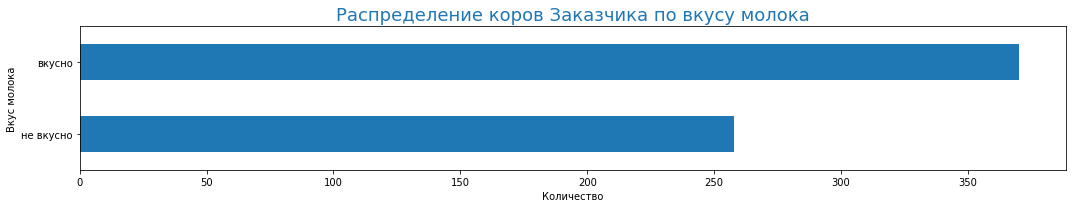

,вкусно,не вкусно
Количество,58.9%,41.1%


In [26]:
show_barh(
    ferma_main["milk_taste"],
    "Распределение коров Заказчика по вкусу молока",
    "Вкус молока"
)

По вкусу молока в стаде Заказчика больше коров имеют "вкусное" молоко, но коров с "не вкусным" молоком достаточно много - 41.1%.

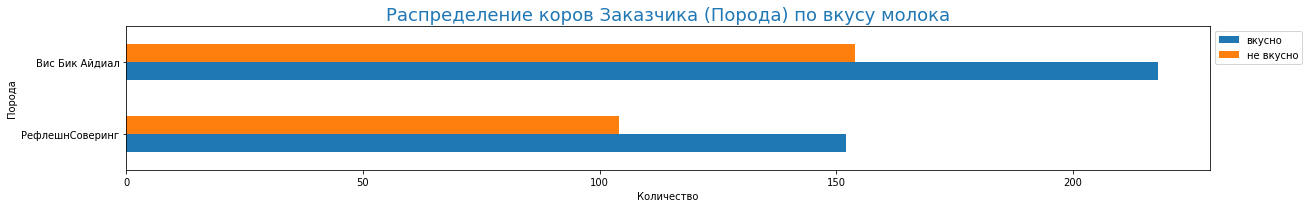

Вкус молока,вкусно,не вкусно
Порода,,
Вис Бик Айдиал,58.6%,41.4%
РефлешнСоверинг,59.4%,40.6%


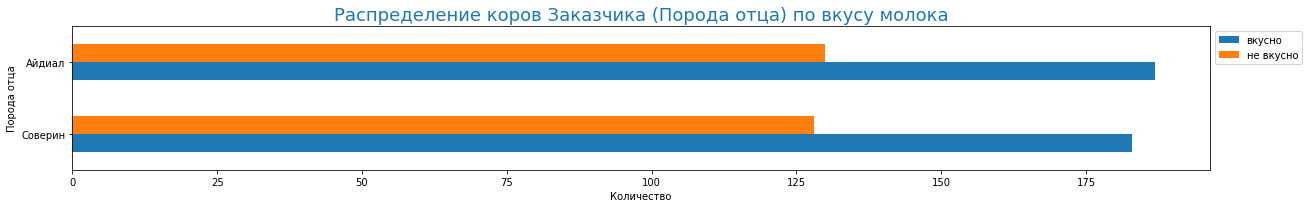

Вкус молока,вкусно,не вкусно
Порода отца,,
Айдиал,59.0%,41.0%
Соверин,58.8%,41.2%


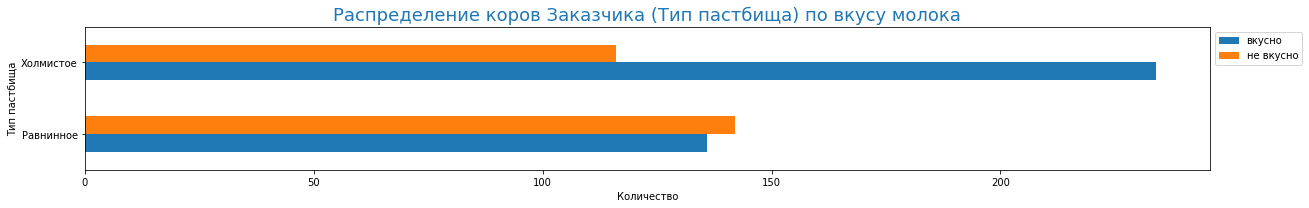

Вкус молока,вкусно,не вкусно
Тип пастбища,,
Холмистое,66.9%,33.1%
Равнинное,48.9%,51.1%


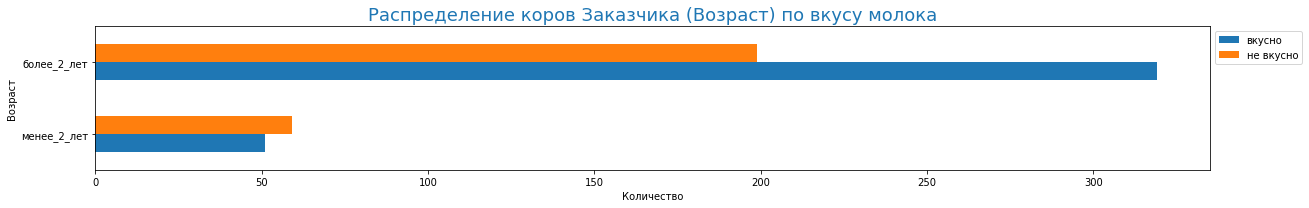

Вкус молока,вкусно,не вкусно
Возраст,,
более_2_лет,61.6%,38.4%
менее_2_лет,46.4%,53.6%


In [27]:
# Словарь расшифровки категориальных признаков
ferma_qual_cols = {"breed": "Порода", "dad_breed": "Порода отца", "landscape": "Тип пастбища",
                   "age": "Возраст", "milk_taste": "Вкус молока"}

for col, val in ferma_qual_cols.items():
    if col != "milk_taste":
        show_barh(
            ferma_main.pivot_table(
                index=col, columns="milk_taste",
                values="id", aggfunc="count"
            ),
            f"Распределение коров Заказчика ({val}) по вкусу молока", 
            val, columns="Вкус молока", figsize=(17, 3)
        )

Сильнее всего влияет на вкус молока тип пастбища - более вкусное молоко для холмистых пастбищ, а также достаточно сильное влияние оказывает возраст коровы - более вкусное молоко у коров возрастом более 2-х лет.

### Характеристики корма
#### ЭКЕ

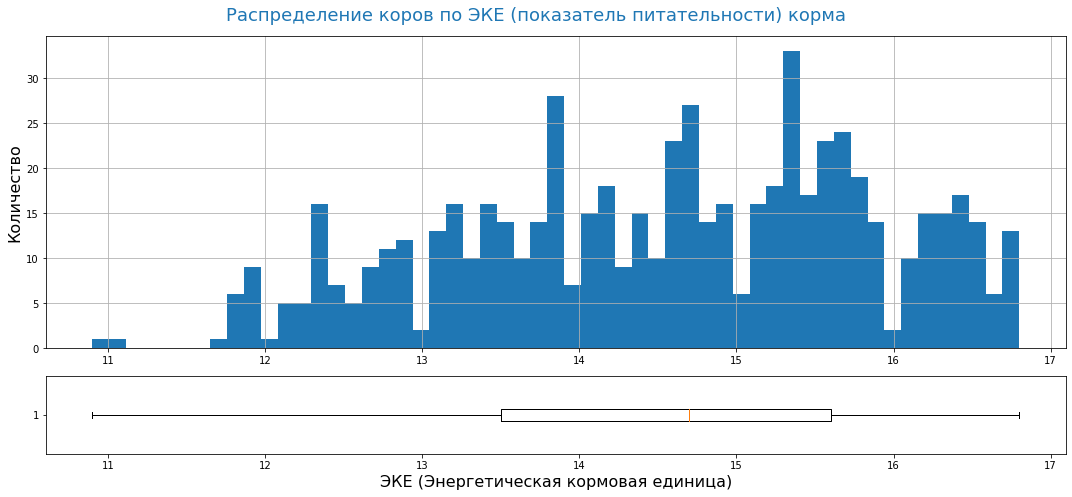

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
ЭКЕ (Энергетическая кормовая единица),628.0,14.548726,1.301777,10.9,13.5,14.7,15.6,16.8,Probably NOT,9.631185e-10


In [28]:
show_hist(ferma_main["food_energy"], 
            "Распределение коров по ЭКЕ (показатель питательности) корма", 
            "ЭКЕ (Энергетическая кормовая единица)", bins=55, figsize=(15, 7), boxplot=True)

В распределении коров по показателю ЭКЕ достаточно сильно заметна дискретность в данных, возможно на это влияет недостаточно большая выборка, но может быть имеет место какое-то разделение стада на группы по питанию. Имеются несколько пиков в распределении, самый большой в районе медианы - 14.7 единиц, причем данный пик разделен на две части, другой пик поменьше находится между значениями 15 и 16 единиц. Также можно отметить небольшой выброс в районе значения 11 единиц

В целом данные также достаточно равномерно распределены с небольшим сдвигом в правую сторону, нижние значения в пределах 12-13 единиц немного меньше основных значений ЭКЕ, которые располагаются достаточно равномера в районе 13-16.5 единиц, без учета ранее указанных пиков. До 50% коров питаются кормом в пределах от 13.5 до 15.6 единиц ЭКЕ.

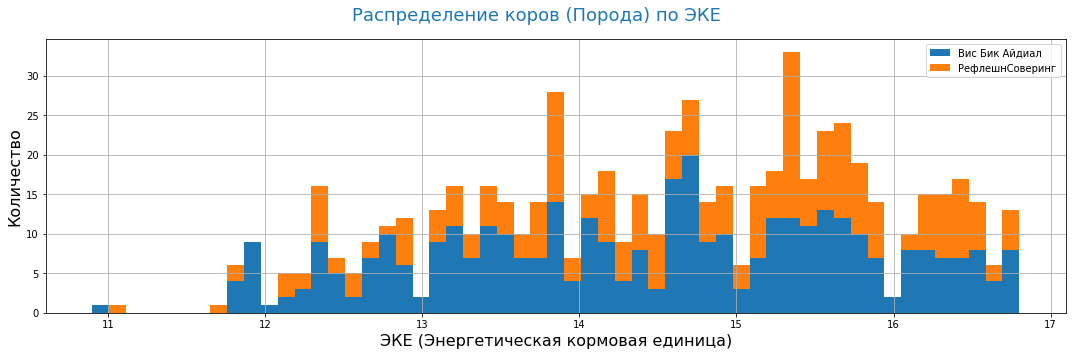

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,372.0,14.444624,1.320315,10.9,13.4,14.6,15.6,16.8,Probably NOT,0.000003
РефлешнСоверинг,256.0,14.700000,1.261652,11.1,13.8,14.9,15.7,16.8,Probably NOT,0.000006


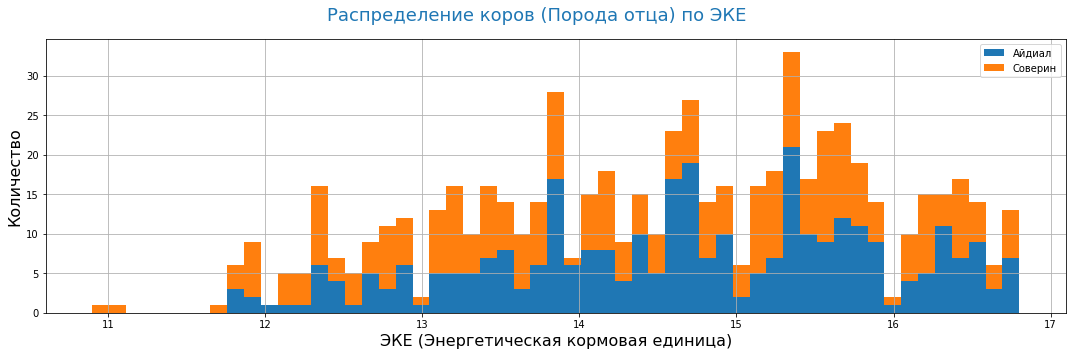

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,317.0,14.677603,1.208659,11.8,13.8,14.7,15.6,16.8,Probably NOT,0.000024
Соверин,311.0,14.417363,1.379886,10.9,13.3,14.6,15.6,16.8,Probably NOT,0.000001


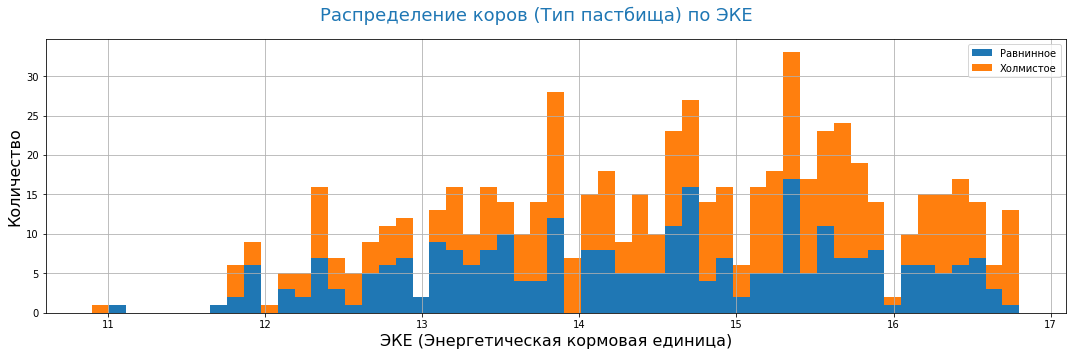

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,278.0,14.405755,1.302886,11.1,13.4,14.6,15.5,16.7,Probably NOT,2.143288e-05
Холмистое,350.0,14.662286,1.291500,10.9,13.7,14.8,15.7,16.8,Probably NOT,7.478653e-07


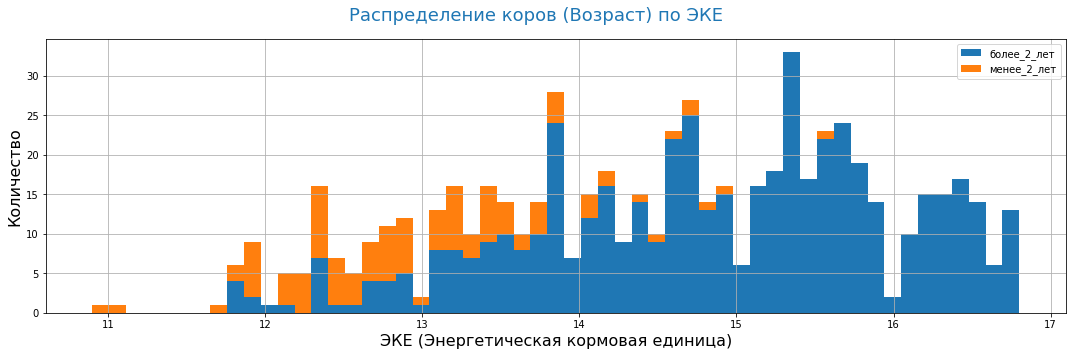

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,518.0,14.881467,1.129953,11.8,14.1,15.0,15.7,16.8,Probably NOT,1.614735e-08
менее_2_лет,110.0,12.981818,0.829522,10.9,12.4,12.9,13.4,15.6,Probably,1.415218e-01


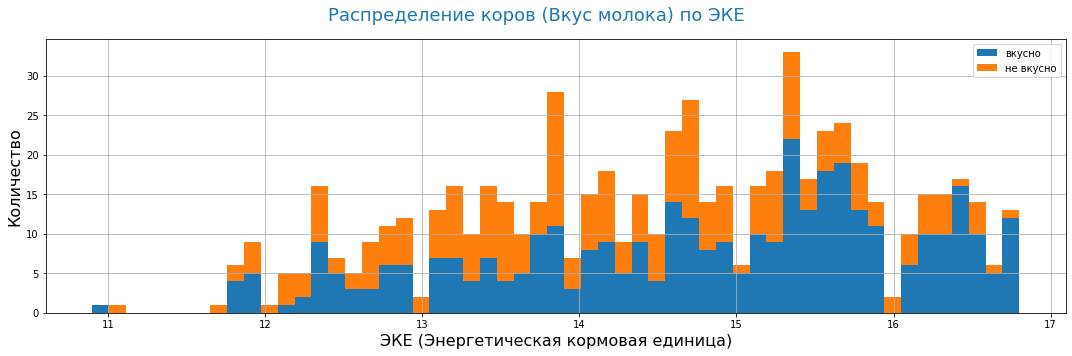

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Вкус молока,,,,,,,,,,
вкусно,370.0,14.781622,1.306120,10.9,13.825,15.0,15.775,16.8,Probably NOT,2.395645e-09
не вкусно,258.0,14.214729,1.222653,11.1,13.300,14.2,15.200,16.7,Probably NOT,8.841463e-03


In [29]:
for col, val in ferma_qual_cols.items():
    show_hist(
        ferma_main.pivot(columns=col, values="food_energy"),
        f"Распределение коров ({val}) по ЭКЕ", "ЭКЕ (Энергетическая кормовая единица)",
        columns=val, bins=55
    )

Распределение параметров коров по ЭКЕ довольно равномерное, кроме двух последних графиков - возраст коровы и вкус молока. По возрасту коровы заметно, что для коров старше 2-х лет ЭКЕ в целом выше, соответственно кормят их лучше. По вкусу молока распределение также сдвинуто больше в сторону большего ЭКЕ, но не так сильно выражено, как с возрастом. В части распределения типов пастбищ коров также заметно, что немного больше коров с высоким ЭКЕ для холмистого типа пастбища, хотя это может быть просто следствием большего количества коров с таким типом пастбища.

#### Содержание протеина в корме

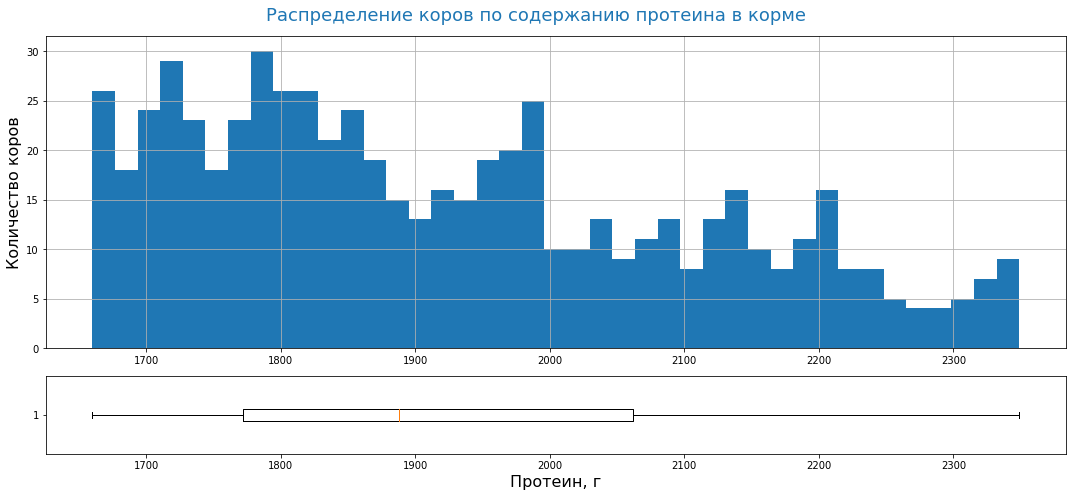

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Протеин, г",628.0,1923.759554,182.832816,1660.0,1771.75,1888.0,2062.25,2349.0,Probably NOT,1.071367e-14


In [30]:
show_hist(ferma_main["food_protein"], 
            "Распределение коров по содержанию протеина в корме", 
            "Протеин, г", "Количество коров", bins=41, figsize=(15, 7), boxplot=True)

Распределение коров по содержанию протеина в корме имеет значительный сдвиг влево. Большая часть коров питаются в кормом с содержанием протеина в пределах до 2000 грамм. Далее количество коров достаточно резко сокращается и держится в пределах 10-15 коров по мере роста содержания протеина в корме. Условно можно разделить на две группы - менее 2000 грамм и более, которые достаточно сильно различаются по количеству. Внутри групп также имеются подгруппы более низкого уровня, которые сгруппированы вблизи определенных значений.

Имеется два достаточно больших пика между значеними 1700 и 1800 грамм, которые разделены снижением количества коров по содержанию протеина в районе 1750 грамм. Достаточно большое снижение наблюдается в районе 1900 грамм с последующим ростом. 

В группе более 2000 грамм также наблюдается ряд пиков с последующим снижением количества коров, после которых также наблюдается достаточно большое снижение на показателях от 2200 грамм до 2300 с последующим небольшим ростом по количеству.

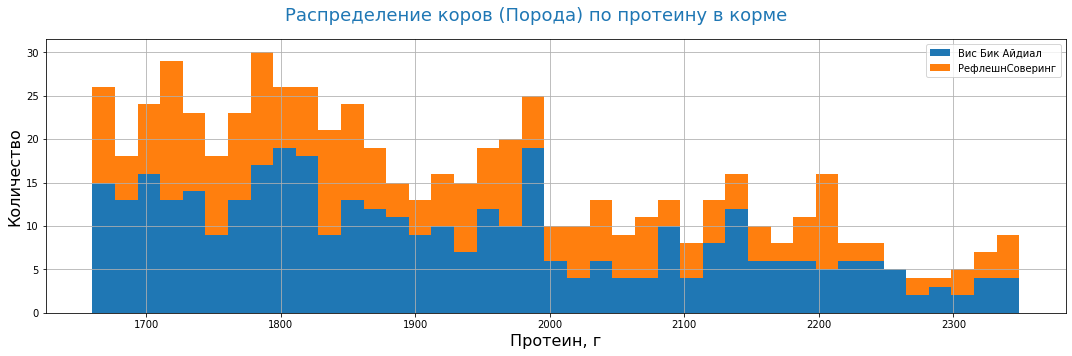

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,372.0,1922.620968,181.904551,1661.0,1777.5,1885.5,2064.0,2349.0,Probably NOT,1.012894e-10
РефлешнСоверинг,256.0,1925.414062,184.517964,1660.0,1769.0,1889.5,2056.5,2346.0,Probably NOT,1.787786e-08


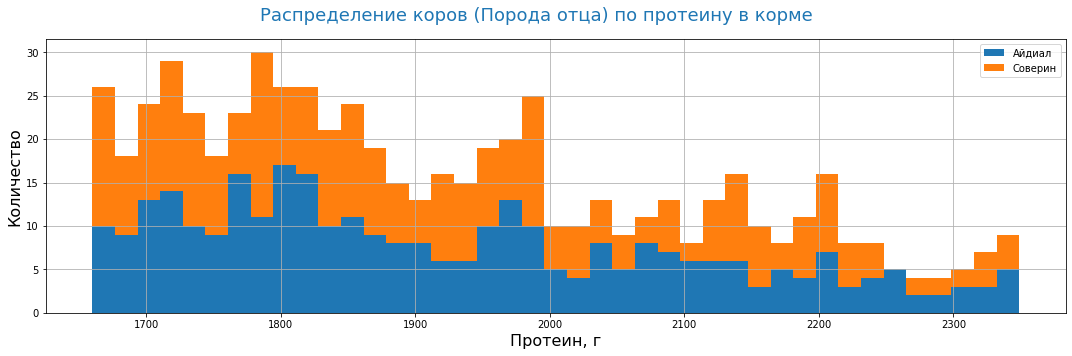

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,317.0,1925.082019,181.948698,1664.0,1775.0,1890.0,2063.0,2349.0,Probably NOT,7.360534e-10
Соверин,311.0,1922.411576,184.013072,1660.0,1767.0,1880.0,2055.0,2346.0,Probably NOT,1.672282e-09


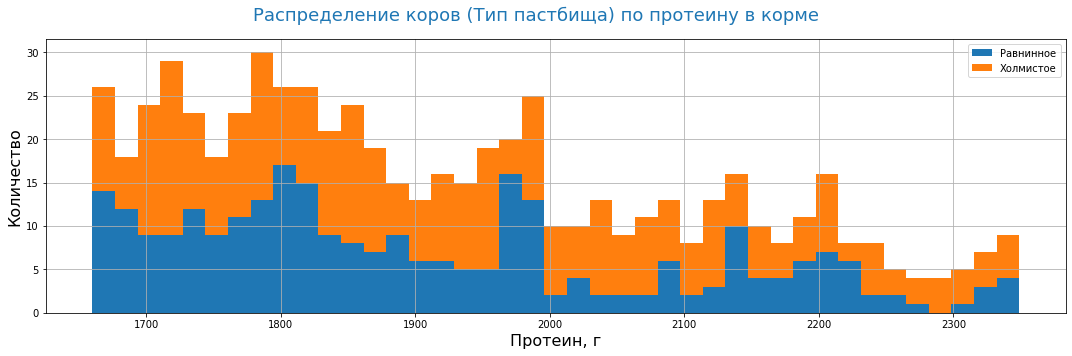

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,278.0,1909.420863,180.461900,1662.0,1766.25,1866.0,2017.50,2349.0,Probably NOT,6.187155e-10
Холмистое,350.0,1935.148571,184.155941,1660.0,1783.25,1912.0,2073.75,2343.0,Probably NOT,1.553062e-09


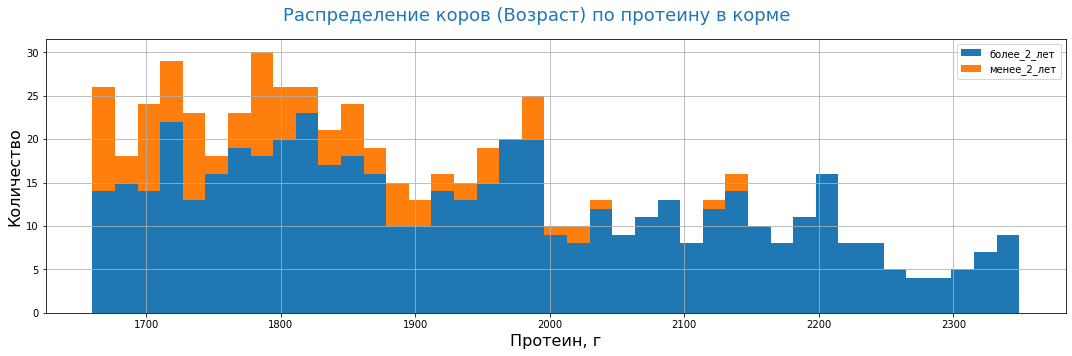

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,518.0,1948.117761,185.515153,1660.0,1794.00,1928.0,2094.50,2349.0,Probably NOT,1.128488e-11
менее_2_лет,110.0,1809.054545,113.800553,1662.0,1718.25,1786.0,1878.25,2138.0,Probably NOT,1.830174e-05


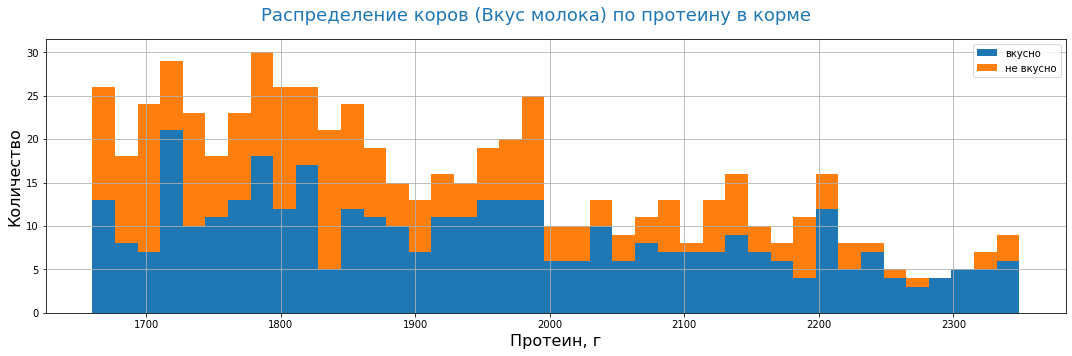

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Вкус молока,,,,,,,,,,
вкусно,370.0,1946.429730,187.163021,1661.0,1788.0,1925.0,2088.0,2343.0,Probably NOT,9.060369e-10
не вкусно,258.0,1891.248062,171.629001,1660.0,1751.5,1845.0,1994.0,2349.0,Probably NOT,1.262054e-09


In [31]:
for col, val in ferma_qual_cols.items():
    show_hist(
        ferma_main.pivot(columns=col, values="food_protein"),
        f"Распределение коров ({val}) по протеину в корме", "Протеин, г",
        columns=val, bins=41
    )

По распределению возраста коров также заметен сдвиг в сторону большего содержания протеина в корме для коров старше 2-х лет. Также вкус молока коров лучше в более высоком содержании протеина, особенно более 2200, однако зависимость не столь заметно и большое количество вкусного молока имеется и для более низкого содержания протеина. В разрезе породы коров и породы их отцов, а также типов пастбищ перекосов не выявлено, однако заметны отдельные пики в зависимости от данных параметров. По холмистым пастбищам также заметно большее количество в более высоких значениях по содержанию протеина, но коров на таком пастбище больше в выборке.

#### СПО

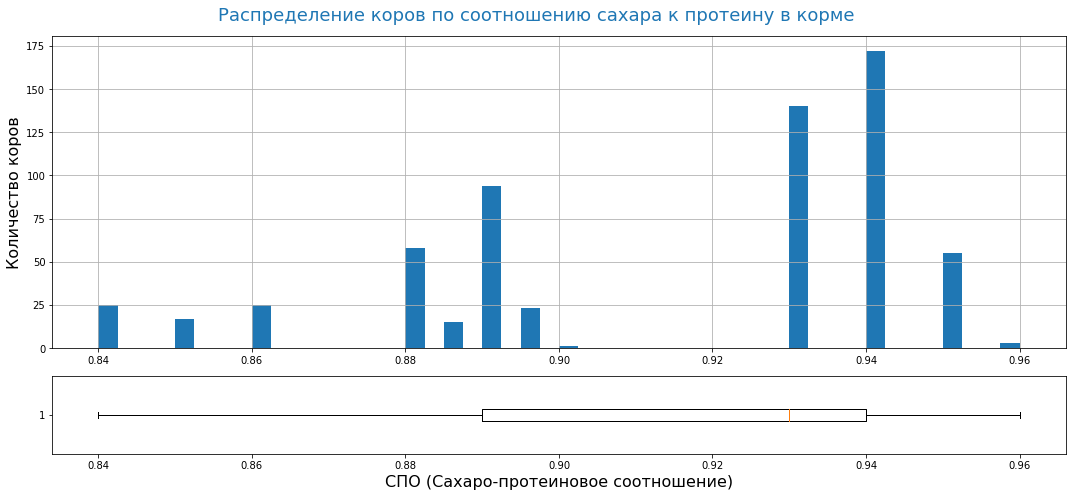

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
СПО (Сахаро-протеиновое соотношение),628.0,0.913089,0.032221,0.84,0.89,0.93,0.94,0.96,Probably NOT,1.534507e-23


Уникальные значения: [0.84, 0.85, 0.86, 0.88, 0.885, 0.89, 0.895, 0.9, 0.93, 0.94, 0.95, 0.96]


In [32]:
show_hist(ferma_main["food_sugar_protein"], 
          "Распределение коров по соотношению сахара к протеину в корме", 
          "СПО (Сахаро-протеиновое соотношение)", "Количество коров", bins=48, 
          figsize=(15, 7), boxplot=True)
print(f"Уникальные значения: {sorted(ferma_main['food_sugar_protein'].unique())}")

По сахаро-протеиновому соотношению коровы можно распределить в три группы - самая малая по количеству коров в пределах 0.84-0.86. Далее после небольшого пропуска идет группа побольше в пределах 0.88-0.90, причем имеются промежуточные значения 0.885 и 0.895, хотя все остальные данные двухзначные. Если округлить до двухзначных, то заметен рост с последующим падением в двух более крупных группах.  После существенного пропуска в значениях располагается самая большая по количеству коров при СПО между 0.93 и 0.96. Не считая пропуска в значении 0.87 можно сказать, что в целом наблюдается рост со значений 0.84 до 0.89, после чего падение на 0.90, для значений 0.91 и 0.92 отсутствуют. Далее более высокий рост на значениях 0.93 и 0.94 с последующим сильным падением к 0.96 по количеству коров.

Для большего удобства проведения дальнейшего анализа будем приводить значения до двузначных, так как промежуточные значения делают небольшой перекос при визуальном сравнении.

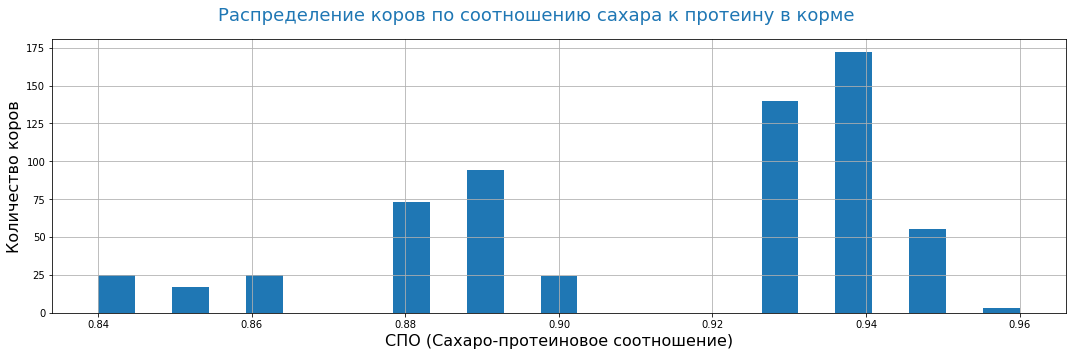

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
СПО (Сахаро-протеиновое соотношение),628.0,0.913153,0.032246,0.84,0.89,0.93,0.94,0.96,Probably NOT,1.909241e-23


In [33]:
show_hist(ferma_main["food_sugar_protein"].round(2), 
            "Распределение коров по соотношению сахара к протеину в корме", 
            "СПО (Сахаро-протеиновое соотношение)", "Количество коров", bins=25)

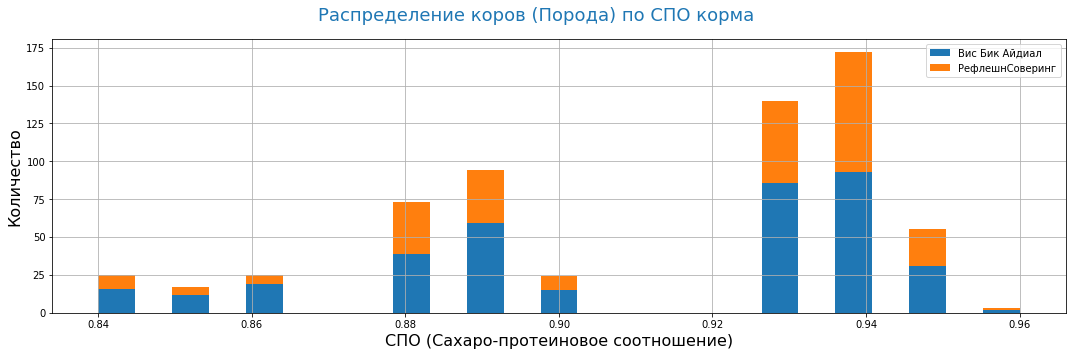

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,372.0,0.911505,0.032883,0.84,0.89,0.93,0.94,0.96,Probably NOT,2.283034e-17
РефлешнСоверинг,256.0,0.915547,0.031206,0.84,0.89,0.93,0.94,0.96,Probably NOT,1.567082e-15


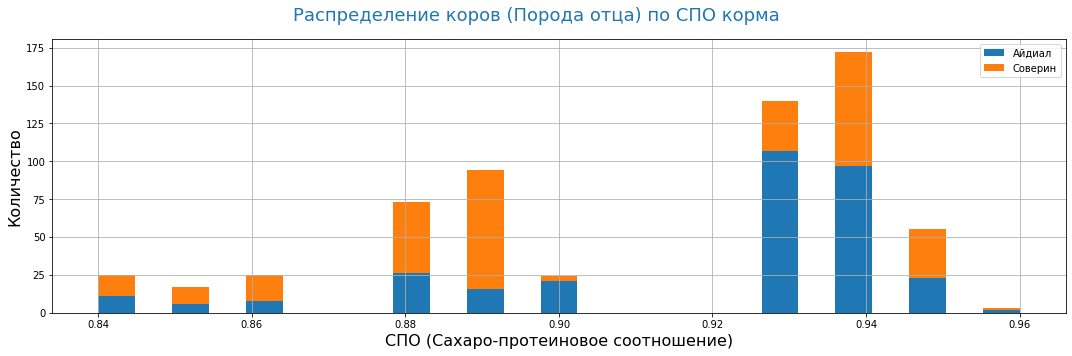

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,317.0,0.920189,0.029034,0.84,0.90,0.93,0.94,0.96,Probably NOT,3.340680e-20
Соверин,311.0,0.905981,0.033787,0.84,0.88,0.89,0.94,0.96,Probably NOT,8.364477e-15


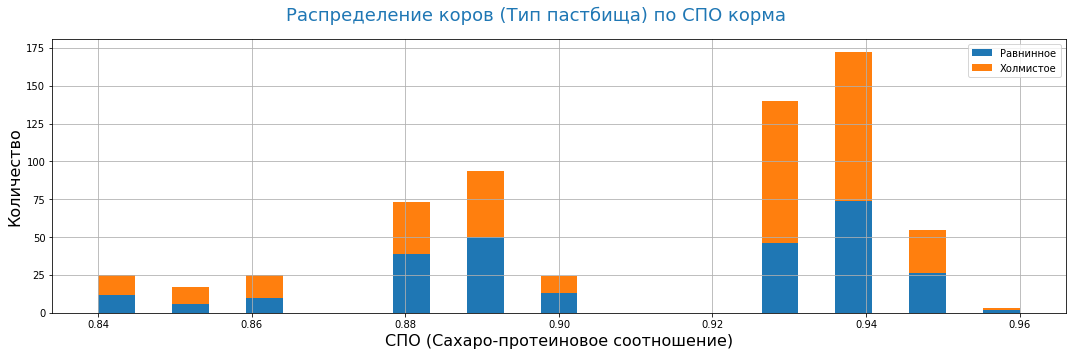

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,278.0,0.911007,0.032530,0.84,0.89,0.93,0.94,0.96,Probably NOT,3.216588e-14
Холмистое,350.0,0.914857,0.031963,0.84,0.89,0.93,0.94,0.96,Probably NOT,9.248172e-19


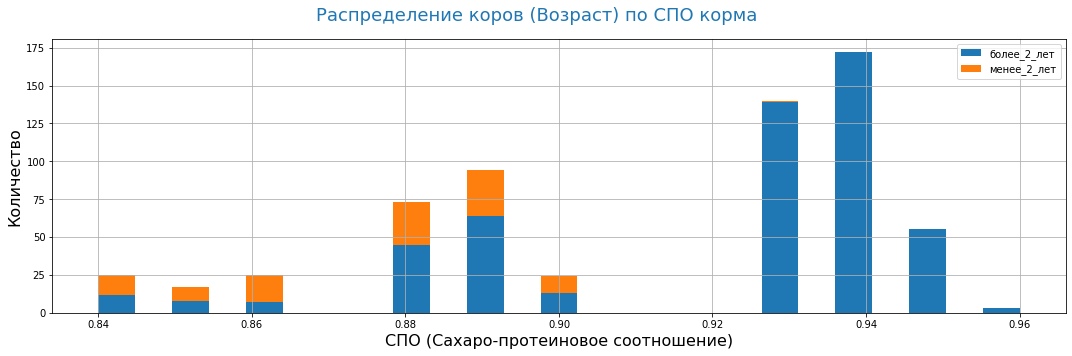

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,518.0,0.921313,0.028233,0.84,0.89,0.93,0.94,0.96,Probably NOT,9.782320e-25
менее_2_лет,110.0,0.874727,0.019848,0.84,0.86,0.88,0.89,0.93,Probably NOT,3.943032e-07


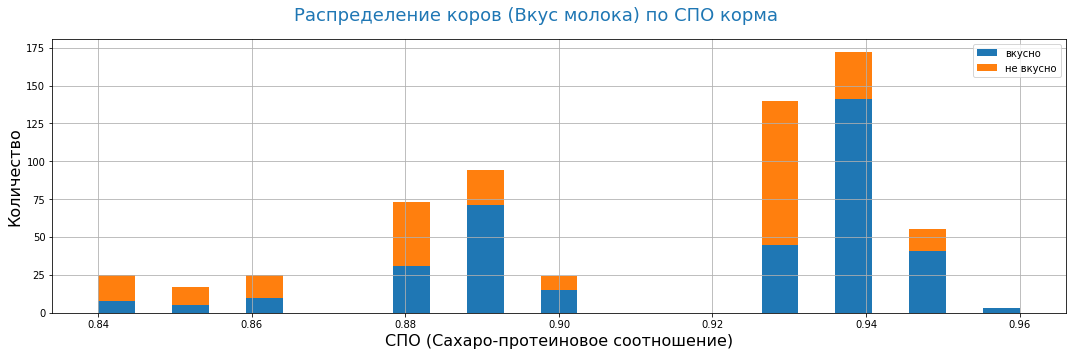

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Вкус молока,,,,,,,,,,
вкусно,370.0,0.918270,0.030027,0.84,0.89,0.935,0.94,0.96,Probably NOT,1.407713e-19
не вкусно,258.0,0.905814,0.033919,0.84,0.88,0.930,0.93,0.95,Probably NOT,1.324504e-14


In [34]:
for col, val in ferma_qual_cols.items():
    show_hist(
        ferma_main.pivot(columns=col, values="food_sugar_protein").round(2),
        f"Распределение коров ({val}) по СПО корма", 
        "СПО (Сахаро-протеиновое соотношение)",
        columns=val, bins=25
    )

Также заметен сильный сдвиг по СПО для коров старше 2-х лет в большую сторону. Вкус молока показывает разнонаправленную динамику. По отцу коровы Соверин показывает менее высокие показатели. Также заметно, что по типу пастбища больше коров с высоким СПО, которые пасутся на холмистых пастбищах. По другим распределение достаточно равномерно, перекосов не отмечаю.

### Характеристики молока

#### Содержание жиров

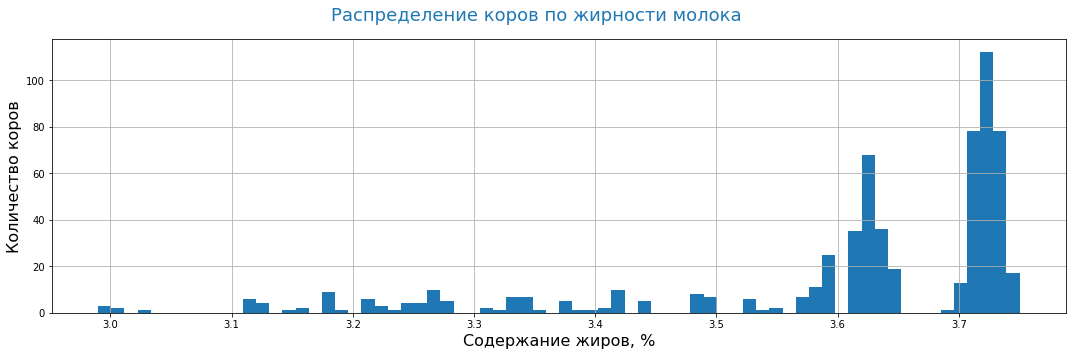

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Содержание жиров, %",628.0,3.604268,0.168093,2.99,3.59,3.65,3.72,3.75,Probably NOT,4.189231e-30


In [35]:
show_hist(ferma_main["milk_fat"], 
            "Распределение коров по жирности молока", 
            "Содержание жиров, %", "Количество коров", bins=70)

По содержанию жиров в молоке можно сказать, что коровы в стаде разделены на три большие группы. 

Содержание жиров в самой большой группе составляет 3.7-3,75%. Содержание жиров в молоке второй группы имеет больший разброс порядка 3.55-3.65%. Остальные достаточно равномерно распределены между значениями 3.55-3.1% с небольшим выбросом в районе 3%.

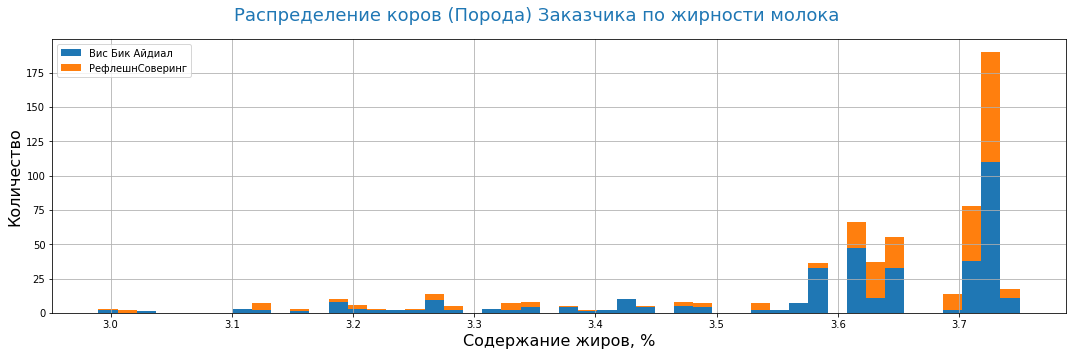

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,372.0,3.596935,0.167189,2.99,3.58,3.64,3.72,3.75,Probably NOT,2.824956e-22
РефлешнСоверинг,256.0,3.614922,0.169157,2.99,3.62,3.70,3.72,3.74,Probably NOT,1.364941e-21


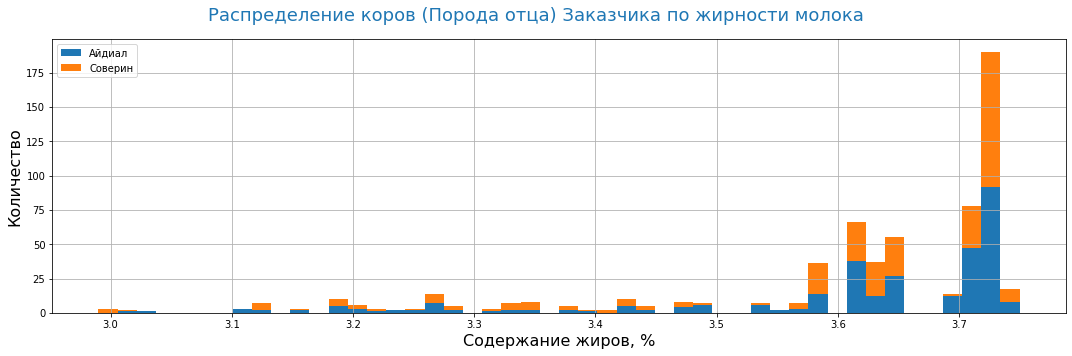

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,317.0,3.610284,0.163162,3.01,3.59,3.70,3.72,3.74,Probably NOT,2.222319e-22
Соверин,311.0,3.598135,0.173022,2.99,3.59,3.64,3.72,3.75,Probably NOT,2.761698e-21


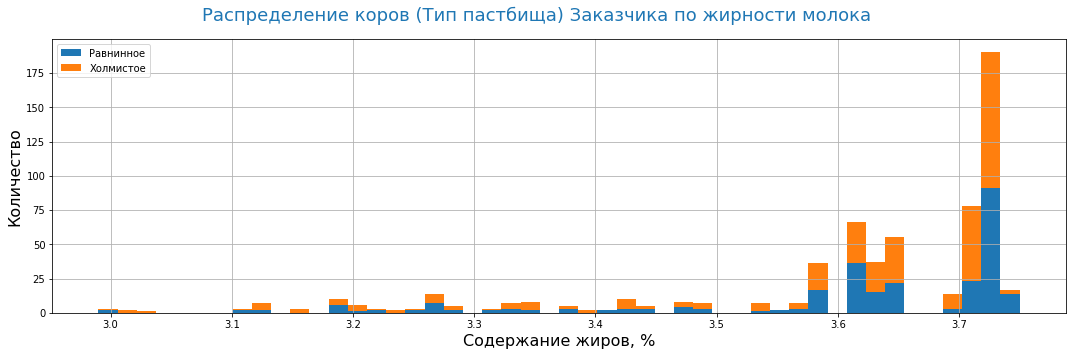

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,278.0,3.608453,0.164302,2.99,3.59,3.645,3.72,3.75,Probably NOT,2.204793e-20
Холмистое,350.0,3.600943,0.171205,2.99,3.59,3.650,3.72,3.74,Probably NOT,3.601918e-23


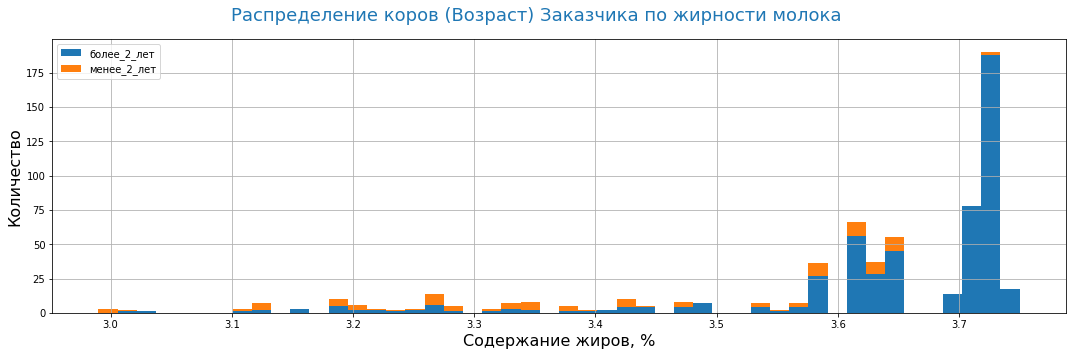

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,518.0,3.643436,0.132387,3.01,3.62,3.71,3.72,3.75,Probably NOT,1.265031e-30
менее_2_лет,110.0,3.419818,0.194366,2.99,3.27,3.42,3.61,3.73,Probably NOT,7.200640e-06


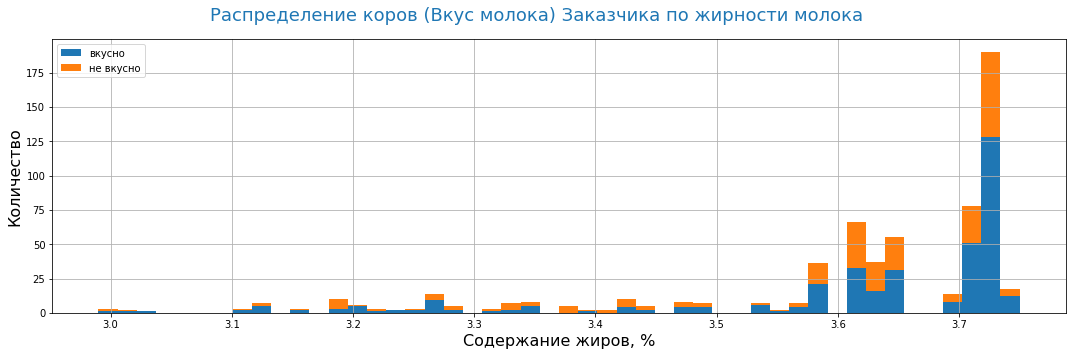

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Вкус молока,,,,,,,,,,
вкусно,370.0,3.617486,0.164526,2.99,3.6100,3.71,3.72,3.75,Probably NOT,4.373882e-25
не вкусно,258.0,3.585310,0.171628,2.99,3.5725,3.63,3.72,3.74,Probably NOT,4.827525e-18


In [36]:
for col, val in ferma_qual_cols.items():
    show_hist(
        ferma_main.pivot(columns=col, values="milk_fat"),
        f"Распределение коров ({val}) Заказчика по жирности молока", 
        "Содержание жиров, %",
        columns=val, bins=48
    )

В разрезе параметров коров и жирности молока заметно, что большая жирность у коров старше 2-х лет, но похоже, что это не сильно влияет на вкус молока, так как имеется преимущество по вкусу и с более низким содержанием жиров, хотя это может быть следствием более высокого количества коров со вкусным молоком в стаде Заказчика. Распределине коров по остальным параметрам достаточно равномерное, сдвигов не наблюдается.

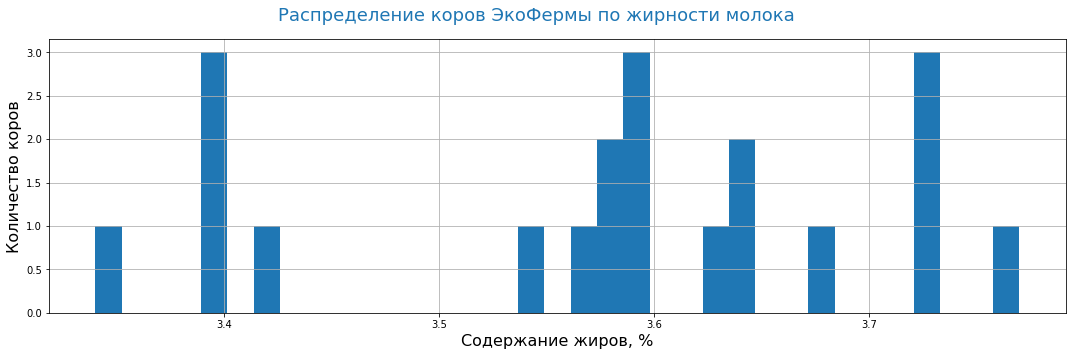

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Содержание жиров, %",20.0,3.5775,0.126818,3.34,3.51,3.59,3.65,3.77,Probably,0.114005


In [37]:
show_hist(cow_buy["current_milk_fat"], 
            "Распределение коров ЭкоФермы по жирности молока", 
            "Содержание жиров, %", "Количество коров", bins=35)

По коровам ЭкоФермы разброс по жирности молока меньше, при этом жирность более высокая, чем в стаде Заказчика. Это может быть как следствием существенно меньшего размера выборки, насколько верные показатели мы судить не можем.

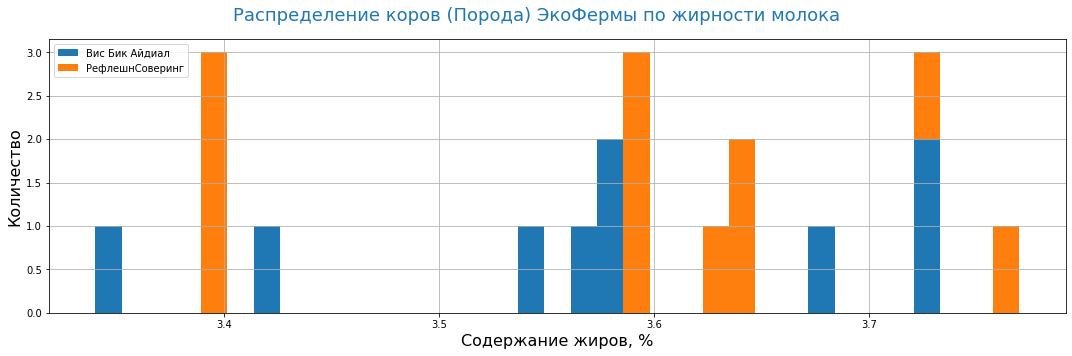

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,9.0,3.574444,0.132109,3.34,3.540,3.58,3.68,3.73,Probably,0.409449
РефлешнСоверинг,11.0,3.580000,0.128763,3.40,3.495,3.59,3.64,3.77,Probably,0.088819


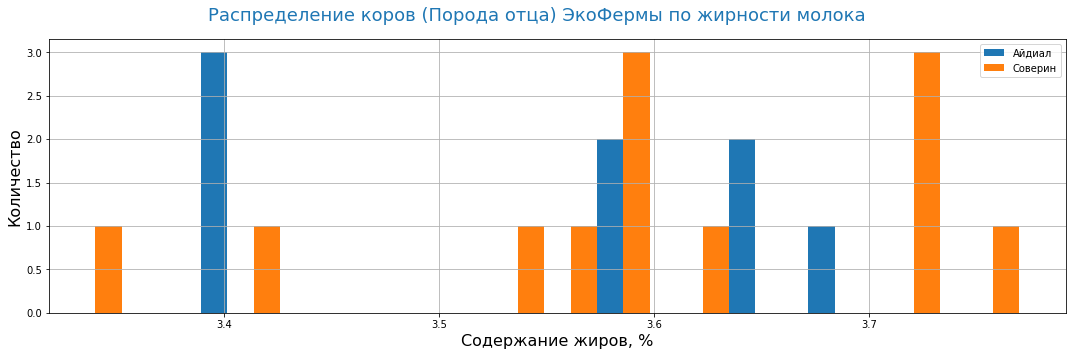

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,8.0,3.5400,0.120475,3.40,3.4000,3.58,3.64,3.68,Probably NOT,0.039111
Соверин,12.0,3.6025,0.129764,3.34,3.5625,3.59,3.73,3.77,Probably,0.263469


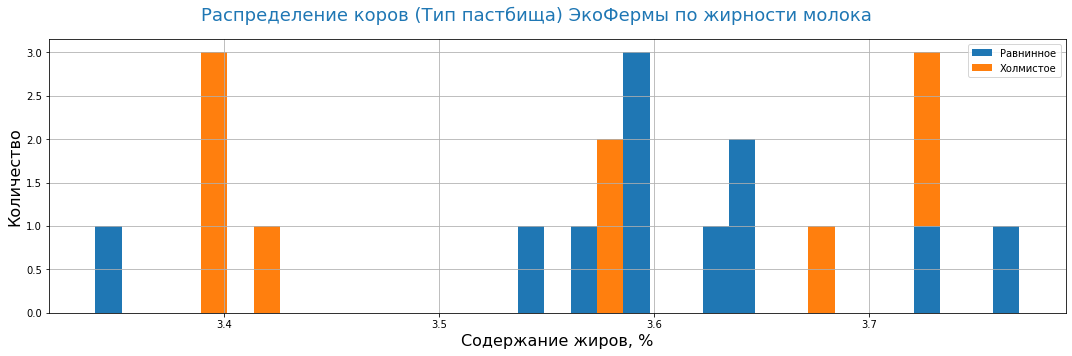

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,11.0,3.602727,0.110552,3.34,3.58,3.59,3.64,3.77,Probably,0.134025
Холмистое,9.0,3.546667,0.144827,3.40,3.40,3.58,3.68,3.73,Probably NOT,0.038819


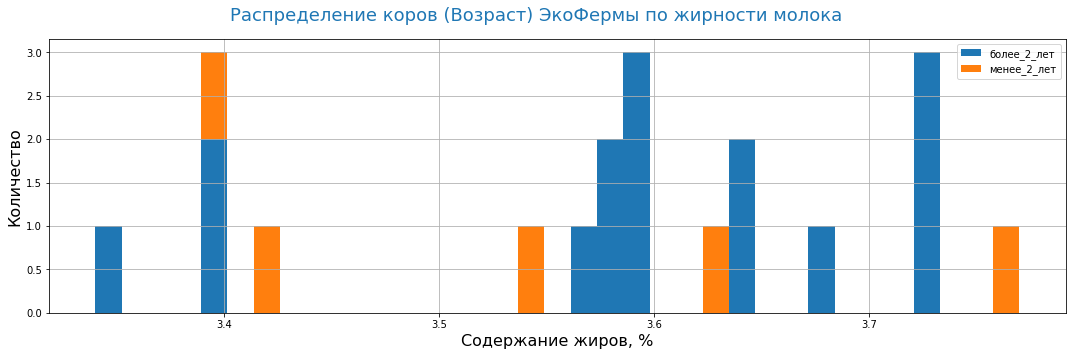

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,15.0,3.586,0.121585,3.34,3.575,3.59,3.66,3.73,Probably NOT,0.044329
менее_2_лет,5.0,3.552,0.153525,3.40,3.420,3.54,3.63,3.77,Probably,0.617668


In [38]:
for col, val in {
    k:v for k,v in ferma_qual_cols.items() if k != "milk_taste"
}.items():
    show_hist(
        cow_buy.pivot(columns=col, values="current_milk_fat"),
        f"Распределение коров ({val}) ЭкоФермы по жирности молока", 
        "Содержание жиров, %",
        columns=val, bins=35
    )

В разрезе параметров коров ЭкоФермы можно отметить корову возрастом менее 2 лет с очень высоким содержанием жиров. Это довольно нехарактерно, если сравнивать с такими показателями по стаду Заказчика, где очень мало молодых коров с высоким содержанием жира в молоке.

#### Содержание белков

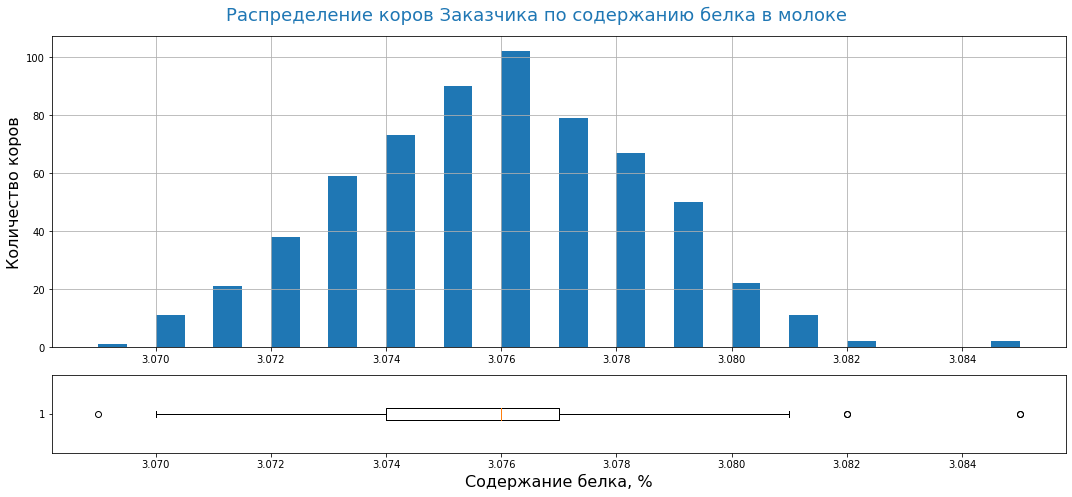

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Содержание белка, %",628.0,3.07567,0.002551,3.069,3.074,3.076,3.077,3.085,Probably NOT,0.000001


Количество уникальных значений: 15


In [39]:
show_hist(ferma_main["milk_protein"], 
          "Распределение коров Заказчика по содержанию белка в молоке", 
          "Содержание белка, %", "Количество коров", bins=32, 
          figsize=(15, 7), boxplot=True)
print(f"Количество уникальных значений: {ferma_main['milk_protein'].unique().shape[0]}")

По содержанию белка в молоке распределение коров похоже на нормальное, однако тест Шапиро-Уилка говорит о вероятно не нормальном распределении. Среднее значение 3.076%, разброс в пределах 14 значений, имеется 15-е значение в виде небольшого выброса в районе 3.085%. Также имеется небольшой сдвиг по количеству коров в левую (меньшую) сторону.

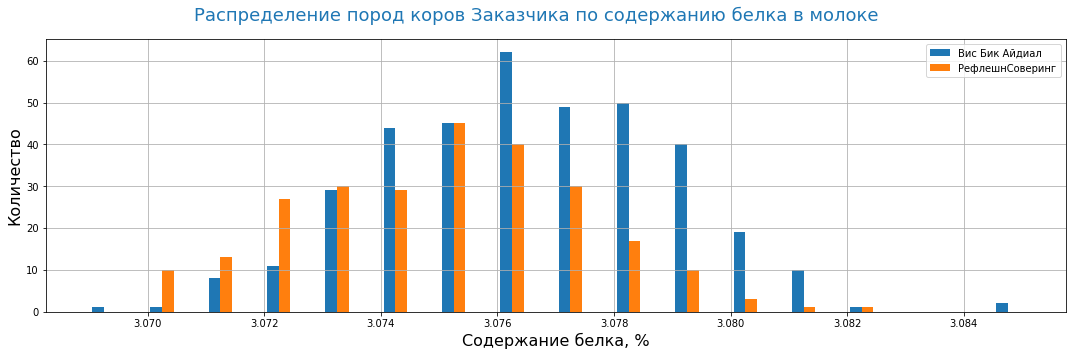

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,372.0,3.076274,0.002477,3.069,3.074,3.076,3.078,3.085,Probably NOT,0.000092
РефлешнСоверинг,256.0,3.074793,0.002403,3.070,3.073,3.075,3.076,3.082,Probably NOT,0.000432


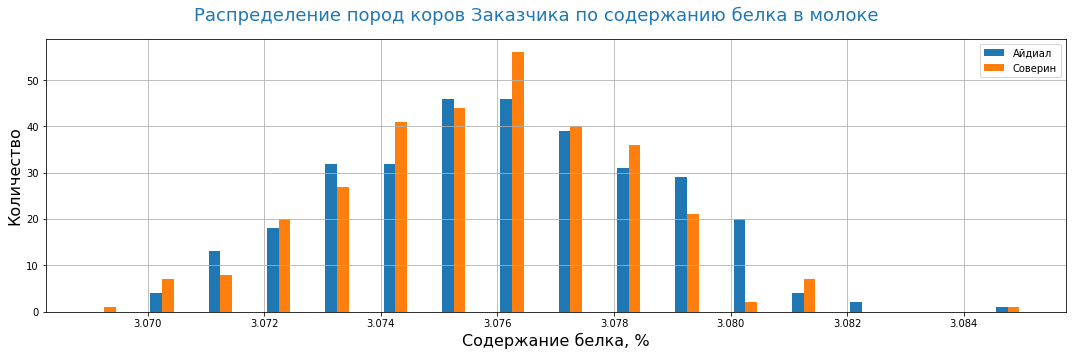

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,317.0,3.075817,0.002642,3.070,3.074,3.076,3.078,3.085,Probably NOT,0.000260
Соверин,311.0,3.075521,0.002451,3.069,3.074,3.076,3.077,3.085,Probably NOT,0.000247


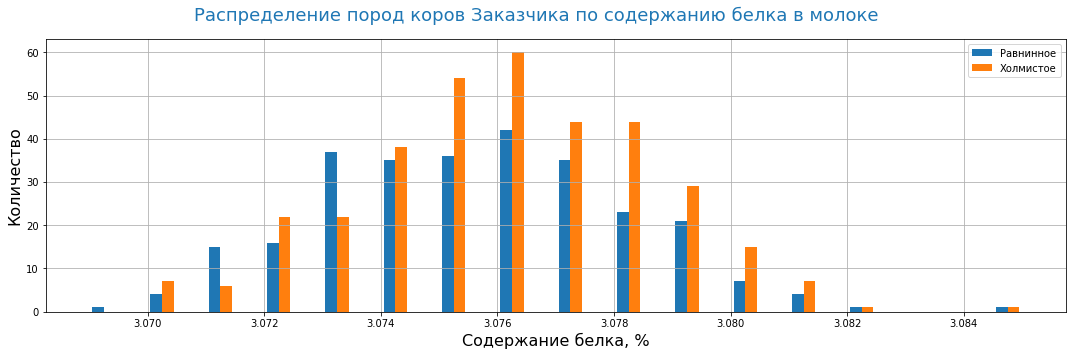

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,278.0,3.075353,0.002592,3.069,3.073,3.075,3.077,3.085,Probably NOT,0.000999
Холмистое,350.0,3.075923,0.002493,3.070,3.074,3.076,3.078,3.085,Probably NOT,0.000201


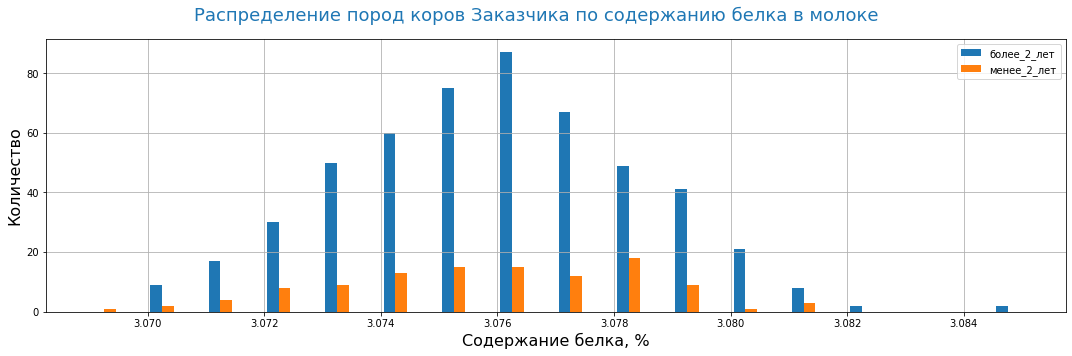

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,518.0,3.075687,0.002544,3.070,3.074,3.076,3.077,3.085,Probably NOT,0.000004
менее_2_лет,110.0,3.075591,0.002596,3.069,3.074,3.076,3.078,3.081,Probably NOT,0.037293


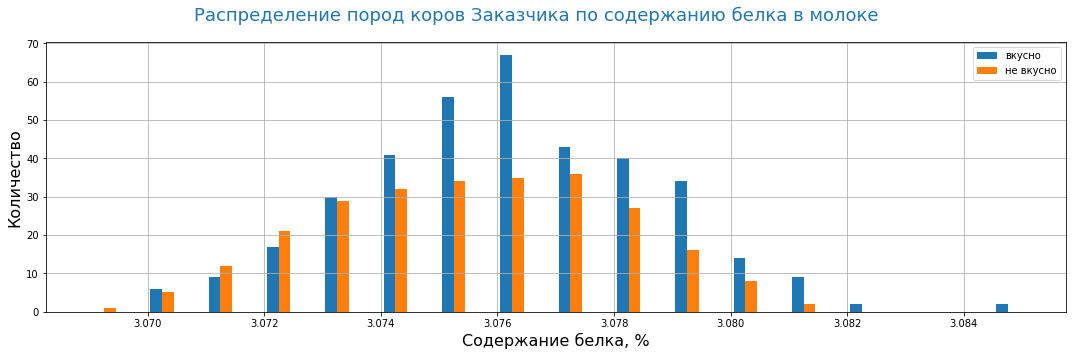

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Вкус молока,,,,,,,,,,
вкусно,370.0,3.075943,0.002547,3.070,3.074,3.076,3.078,3.085,Probably NOT,0.000116
не вкусно,258.0,3.075279,0.002511,3.069,3.073,3.075,3.077,3.081,Probably NOT,0.000487


In [40]:
for col, val in ferma_qual_cols.items():
    show_hist(
        ferma_main.pivot(columns=col, values="milk_protein"),
        "Распределение пород коров Заказчика по содержанию белка в молоке", 
        "Содержание белка, %", columns=val, 
        bins=32, stacked=False
    )

Для более точного анализа по данному параметру сравнение производится без отношения к общему количеству а фактическое, то есть значения располагаются не поверх другого как в предыдущих графиках, а накладываются одно на другое чтобы лучше заметить отличия в распределении.

Очень заметен сдвиг по содержанию белка в молоке по породе коровы - ВисБикАйдиал, которые в целом имеют большее содержание. Также заметно более резкое снижение количества по отцам коров породы Соверин при более высоких значениях содержания белка. 

По типу пастбища равнинное больше сдвинуто влево к более низкому содержанию белка, а холмистое имеет больше коров с высоким содержанием белка. 

По возрасту коров содержание белка в молоке имеет более равномерное распределение для коров моложе 2-х лет, для коров старше 2-х лет распределение содержания белка близкое к нормальному. 

По вкусу чуть выше количество коров с вкусным молоком при низком содержании белка и чуть ниже при высоком.

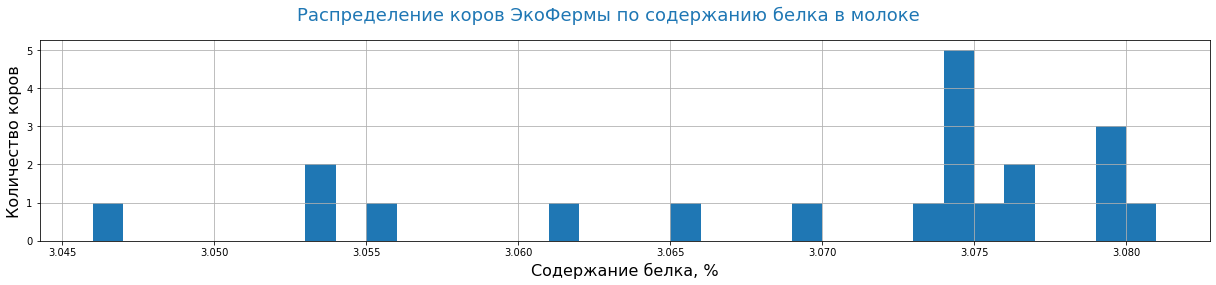

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Содержание белка, %",20.0,3.0695,0.010339,3.046,3.064,3.074,3.076,3.081,Probably NOT,0.003396


In [41]:
show_hist(cow_buy["current_milk_protein"], 
            "Распределение коров ЭкоФермы по содержанию белка в молоке", 
            "Содержание белка, %", "Количество коров", bins=35, figsize=(17, 4))

По содержанию белка в молоке коров ЭкоФермы заметно сильное смещение в сторону более низких значений по сравнению со стадом Заказчика. Большинство коров имеют содержание белка в молоке в пределах 3.075% и 3.080%, однако имеются выбросы ниже минимальных показателей стада Заказчика - 3.046-3.066 процентов. Возможно питание коров ЭкоФермы менее сбалансированное и отличается от опыта Заказчика.

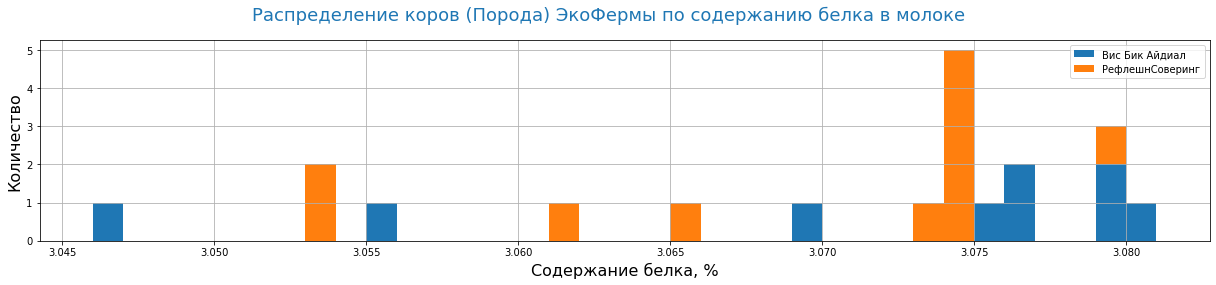

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,9.0,3.070667,0.012135,3.046,3.069,3.076,3.079,3.081,Probably NOT,0.014790
РефлешнСоверинг,11.0,3.068545,0.009114,3.053,3.063,3.074,3.074,3.079,Probably NOT,0.010146


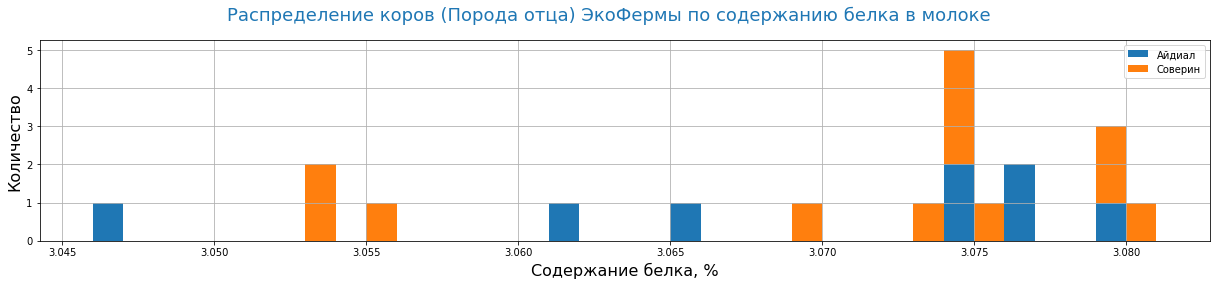

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,8.0,3.068875,0.011064,3.046,3.0640,3.074,3.076,3.079,Probably,0.056711
Соверин,12.0,3.069917,0.010308,3.053,3.0655,3.074,3.076,3.081,Probably NOT,0.010313


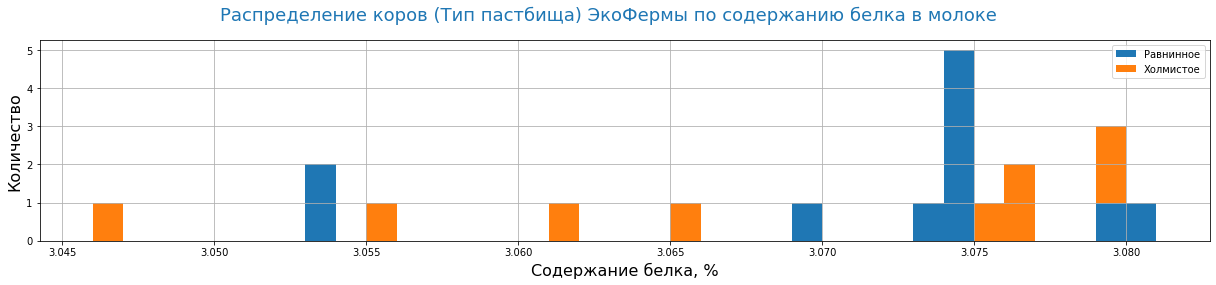

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,11.0,3.070727,0.009296,3.053,3.071,3.074,3.074,3.081,Probably NOT,0.002547
Холмистое,9.0,3.068000,0.011885,3.046,3.061,3.075,3.076,3.079,Probably,0.103261


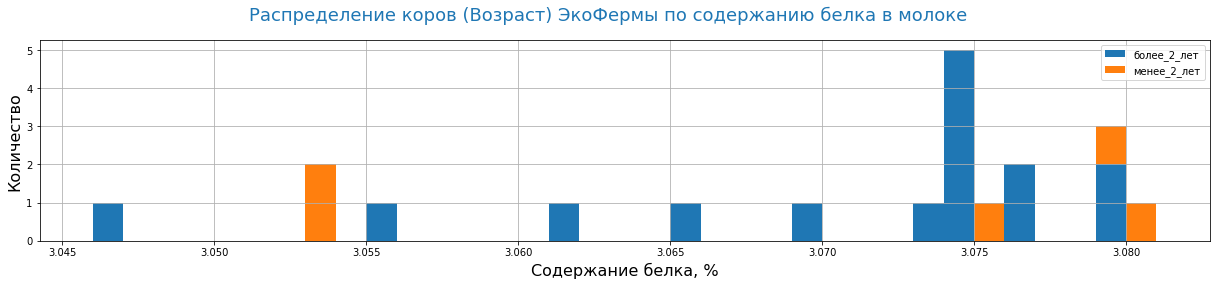

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,15.0,3.069933,0.009377,3.046,3.067,3.074,3.075,3.079,Probably NOT,0.004424
менее_2_лет,5.0,3.068200,0.014043,3.053,3.053,3.075,3.079,3.081,Probably,0.060912


In [42]:
for col, val in {
    k:v for k,v in ferma_qual_cols.items() if k != "milk_taste"
}.items():
    show_hist(
        cow_buy.pivot(columns=col, values="current_milk_protein"),
        f"Распределение коров ({val}) ЭкоФермы по содержанию белка в молоке", 
        "Содержание белка, %", columns=val, bins=35, figsize=(17, 4)
    )

По категориальным признакам коров ЭкоФермы нет заметных перекосов в зависимости от других характеристик.

### Годовой удой

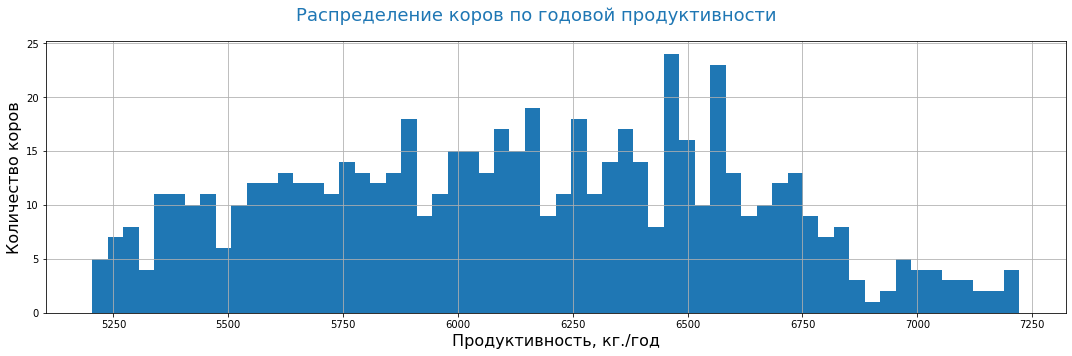

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
"Продуктивность, кг./год",628.0,6125.968153,475.857053,5204.0,5749.75,6132.5,6501.0,7222.0,Probably NOT,3.540204e-07


In [43]:
show_hist(ferma_main["milk_prod"], 
            "Распределение коров по годовой продуктивности", 
            "Продуктивность, кг./год", "Количество коров", bins=60)

По графику можно отметить, что продуктивность в стаде распределена достаточно равномерно, с двумя пиками в районе значений 6500 килограмм в год и заметным снижением по количеству коров между ними. Также заметно, что по продуктивности образуются группы, по которым наблюдается рост с последующим заметным снижением количества коров через каждые 200-250 килограмм продуктивности. При продуктивности выше 6750 килограмм в год заметно значительное снижение количества коров. Половина коров в стаде имеют продуктивность между 5750 и 6500 килограмм в год.

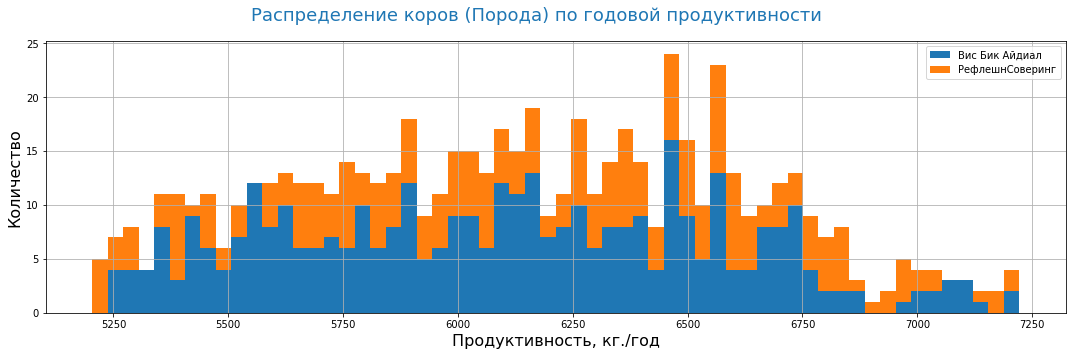

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода,,,,,,,,,,
Вис Бик Айдиал,372.0,6099.405914,462.472692,5242.0,5715.5,6112.0,6468.25,7222.0,Probably NOT,0.000038
РефлешнСоверинг,256.0,6164.566406,493.026392,5204.0,5771.0,6178.5,6559.25,7201.0,Probably NOT,0.000732


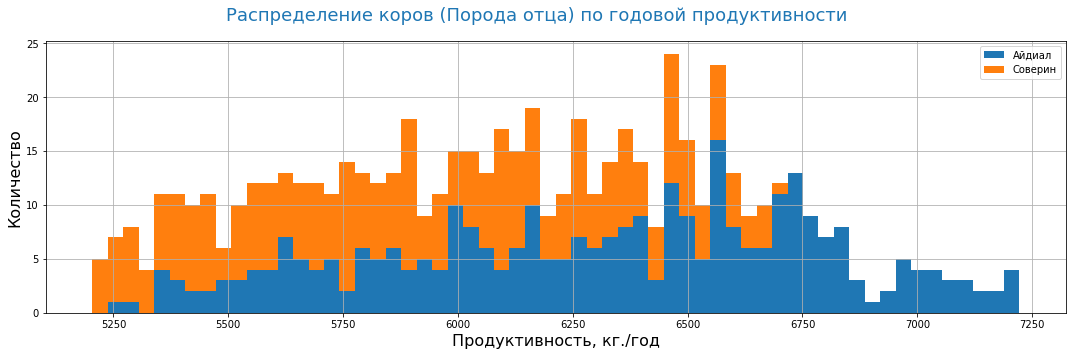

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Порода отца,,,,,,,,,,
Айдиал,317.0,6310.899054,468.358569,5242.0,5971.0,6370.0,6688.0,7222.0,Probably NOT,6.008720e-05
Соверин,311.0,5937.469453,404.684503,5204.0,5599.0,5919.0,6270.0,6701.0,Probably NOT,6.317877e-07


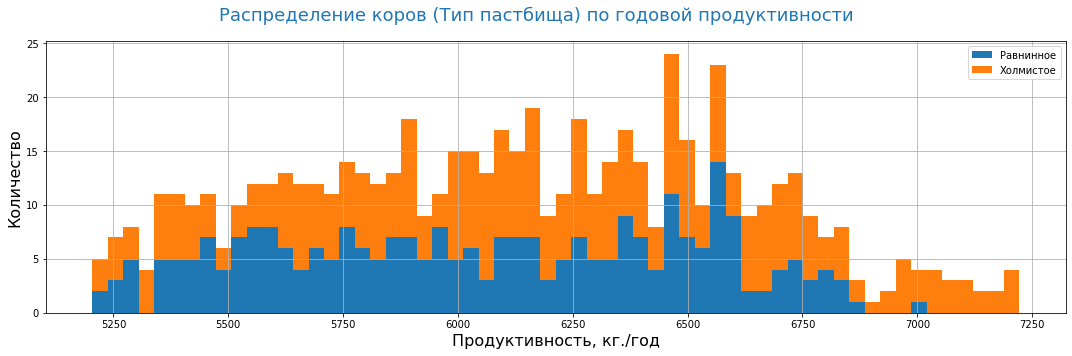

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Тип пастбища,,,,,,,,,,
Равнинное,278.0,6056.287770,443.163631,5213.0,5679.25,6061.0,6454.25,6991.0,Probably NOT,0.000002
Холмистое,350.0,6181.314286,493.960062,5204.0,5806.25,6171.0,6558.50,7222.0,Probably NOT,0.000470


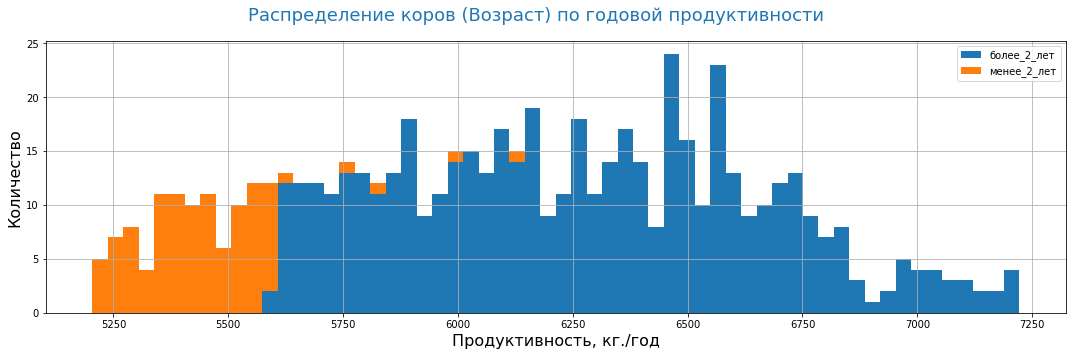

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Возраст,,,,,,,,,,
более_2_лет,518.0,6270.735521,387.427459,5601.0,5957.25,6267.0,6560.75,7222.0,Probably NOT,2.163686e-07
менее_2_лет,110.0,5444.245455,148.325404,5204.0,5343.00,5435.5,5534.50,6122.0,Probably NOT,1.224766e-06


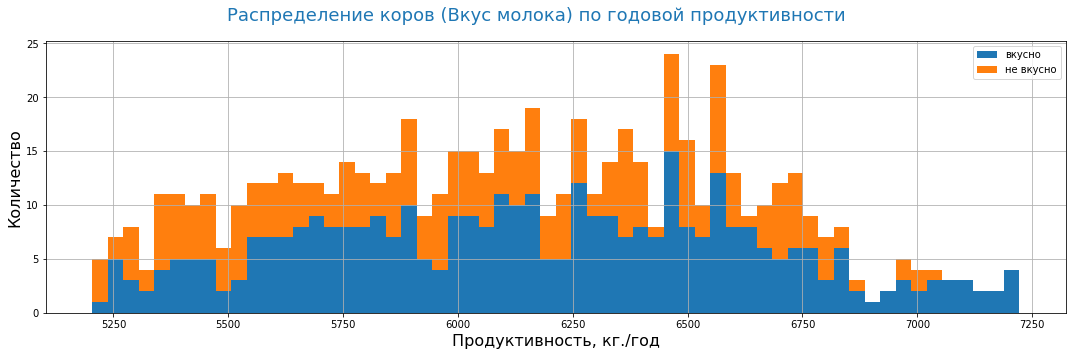

,count,mean,std,min,25%,50%,75%,max,Gaussian,p_value
Вкус молока,,,,,,,,,,
вкусно,370.0,6170.770270,475.047964,5204.0,5785.75,6166.0,6523.50,7222.0,Probably NOT,0.000620
не вкусно,258.0,6061.717054,470.522718,5207.0,5642.75,6061.5,6464.75,7052.0,Probably NOT,0.000013


In [44]:
for col, val in ferma_qual_cols.items():
    show_hist(
        ferma_main.pivot(columns=col, values="milk_prod"),
        f"Распределение коров ({val}) по годовой продуктивности", 
        "Продуктивность, кг./год", columns=val, bins=60
    )

Также заметен существенный сдвиг продуктивности по возрасту коровы, что является достатоно известным фактом - пик продуктивности коров приходится на возраст от 4-х до 7-ми лет. По породам отца также заметен менее выраженный сдвиг в сторону большей продуктивности для породы Айдиал. Самые высокие показатели продуктивности также относятся к холмистому типу пастбища. Остальные параметры распределены достаточно равномерно без явных перекосов.

### Промежуточные итоги

Проведен исследовательский анализ данных, по результатам которого можно отметить следующее:
1. Все параметры, кроме содержания белка в молоке коров Заказчика, не имеют нормального распределения - имеет место либо близкое к равномерному распределение, либо группировка в отдельные кластеры.
2. По быкам производителям выявлены следующие факты, которые стоит отметить:
    - Имеются дублирующиеся имена отцов коровы в стаде заказчика, имеющие разные породы и одинаковые имена - Барин и Соловчик породы Соверин, такой факт решено трактовать как наличие разных быков производителей с одним именем, либо нужно проверить исходные данные на наличие ошибок;
    - При сравнении с коровами ЭкоФермы выявлено дублирование имен быков производителей одной породы - Айдиал Буйный, Айдиал Геркулес, Соверин Барин и Соверин Соловчик. Так как других пересечений не наблюдается, есть вероятность, что стадо Заказчика и коровы ЭкоФермы могут иметь различных быков производителей имена и породы которых могут пересекаться, либо это одни и те же быки;
3. По характеристикам корма заметен очень сильный сдвиг по возрасту коровы Заказчика - для коров моложе 2-х лет корм предоставляется с заметно меньшими характеристиками ЭКЕ, СПО и по содержанию протеина.
4. По характеристикам молока можно отметить:
    - сдвиг характеристики содержания жиров в зависимости от возраста коровы;
    - небольшие отклонения по содержанию белка в зависимости от генетических особенностей - породы коровы и отица (Вис Бик Айдиал более жирное молоко), также по возрасту распределение более равномерное у молодых коров;
    - заметна более высокая жирность молока у коров ЭкоФермы, возможно питание коров отличается от методов кормления Заказчика.
5. По целевому параметру производительности (удой):
    - заметна гораздо меньшая производительность для коров моложе 2-х лет;
    - имеется небольшое преимущество по породе отца коровы Айдиал, которые показывают более высокий удой;
    - также более высокие показатели удоя показывают коровы с холмистым типом пастбища.
6. По целевому параметру вкуса молока можно отметить:
    - более высокое соотношение вкусного молока по холмистому типу пастбища;
    - более высокое соотношение вкусного молока у коров старше 2-х лет.

## Корреляционный анализ

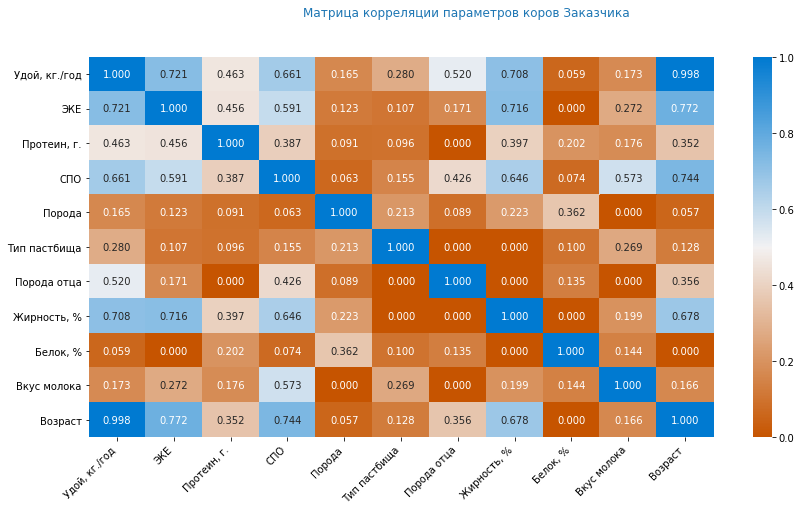

In [45]:
# Словарь расшифровки количественных признаков
ferma_quant_cols = {"milk_prod": "Удой, кг./год", "food_energy": "ЭКЕ", "food_protein": "Протеин, г.", 
                 "food_sugar_protein": "СПО", "milk_fat": "Жирность, %", "milk_protein": "Белок, %"}

# Функция вывода матрицы коэффициентов корреляции Фи
def show_heatmap(
    data, columns_rename, title, interval_cols, figsize = (14, 7), 
    annot=True, fmt=".3f"
):
    plt.figure(figsize=figsize)
    sns.heatmap(
        (
            data.rename(columns=columns_rename)
            .phik_matrix(interval_cols=interval_cols)
        ), 
        annot=annot, fmt=fmt,
        cmap=sns.diverging_palette(25, 250, s=100, l=50, as_cmap=True)
    )
    plt.suptitle(title, color="C0")
    plt.xticks(rotation=45, ha="right")
    plt.show() 

show_heatmap(
    ferma_main.drop(columns=["id", "dad_name"]), 
    {**ferma_qual_cols, **ferma_quant_cols},
    "Матрица корреляции параметров коров Заказчика",
    ferma_quant_cols.values()
)

По матрице корреляции коэффициента Фи можно отметить, что по удою коров наиболее высокая корреляция с параметром возраста коровы - 0.998. Между признаками отсутствует очень высокая корреляция 0.9 и более, соответственно мультиколлинеарности нет. Довольно высокая корреляция с параметрами ЭКЕ корма и жирностью молока - 0.721 и 0.708 соответственно. Между самими показателями ЭКЕ и жирность молока корреляция также достаточно высокая - 0.716. Также заметная корреляция удоя с показателями СПО корма и порода отца - 0.661 и 0.520 соответственно. Достаточно умеренная корреляция по количеству протеина в корме - 0.463. Остальные параметры показывают слабую корреляцию по шкале Чеддока.

По вкусу молока имеется заменая корреляция с параметром СПО корма, по остальным параметрам также слабая корреляция.

Стоит также отметить, что по параметру возраста коровы достаточно высокая корреляция с параметрами ЭКЕ и СПО корма - 0.722 и 0.744, а также заметная корреляция по жирности молока.

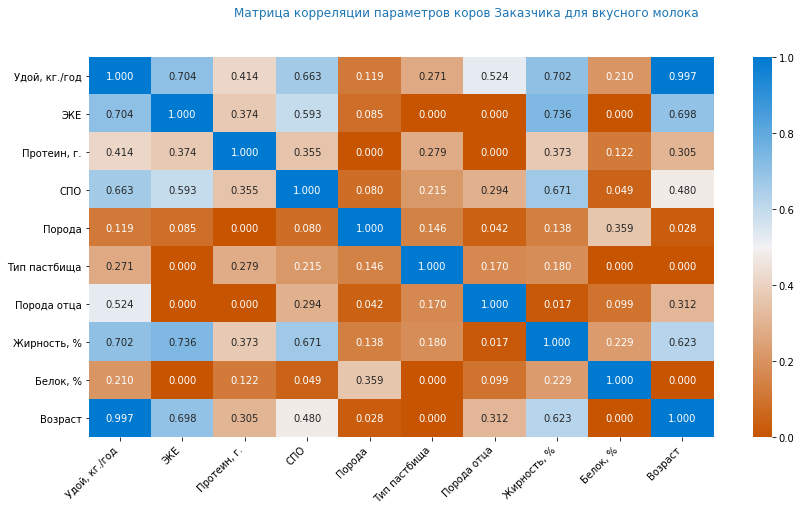

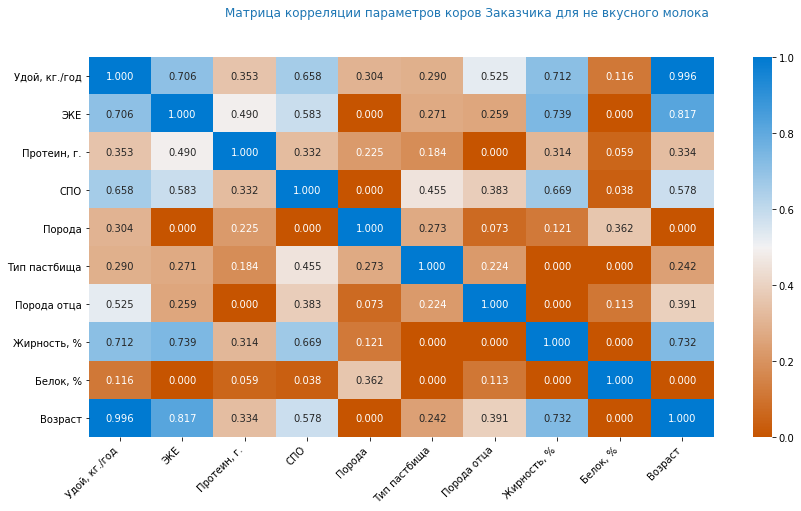

In [46]:
show_heatmap(
    ferma_main.query("milk_taste == 'вкусно'").drop(
        columns=["id", "dad_name", "milk_taste"]), 
    {**ferma_qual_cols, **ferma_quant_cols},
    "Матрица корреляции параметров коров Заказчика для вкусного молока",
    ferma_quant_cols.values()
)
show_heatmap(
    ferma_main.query("milk_taste == 'не вкусно'").drop(
        columns=["id", "dad_name", "milk_taste"]), 
    {**ferma_qual_cols, **ferma_quant_cols},
    "Матрица корреляции параметров коров Заказчика для не вкусного молока",
    ferma_quant_cols.values()
)

При сравнении матриц корреляции вкусного и невкусного молока можно заметить, что заметно более высока корреляция Протеина и ЭКЕ корма для невкусного молока. Для вкусного молока отсутствует заметно снижается корреляция по типу пастбища и породе отца с ЭКЕ корма, для невкусного также снижается корреляция но не с ЭКЕ корма а с жирностью молока.

In [47]:
# Функция вывода диаграммы рассеяния
def show_scatter(data: pd.DataFrame, x: str, y: str, title: str, xlabel: str, 
                 ylabel: str, by_columns: Optional[dict] = None, ncols: int = 2, ax = None,
                 figsize: tuple = (15, 20), alpha: float = 0.4, size: int = 3, noise=(0, 0)):
    data = data.copy()
    # Добавление дрожания для диаграммы рассеяния
    data[x] = data[x] + np.random.normal(0, noise[0], size=len(data))
    data[y] = data[y] + np.random.normal(0, noise[1], size=len(data))
    # если не указаны столбцы, то функция возвращает диаграмму по x и y
    if by_columns == None:
        ax = data.plot(kind="scatter", x=x, y=y, alpha=alpha, s=size, ax=ax)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax
    # если столбцы указаны, то возвращает диаграммы по всем указанным столбцам
    # разделяя по цвету значения из этих столбцов
    elif isinstance(by_columns, dict):
        i = 0
        fig, axes = plt.subplots(len(by_columns)//ncols+1, ncols, figsize=figsize)
        data.plot(kind="scatter", x=x, y=y, alpha=alpha, s=size, ax=axes[i//ncols, i%ncols],
                  xlabel=xlabel, ylabel=ylabel, title=f"{xlabel} - {ylabel}")
        for col, col_name in by_columns.items():
            i += 1
            col_values = list(data[col].unique())
            for val in col_values:
                data.query(f"{col} == '{val}'").plot(
                    kind="scatter", x=x, y=y, color="C" + str(col_values.index(val)), 
                    alpha=alpha, s=size, label=val,
                    ax=axes[i//ncols, i%ncols], title=f"{xlabel} - {ylabel} ({col_name})", 
                    xlabel=xlabel, ylabel=ylabel
                )
            axes[i//ncols, i%ncols].legend(title=col_name)
        fig.suptitle(title+"\n", size=18, color="C0")
        fig.tight_layout()
        return fig

### ЭКЕ корма

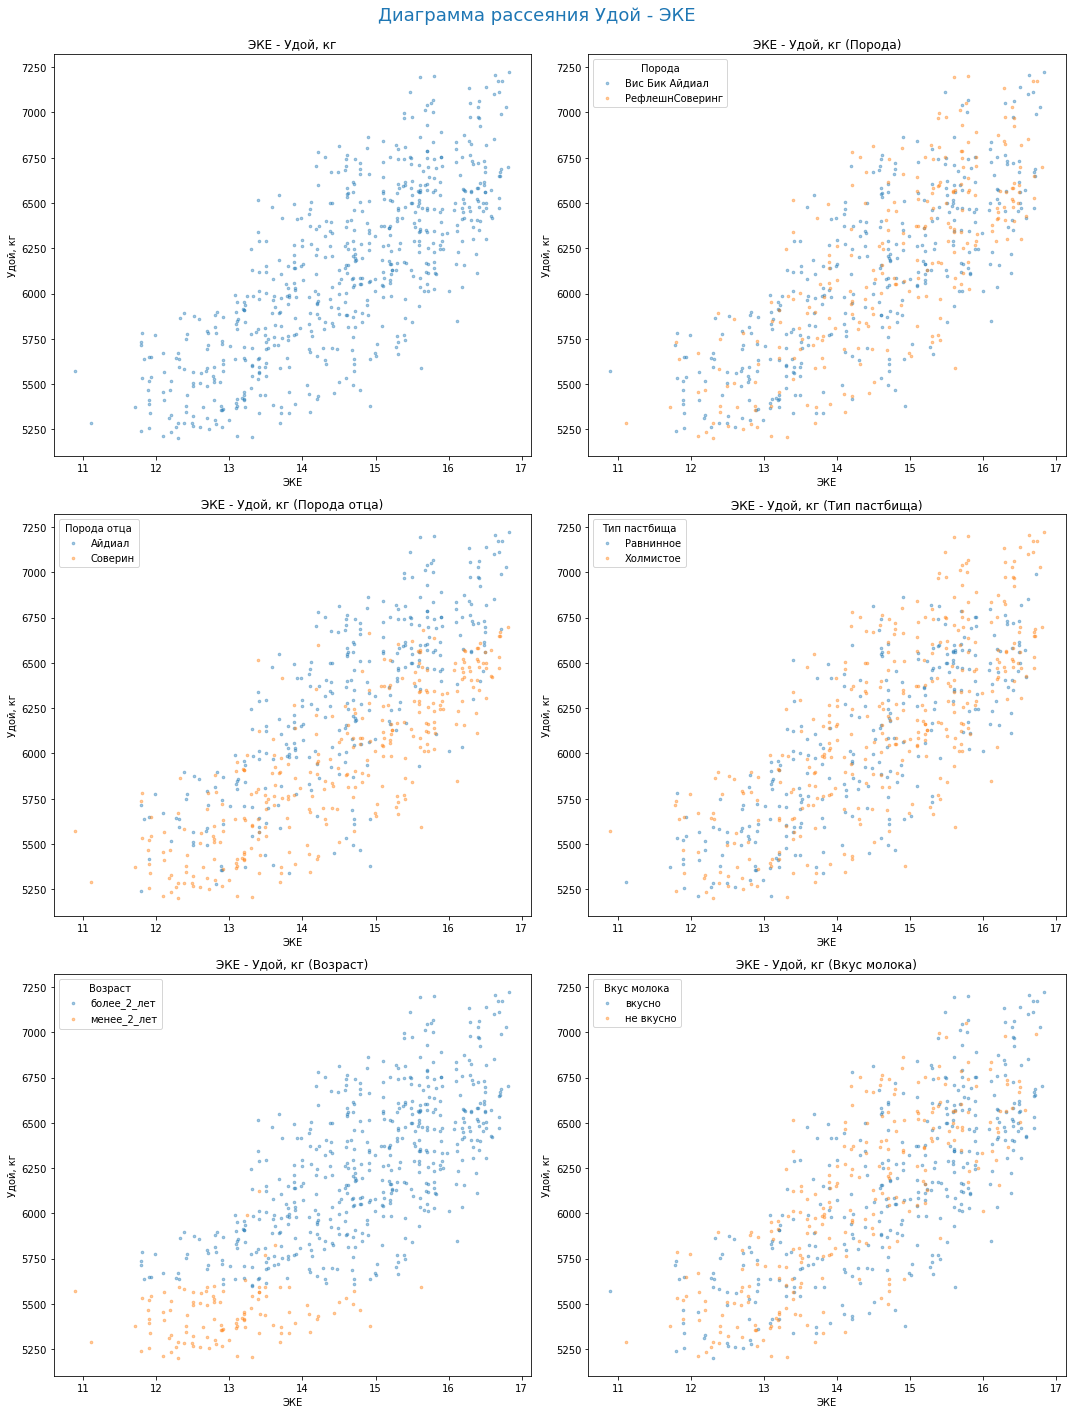

,"Удой, кг./год","Протеин, г.",СПО,"Жирность, %","Белок, %"
Корреляция ЭКЕ,0.77,0.38,0.74,0.69,-0.01


In [48]:
show_scatter(ferma_main, "food_energy", "milk_prod", "Диаграмма рассеяния Удой - ЭКЕ", 
             "ЭКЕ", "Удой, кг", ferma_qual_cols, noise=(0.015, 0), size=7)
plt.show()
(
    ferma_main.corr("spearman").loc["food_energy", :]
    .drop(["id", "food_energy"]).rename("Корреляция ЭКЕ")
    .to_frame().rename(ferma_quant_cols).T.style.format("{:.2f}")
)

В части ЭКЕ корма заметна достаточно хорошая корреляция с целевым параметром. Коэффициент корреляции Спирмена равен 0.77. Также высокая корреляци с СПО корма и жирностью молока. 

По графику рассеяния распределение имеет немного дугообразную форму. По породам отца заметна более линейная корреляция в разерезе каждого значения. Некоторая степерь изгиба заметна, но она кажется менее выраженной, особенно для породы Айдиал. Также заметны отклонения по параметрам возраста и типа пастбища. По возрасту заметно, что даже у коров моложе 2-х лет более высокий ЭКЕ практически не влияет на показатели годового удоя.

Очень сильно заметно разделение коров по возрасту - в среднем молодые коровы не доходят до производительности 5700 килограммов в год, значения выше встречаются в основном только у коров старше 2 лет. Также заметно, что в части удоя по параметру породы отца небольшое преимущество имеет порода Айдиал, а также по типу пастбища, где холмистое также имеет небольшое преимущество в верхних значениях удоя.

По вкусу молока заметно большее соотношение целевого значения показателя при более низком ЭКЕ.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Спасибо за табличку</font>
</div>

### Содержание жиров в молоке

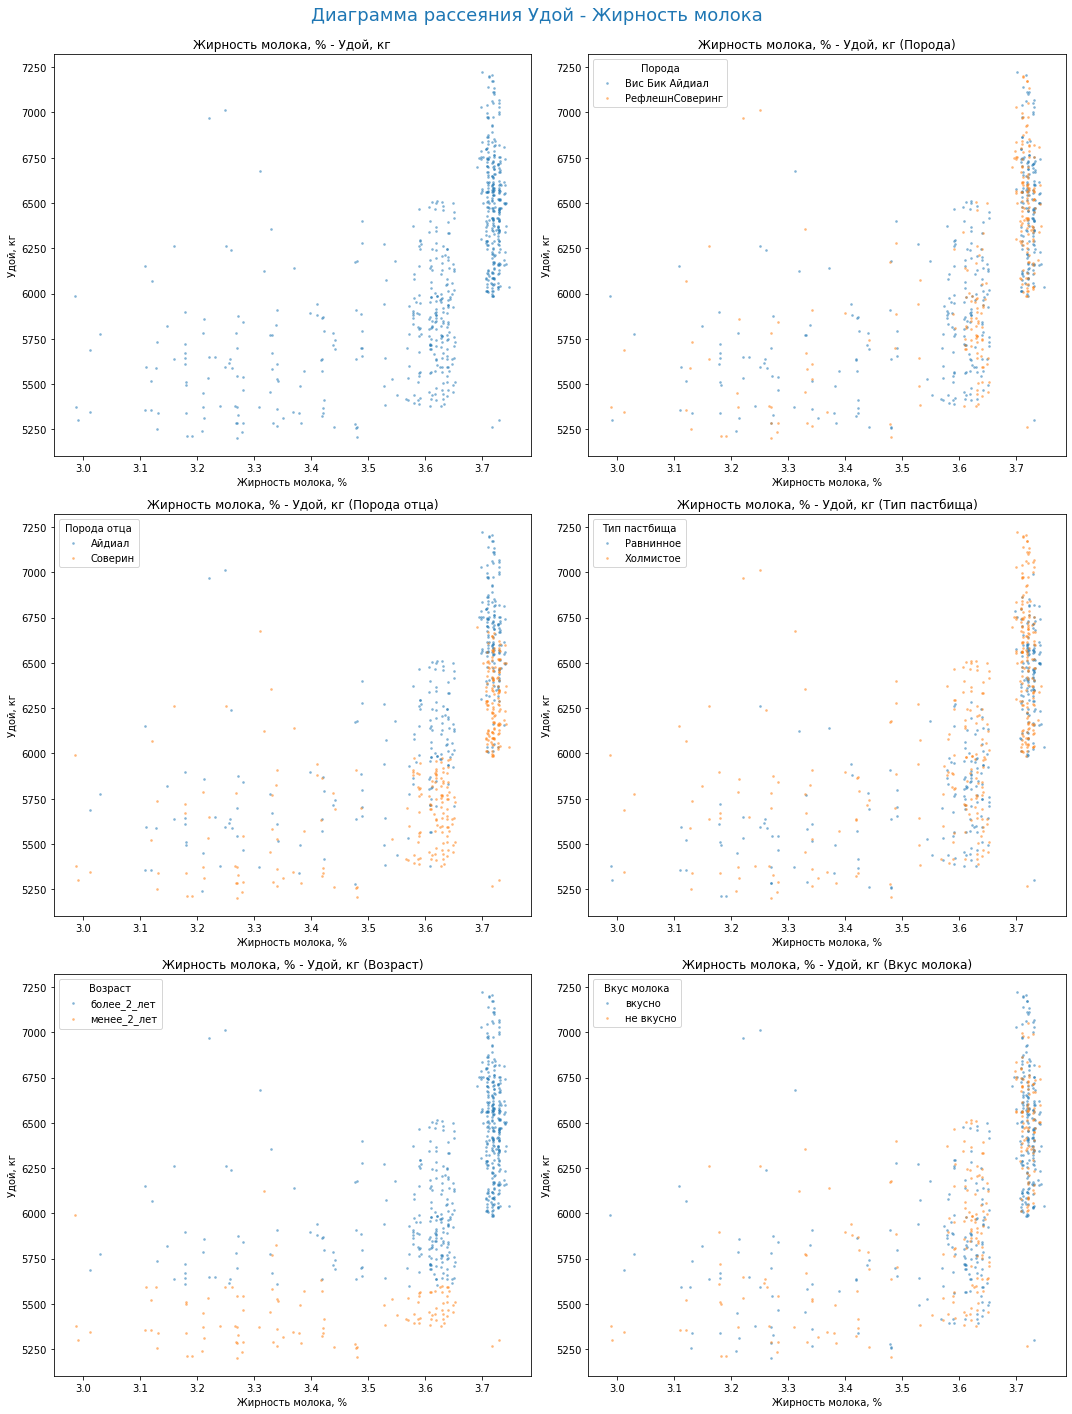

,"Удой, кг./год",ЭКЕ,"Протеин, г.",СПО,"Белок, %"
Корреляция содержания жиров,0.69,0.69,0.39,0.70,0.04


In [49]:
show_scatter(ferma_main, "milk_fat", "milk_prod", "Диаграмма рассеяния Удой - Жирность молока", 
             "Жирность молока, %", "Удой, кг", ferma_qual_cols, noise=(0.0015, 0))
plt.show()
(
    ferma_main.corr("spearman").loc["milk_fat", :]
    .drop(["id", "milk_fat"]).rename("Корреляция содержания жиров")
    .to_frame().rename(ferma_quant_cols).T.style.format("{:.2f}")
)

График рассеяния годового удоя и жирности молока разбит на несколько групп, на которых заметен довольно сильный разброс показателей удоя, особенно при низком содержании жиров, но в целом заметна тенденция к росту удоя по мере увеличения жирности молока. Коэффициент корреляции Спирмена равен 0.69.

По вкусу молока распределение достаточно равномерное по всем группам по содержанию жиров в молоке. Интерес представляет график рассеяния для жирности молока и ЭКЕ, которые имеют достаточно высокую корреляцию.

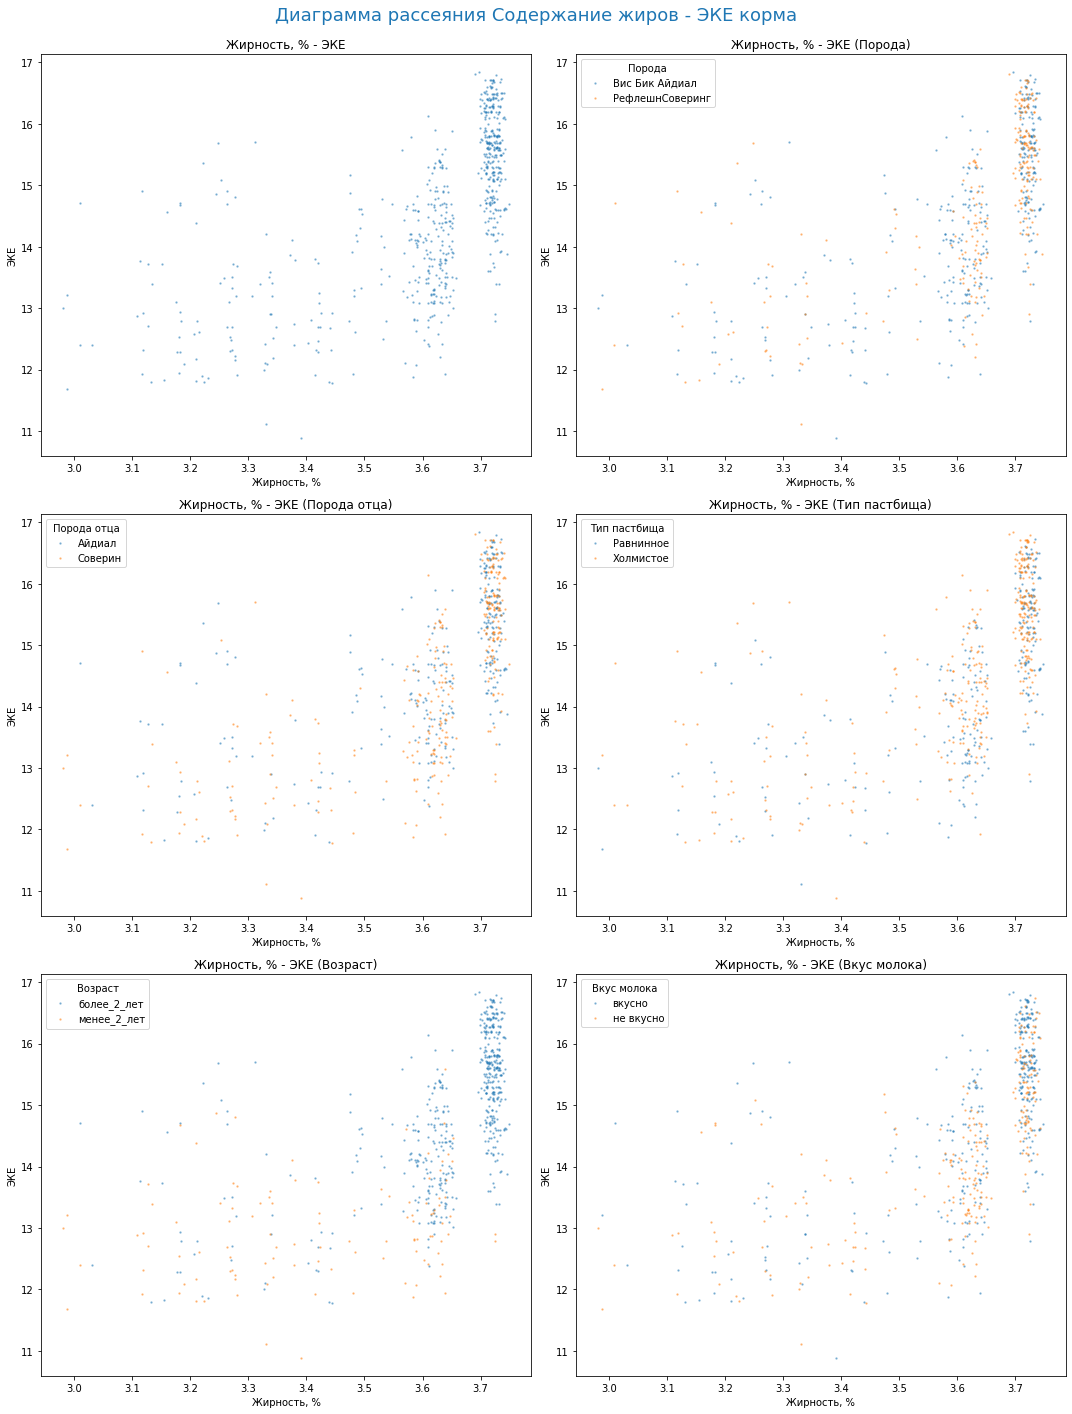

In [50]:
show_scatter(
    ferma_main, "milk_fat", "food_energy", "Диаграмма рассеяния Содержание жиров - ЭКЕ корма", 
   "Жирность, %",  "ЭКЕ", ferma_qual_cols, noise=(0.003, 0.02), size=2
);

Диаграмма рассеяния по жирности молока и ЭКЕ схожа с таковой по удою, однако заметен больший разброс значений ЭКЕ для коров с более низкой жирностью молока.

### СПО корма

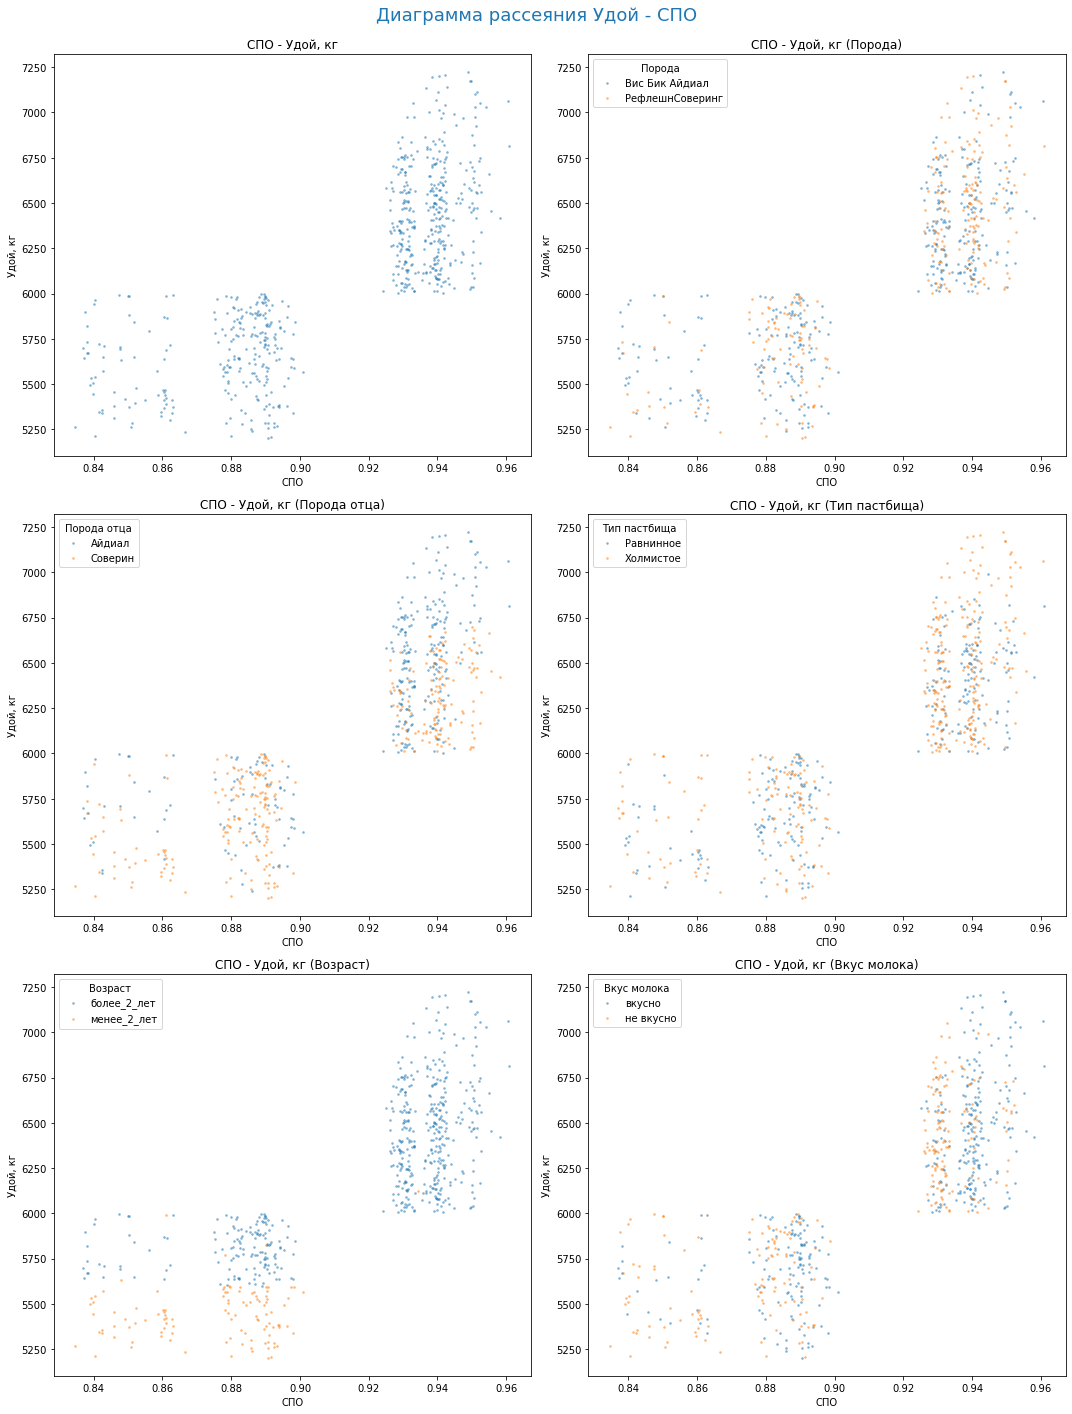

,"Удой, кг./год",ЭКЕ,"Протеин, г.","Жирность, %","Белок, %"
Корреляция СПО,0.79,0.74,0.49,0.70,0.11


In [51]:
show_scatter(ferma_main, "food_sugar_protein", "milk_prod", "Диаграмма рассеяния Удой - СПО", 
             "СПО", "Удой, кг", ferma_qual_cols, noise=(0.002, 0))
plt.show()
(
    ferma_main.corr("spearman").loc["food_sugar_protein", :]
    .drop(["id", "food_sugar_protein"]).rename("Корреляция СПО")
    .to_frame().rename(ferma_quant_cols).T.style.format("{:.2f}")
)

Диаграмма рассеивания между показателями СПО и Удой показывает, что по показателю СПО стадо можно разделить на 2 группы - все коровы, у которых СПО ниже 0.91 показывают производительность в основном до 6000 килограмм, а у которых СПО выше - в основном более 6000 килограмм в год. Коэффициент корреляции Спирмена показывает даже более высокие показатели корреляции между СПО и удоем - 0.79. Также имеется высокая корреляция с ЭКЕ корма и жирностью молока.

По вкусу молока заметно, что вкусное молоко встречается чаще при более высоких СПО.

### Содержание протеина в корме

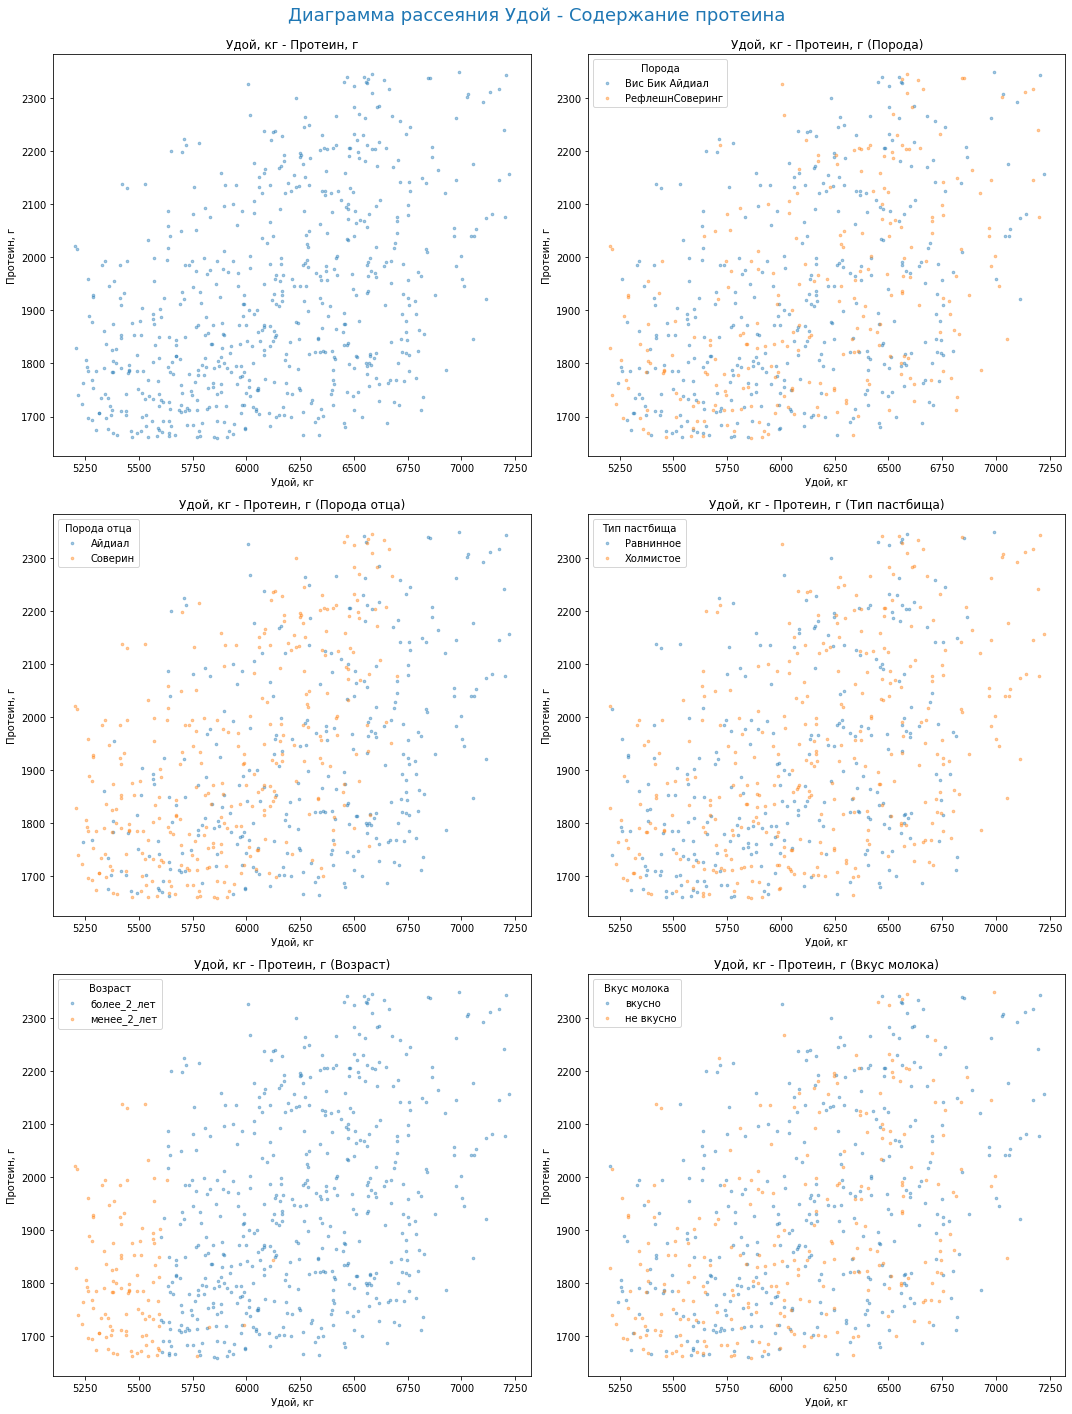

,"Удой, кг./год",ЭКЕ,СПО,"Жирность, %","Белок, %"
Корреляция протеина,0.45,0.39,0.45,0.36,0.23


In [52]:
show_scatter(ferma_main, "milk_prod", "food_protein", "Диаграмма рассеяния Удой - Содержание протеина", 
             "Удой, кг", "Протеин, г", ferma_qual_cols, size=7)
plt.show()
(
    ferma_main.corr().loc["food_protein", :]
    .drop(["id", "food_protein"]).rename("Корреляция протеина")
    .to_frame().rename(ferma_quant_cols).T.style.format("{:.2f}")
)

По графику рассеяния показывает хоть и близкое к линейному распределение но корреляция невысокая и имеется очень большой разброс по значениям. Имеются значения с довольно низким удоем и высоким протеином и наоборот. Также заметны отклонения по возрасту, типу пастбища и породе коров. Корреляция с другими параметрами в основном умеренная.

В разрезе вкуса молока диаграмма рассеяния параметров удоя и содержания протеина в корме показывает достаточно равномерное распределение.

### Содержание белков в молоке

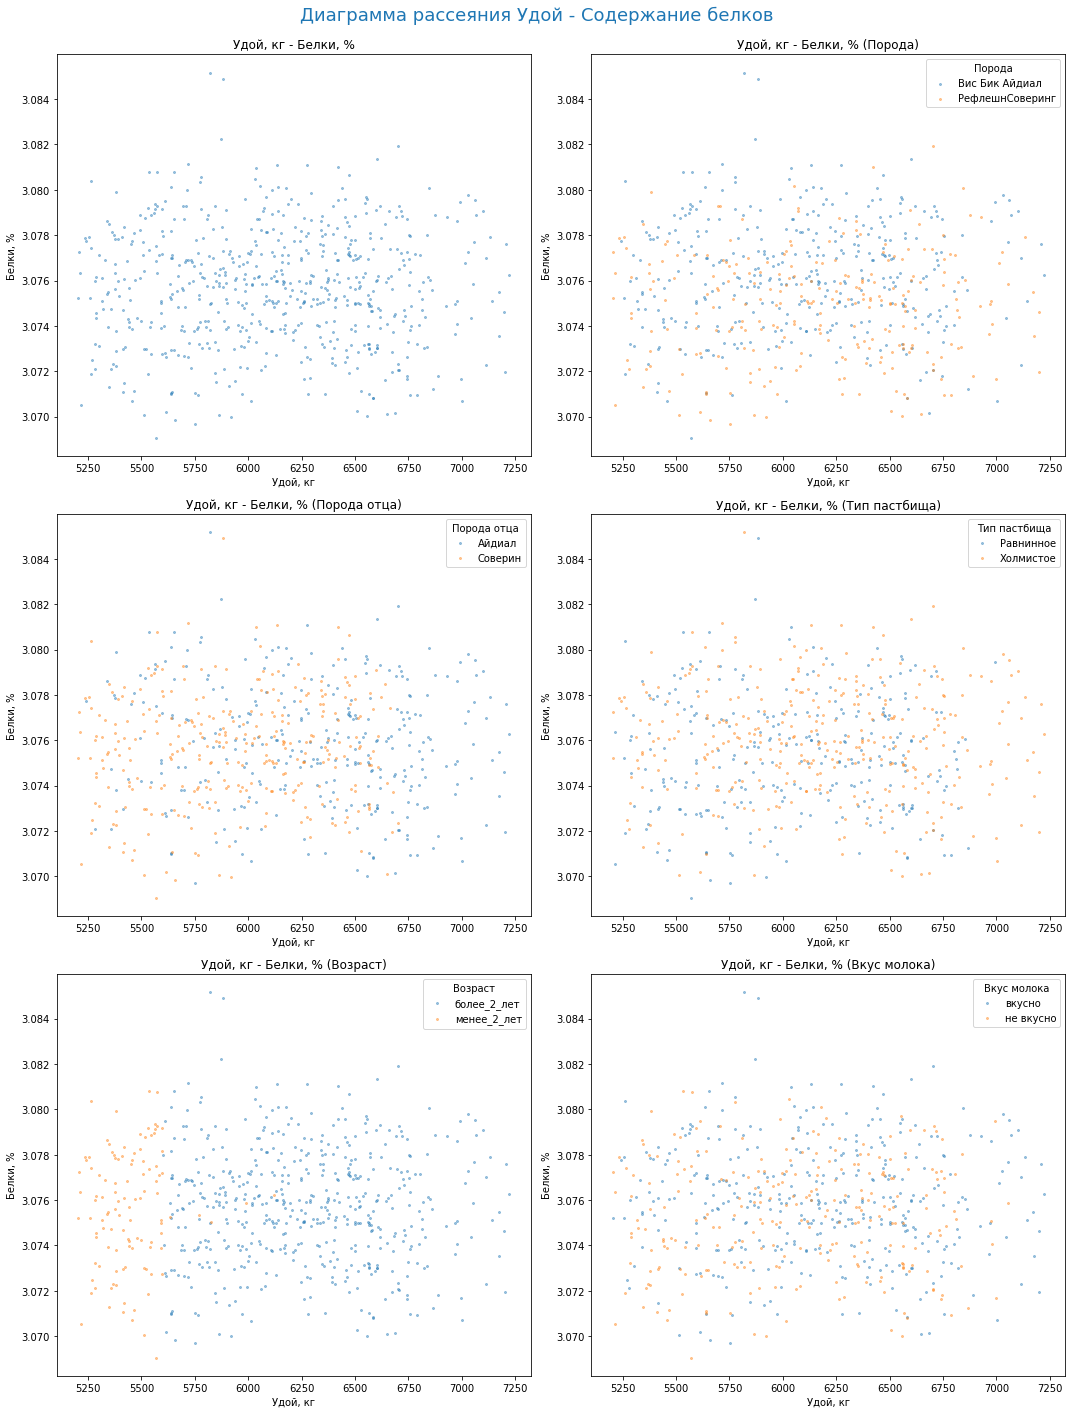

,"Удой, кг./год",ЭКЕ,"Протеин, г.",СПО,"Жирность, %"
Корреляция белков,-0.01,-0.01,0.23,0.11,0.04


In [53]:
show_scatter(ferma_main, "milk_prod", "milk_protein", "Диаграмма рассеяния Удой - Содержание белков", 
             "Удой, кг", "Белки, %", ferma_qual_cols, noise=(0, 0.00025), size=4)
plt.show()
(
    ferma_main.corr("spearman").loc["milk_protein", :]
    .drop(["id", "milk_protein"]).rename("Корреляция белков")
    .to_frame().rename(ferma_quant_cols).T.style.format("{:.2f}")
)

По количеству белков в молоке корреляция отсутствует. Распределение близкое к нормальному.

По вкусу молока наблюдается минимальный сдвиг в сторону меньшего удоя и низких показаний белков.

### Промежуточные итоги

Проведен корреляционный анализ, по результатам которого можно отметить следующее:
1. Наиболее высокая корреляция с годовой производительностью коровы показывает признак возвраста коровы, практически отсутствует удой более 6000 килограмм в год у коров моложе 2-х лет.
2. Достаточно высокая корреляция и близкая к линейной зависимости у признака ЭКЕ корма. 
3. Умеренная корреляция по признаку содержания протеина в корме и зависимость можно также отнести к линейной, но с очень большим разбросом значений.
4. Остальные признаки сложно назвать линейными.
5. По признаку СПО корма заметно разделение на две группы значений, где значения СПО ниже 0.91 показывают удой в основном меньше 6000 килограмм, а значения выше в основном более 6000 килограмм в год. Также можно отметить, что коэффициент корреляции Спирмена для данного признака выше, чем для ЭКЕ корма.

В части мультиколлинеарности между признаками можно отметить следующее:
5. Полная коллинеарность между признаками отсуствует, однако имеется высокая корреляция между ЭКЕ корма и жирностью молока.
6. Также имеется умеренная корреляция между ЭКЕ и СПО корма по коэффициенту Фи, при этом коэффициент корреляции Спирмена между этими значениями говорит о высокой взаимосвязи.

По результатам исследовательского и корреляционного анализа для дальнейшего прогнозирования удоя коров на перспективу, вне зависимости от текущего возраста, считаю целесообразным отказаться от использования параметра возраста коровы и исключить молодых коров из выборки.

## Обучение модели линейной регрессии

Для прогнозирования удоя коров будет применяться модель линейной регрессии. Целевой признак для обучения модели линейной регрессии является удой - производительность коровы за год. На удой влияют в первую очередь индивидуальные особенности коровы, в нашем случае это ее порода и порода отца. В зависимости от удоя формируется рацион для коровы, так как необходимо обеспечить достаточное восполнение питательными веществами организмом коровы, чтобы она не себя хорошо чувствовала, реже болела и больше приносила молока. Также от питания зависит содержание белков, жиров и протеина в молоке. Соответственно состав молока также зависит от характеристик корма, хотя на него также могут влиять и индивидуальные особенности коровы. Также по результатам анализа установлено, что на характеристики удоя влияет тип пастбища, которое также является одной из характеристик питания коров.

По результатам корреляционного анализа наибольшая корреляция целевого признака с возрастом коровы, так как коровы моложе 2-х лет показывают заметно более низкий удой по сравнению с другими коровами. Решено исключить молодых коров из выборки для обучения модели на взрослых коровах, чтобы спрогнозировать удой независимо от возраста коровы, так сказать на перспективу.

In [54]:
# Создаем исходные выборки для обучения модели без молодых коров
X = ferma_main.query("age == 'более_2_лет'").drop(["id", "milk_prod"], axis=1)
y = ferma_main.query("age == 'более_2_лет'")["milk_prod"]

print(f"Общий размер исходной выборки: {len(X)}")

Общий размер исходной выборки: 518


Количество коров исходной выборки стада Заказчика сократилось на 17.5% до 518. 

Для удобства определим функции кодирования признаков и вывода графиков анализа остатков.

In [149]:
# Функция для кодирования категориальных и масштабирования количественных признаков
def data_transform(
    X_data: pd.DataFrame, y_data: pd.DataFrame, qual_columns: list, 
    quant_columns: list, random_state = RANDOM_STATE,
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore'),
    scaler = StandardScaler(), encoder_y = None, invert_y=False
):
    print(f"Количество параметров в исходной выборке: {X_data.shape[1]}")
    print(f"Количество параметров для модели: {len(qual_columns)+len(quant_columns)}")
    print(f"Количество данных в исходной выборке: {X_data.shape[0]}")
    # Разделяем выборки на тренировочную и валидационную
    X_trn, X_tst, y_trn, y_tst = train_test_split(
        X_data, y_data, random_state=random_state
    )
    print(f"Количество данных в тренировочной выборке: \
{X_trn.shape[0]} ({(X_trn.shape[0]/X_data.shape[0]):.0%})")
    
    # Кодируем и масштабируем признаки тренировочной выборки
    X_trn = pd.concat(
        [
            pd.DataFrame(
                encoder.fit_transform(X_trn[qual_columns]),
                columns=encoder.get_feature_names()
            ),
            pd.DataFrame(
                scaler.fit_transform(X_trn[quant_columns]),
                columns=quant_columns
            )        
        ],
        axis=1
    )
    
    # Кодируем и масштабируем признаки валидационной выборки
    X_tst = pd.concat(
        [
            pd.DataFrame(
                encoder.transform(X_tst[qual_columns]),
                columns=encoder.get_feature_names()
            ),
            pd.DataFrame(
                scaler.transform(X_tst[quant_columns]),
                columns=quant_columns
            )        
        ],
        axis=1
    )
    print(f"Количество параметров после кодирования и масштабирования: {X_trn.shape[1]}")
    
    # Преобразуем y, если выборка целевая для логической регрессии
    if encoder_y != None:
        y_trn = pd.Series(encoder_y.fit_transform(y_trn), index=y_trn.index)
        y_tst = pd.Series(encoder_y.transform(y_tst), index=y_tst.index)
        print("Преобразована целевая выборка:", end=" ")
        for i in range(len(encoder_y.classes_)):
            print(f"{encoder_y.classes_[i]} = {i}",end="; ")
        print()

    # Возвращаем выборки
    return X_trn, X_tst, y_trn, y_tst

# Функция вывода графиков анализа остатков
def show_residuals(values, predictions, figsize=(15, 7), bins=50):
    residuals = values - predictions
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("Графики анализа остатков", size=18, color="C0")
    axes[0].hist(residuals, bins=bins)
    axes[0].set_title("Гистограмма распределения остатков", color="C0")
    axes[0].set_xlabel("Остатки")
    axes[1].scatter(x=predictions, y=residuals, s=2)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии', color="C0")
    plt.show()
    display(residuals.describe().rename("Описание").to_frame().T.style.format("{:.2f}"))
    print(f"Коэффициент детерминации R² - {r2_score(values, predictions):.4f}")

### Модель 1

По признакам достаточно высокая корреляция с ЭКЕ корма, при этом наблюдается близкая к линейной зависимость. Также достаточно высокая корреляция целевого признака с жирностью молока, однако отсутствует линейная зависимость и имеется высокая корреляция с признаком ЭКЕ корма. Немного ниже корреляция c СПО корма, однако данный признак не имеет линейной зависимости с удоем, а сгруппирован в два отдельных кластера по удою, которые имеют довольно широкий разброс по каждому значению СПО. Содержание протеина в корме имеет достаточно сильный разброс по значениям и не очень высокую корреляцию, однако распределение ближе к линейному. Также оказывают влияние категориальные признаки порода отца, тип пастбища и порода коровы. Остальные признаки в целом имеют зависимость от характеристик корма и напрямую не влияют на удой.

На основании вышеуказанных выводов построим модель линейной регрессии, в качестве признаков для обучения модели будем использовать количественные признаки ЭКЕ корма и содержание протеина, а также категориальные признаки порода отца, тип пастбища и порода коровы.

Количество параметров в исходной выборке: 11
Количество параметров для модели: 5
Количество данных в исходной выборке: 518
Количество данных в тренировочной выборке: 388 (75%)
Количество параметров после кодирования и масштабирования: 8


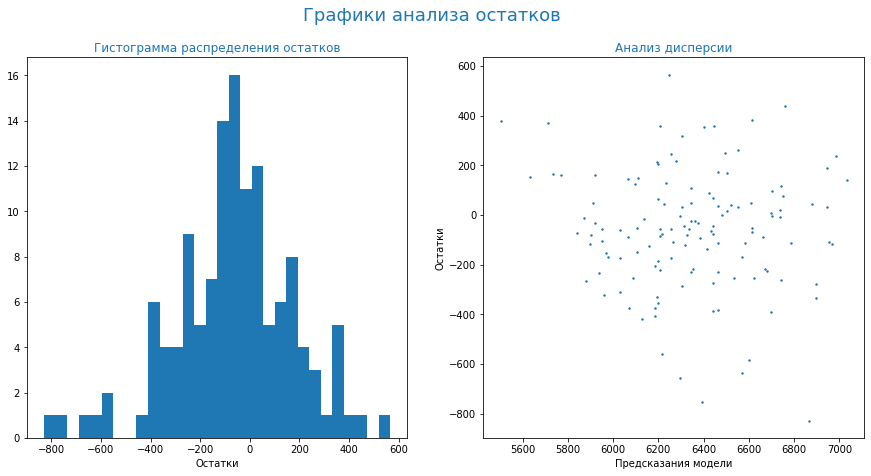

,count,mean,std,min,25%,50%,75%,max
Описание,130.00,-63.45,239.95,-828.00,-213.00,-56.50,73.50,565.00


Коэффициент детерминации R² - 0.5790


In [72]:
# Определяем необходимые столбцы категориальных и количественных признаков
quant_cols_ln1 = ["food_energy", "food_protein"]
qual_cols_ln1 = ["dad_breed", "landscape", "breed"]

# Получаем тренировочную и валидационную выборки
encoder_ln1 = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler_ln1 = StandardScaler()
X_train, X_test, y_train, y_test = data_transform(X, y, qual_cols_ln1, quant_cols_ln1,
                                                  encoder=encoder_ln1, 
                                                  scaler=scaler_ln1)

# Обучаем модель линейной регрессии
model_ln1 = LinearRegression()
model_ln1.fit(X_train, y_train)
# Получаем прогноз модели на валидационной выборке
predictions = pd.DataFrame(model_ln1.predict(X_test), columns=["ln1"])
predictions.index = y_test.index

# Выводим графики анализа остатков
show_residuals(y_test, predictions["ln1"], bins=30)

Значение коэффициента R² модели составляет 0.579, достаточно низкое значение. Гистограмма распределения остатков близка к нормальной с небольшим смещением в отрицательную сторону, имеются некоторые всплески значений. Среднее значение -63.45 килограмм в год, медиана -56.50, что показывает смещение вправо. Это говорит о том, что модель в среднем завышает предсказанные значения относительно истинных. Разброс остатков от -828 до 565 килограмм в год. Также можно заметить, что на самых низких предсказаниях модели до 5800 килограмм/год остатки чаще положительные, соответственно предсказания ниже фактических значений. При более высоких прогнозных значениях дисперсия остатков более равномерная. Лучше провести дополнительные исследования.

### Модель 2

При проведении корреляционного анализа было отмечено, что по СПО корма выделяются в две группы по удою - при значениях СПО менее 0.91 удой ниже 6000 литров, при более высоких значениях СПО удой выше 6000 литров. Также параметры ЭКЕ и Удой имеют связь отличную от линейной и ближе к графику степенной функции (парабола). Попробуем изменить признак ЭКЕ на его квадрат, а также количественный признак СПО заменить категориальным по границе значения 0.91 и включить в модель.

Количество параметров в исходной выборке: 13
Количество параметров для модели: 6
Количество данных в исходной выборке: 518
Количество данных в тренировочной выборке: 388 (75%)
Количество параметров после кодирования и масштабирования: 10


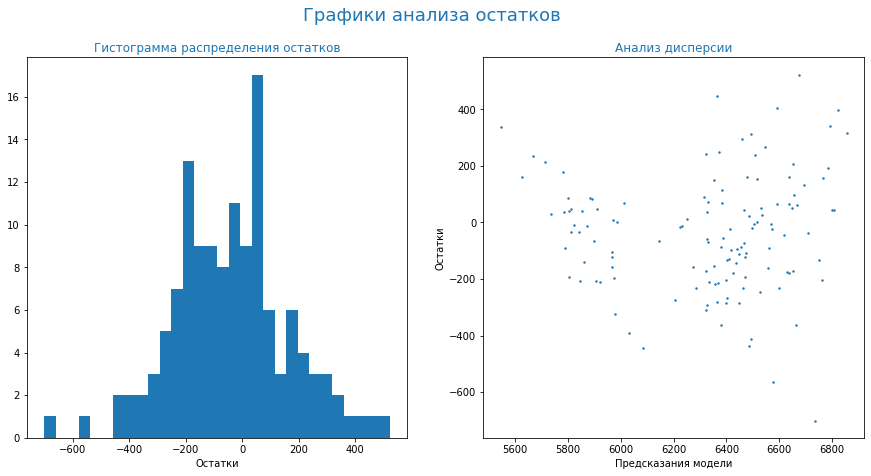

,count,mean,std,min,25%,50%,75%,max
Описание,130.00,-39.44,205.95,-700.21,-177.90,-34.24,69.00,522.99


Коэффициент детерминации R² - 0.6995


In [74]:
# Добавление ЭКЕ в квадрате
n = 2
X["food_energy_pwr"] = X["food_energy"].apply(lambda x: x**n)
# Добавление категориального признака СПО
X["food_sugar_protein_qual"] = X["food_sugar_protein"].apply(lambda x: 0 if x < 0.91 else 1)

# Определяем необходимые столбцы категориальных и количественных признаков
qual_cols_ln2 = ["dad_breed", "landscape", "breed",
                  "food_sugar_protein_qual"]
quant_cols_ln2 = ["food_energy_pwr", "food_protein"]

# Получаем тренировочную и валидационную выборки
encoder_ln2 = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler_ln2 = StandardScaler()
X_train, X_test, y_train, y_test = data_transform(X, y, qual_cols_ln2, 
                                                  quant_cols_ln2,
                                                  encoder=encoder_ln2,
                                                  scaler=scaler_ln2)

# Обучаем модель линейной регрессии
model_ln2 = LinearRegression()
model_ln2.fit(X_train, y_train)
# Получаем предсказания модели на валидационной выборке
predictions["ln2"] = model_ln2.predict(X_test)

# Выводим графики анализа остатков
show_residuals(y_test, predictions["ln2"], bins=30)

Коэффициент детерминации R² вырос до значения 0.6995 при добавлени дополнительных параметров. Гистограмма распределения показывает сужение разброса остатков до значений между -700.21 и 522.99 килограмм в год. Имеются 2 отрыва, которые сильно завышают предсказания. График немного сдвинулся вправо. Заметно непостоянство остатков - занижение прогноза сохранилось до предсказаний значения 5700, после этого заметен переход к более завышенным оценкам до значений немного порядка 6000-6100 килограмм в год. Также заметна большая дисперсия при более высоких значениях прогноза. По графику заметна бимодальность в районе -200 килограмм и ближе к 0.

### Модель 3

В процессе проведения исследовательского анализа данных было принято, что вероятнее всего отцы коровы в стаде Заказчика и ЭкоФермы являются различными животными, так как в большинстве случаев их породы не совпадают. Несмотря на это, попробуем оценить влияние отцов на производительность коров в стаде Заказчика.

Количество параметров в исходной выборке: 13
Количество параметров для модели: 7
Количество данных в исходной выборке: 518
Количество данных в тренировочной выборке: 388 (75%)
Количество параметров после кодирования и масштабирования: 14


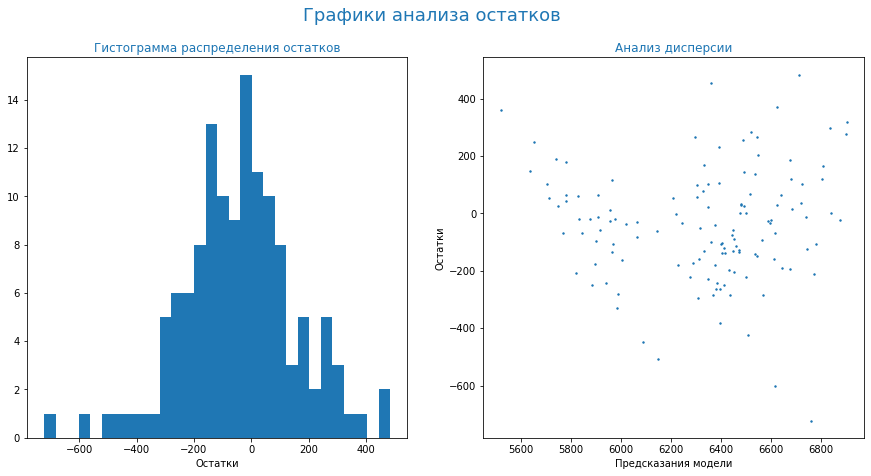

,count,mean,std,min,25%,50%,75%,max
Описание,130.00,-41.52,197.96,-722.00,-157.50,-35.00,62.50,484.00


Коэффициент детерминации R² - 0.7204


In [75]:
# Формируем перечень уникальных быков производителей Заказчика
# X["dad_breed_name"] = X["dad_breed"] + " " + X["dad_name"]
# Код выше вынужден не применять, так как выдает ошибку при прогнозировании модели
# на итоговой выборке ЭкоФермы, так как появляются неизвестные категории.
# Буду применять отдельно породу и имя быка

# Определяем необходимые столбцы категориальных и количественных признаков
qual_cols_ln3 = ["landscape", "dad_breed", "breed", 
                 "food_sugar_protein_qual", "dad_name"]
quant_cols_ln3 = ["food_energy_pwr", "food_protein"]

# Получаем тренировочную и валидационную выборки
encoder_ln3 = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler_ln3 = StandardScaler()
X_train, X_test, y_train, y_test = data_transform(X, y, qual_cols_ln3, 
                                                  quant_cols_ln3,
                                                  encoder=encoder_ln3,
                                                  scaler=scaler_ln3)

# Обучаем модель линейной регрессии
model_ln3 = LinearRegression()
model_ln3.fit(X_train, y_train)
# Получаем предсказания модели на валидационной выборке
predictions["ln3"] = model_ln3.predict(X_test)

# Выводим графики анализа остатков
show_residuals(y_test, predictions["ln3"], bins=30)

По 3-й модели коэффициент детерминации вырос до 0.7204, также среднее значение остатков сдвинулось влево, что говорит о более завышенных значениях прогноза. Максимальное значение остатков снизилось до 484, а минимальное отклонение увеличилось до -722. Бимодальность сохраняется, но пик сдвинулся влево ближе к нулевому значению.

График дисперсии остатков сохраняет тенденцию на переход от заниженных к завышенным предсказаниям в правой части до значения 6100, с последующим увеличением разброса дисперсии по мере увеличения предсказанных значений удоя.

### Выбор модели

In [76]:
metrics = pd.DataFrame()
for (col_name,col_data) in predictions.iteritems():
    metrics[col_name] = pd.Series(
        {
            "MSE": mean_squared_error(y_test, col_data),
            "RMSE": mean_squared_error(y_test, col_data, squared=False),
            "MAE": mean_absolute_error(y_test, col_data),
            "R²": r2_score(y_test, col_data)
        }
    )
metrics

,ln1,ln2,ln3
MSE,61159.538462,43645.861378,40609.944231
RMSE,247.304546,208.915919,201.519091
MAE,187.446154,162.826766,154.557692
R²,0.578957,0.699527,0.720427


При сравнении трех моделей заметно постепенное улучшение показателей по мере добавления признаков в модель. Добавление СПО как категориальный признак, а также приведение к более линейному распределению параметра ЭКЕ улучшает качество модели. Добавление быков производителей в модель привносит дополнительные улучшения в предсказании. Таким образом, если в стаде ЭкоФермы быки производители пересекаются с быками производителями Заказчика, то лучше будет использовать третью модель, если же нет, то лучше использовать вторую модель. 

Для определения доверительного интервала прогноза примем, что фактическое значение входит в этот интервал с вероятностью 95%.

In [77]:
intervals = pd.concat([
    (y_test - predictions["ln2"]).describe([0.025, 0.975]).rename(
        "Доверительный интервал модели 2:"
    ).to_frame().T[["2.5%", "97.5%"]],
    (y_test - predictions["ln3"]).describe([0.025, 0.975]).rename(
        "Доверительный интервал модели 3:"
    ).to_frame().T[["2.5%", "97.5%"]]
    ])
intervals["min"] = intervals["97.5%"] + 6000
display(intervals.style.format("{:.2f}"))

,2.5%,97.5%,min
Доверительный интервал модели 2:,-430.65,385.26,6385.26
Доверительный интервал модели 3:,-444.49,352.44,6352.44


В соответствии с доверительным интервалом фактический удой коров:
1. По модели 2 с вероятностью 95% будет в пределах от 385.26 килограмм ниже предсказанного предсказанного до 430.65 килограмм в год выше. Лучше выбирать коров, предсказанное значение удоя которых выше 6385.26 килограмм в год.
2. По модели 3 с вероятностью 95% будет в пределах от 352.44 килограмм ниже предсказанного до 444.49 килограмм в год выше предсказанного. Лучше выбирать коров, предсказанное значение удоя которых выше 6352.44 килограмм в год.

### Прогнозирование удоя коров ЭкоФермы

Очевидно, что кормление коров Заказчика очень сильно зависит от возраста, соответственно определим средние значения корма для коров ЭкоФермы по средним параметрам Заказчика в разрезе возраста коровы. При этом Заказчик планирует увеличить показатели корма на 5% для новых коров. Добавим недостающие параметры для прогнозирования.

In [81]:
# Определяем медианные значения корма по возрасту коровы + 5%
food_median = ferma_main[["food_energy", "food_protein", "food_sugar_protein"]].median() * 1.05

# Будем использовать отдельную переменную для добавления дополнительных параметров
X_test = cow_buy.drop(columns=["current_milk_fat", "current_milk_protein"])

# Добавим медианные значения параметров корма
for (col_name, col_data) in food_median.iteritems():
    X_test[col_name] = col_data

# Добавим измененные параметры для ЭКЕ и СПО
X_test["food_energy_pwr"] = X_test["food_energy"] ** n
X_test["food_sugar_protein_qual"] = X_test["food_sugar_protein"].apply(lambda x: 0 if x < 0.91 else 1)

# не получилось использовать следующий код, выдает ошибку о неизвестных категориях
#cow_buy["dad_breed_name"] = cow_buy["dad_breed"] + " " + cow_buy["dad_name"]
# считаю не совсем корректным использовать одинаковые имена как отдельные категории для разных пород

print(f"Общий размер исходной выборки {X_test.shape[0]} коров")

display(X_test.sample(5))

Общий размер исходной выборки 20 коров


,breed,landscape,dad_breed,dad_name,age,food_energy,food_protein,food_sugar_protein,food_energy_pwr,food_sugar_protein_qual
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,более_2_лет,15.435,1982.4,0.9765,238.239225,1
2,РефлешнСоверинг,Равнинное,Соверин,Барин,более_2_лет,15.435,1982.4,0.9765,238.239225,1
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,более_2_лет,15.435,1982.4,0.9765,238.239225,1
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,более_2_лет,15.435,1982.4,0.9765,238.239225,1
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,менее_2_лет,15.435,1982.4,0.9765,238.239225,1


Оценим результаты 2-й модели:

In [82]:
# Предсказание второй модели
X_test_result = pd.concat(
    [
        pd.DataFrame(
            encoder_ln2.transform(X_test[qual_cols_ln2]),
            columns=encoder_ln2.get_feature_names()
        ),
        pd.DataFrame(
            scaler_ln2.transform(X_test[quant_cols_ln2]),
            columns=quant_cols_ln2
        )        
    ],
    axis=1
)
result1 = cow_buy.copy()
result1["result"] = model_ln2.predict(X_test_result)
result1["match"] = result1["result"].apply(
    lambda x: True if x > intervals["min"].values[0] else False
)

display(result1.query("match == True").drop(columns="match"))
print(f"Общее количество коров с удоем более 6000 кг/год: {result1['match'].sum()}")

,breed,landscape,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,result
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.000223
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6593.629537
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6555.535363
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.000223
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6593.629537
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,6581.000223
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,6593.629537
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6555.535363


Общее количество коров с удоем более 6000 кг/год: 8


В случае, если быки производители Заказчика и ЭкоФермы являются разными животными, лучше применить модель 2. По предсказаниям данной модели наиболее подходящими по критерию удоя коровы более 6000 килограмм в год являются 8 коров, представленных в списке выше. Стоит отметить, что встречаются коровы менее 2-х лет, которые первое время не будут показывать высоких результатов удоя, данный прогноз для Заказчика на перспективу.

In [83]:
# Предсказание третей модели
X_test_three = pd.concat(
    [
        pd.DataFrame(
            encoder_ln3.transform(X_test[qual_cols_ln3]),
            columns=encoder_ln3.get_feature_names()
        ),
        pd.DataFrame(
            scaler_ln3.transform(X_test[quant_cols_ln3]),
            columns=quant_cols_ln3
        )        
    ],
    axis=1
)
result2 = cow_buy.copy()
result2["result"] = model_ln3.predict(X_test_three)
result2["match"] = result2["result"].apply(
    lambda x: True if x > intervals["min"].values[1] else False
)

display(result2.query("match == True"))
print(f"Общее количество коров с удоем более 6000 кг/год: {result2['match'].sum()}")

,breed,landscape,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,result,match
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6653.5,True
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6540.5,True
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6625.5,True
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6555.5,True
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6626.5,True
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6653.5,True
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6540.5,True
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6625.5,True
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6352.5,True
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6626.5,True


Общее количество коров с удоем более 6000 кг/год: 16


В случае, если у коров Заказчика и ЭкоФермы встречаются одни и те же быки производители с уникальными сочетаниями имени и породы, то прогноз модели 3 позволяет увеличить количество коров, удой которых превышает 6000 килограмм в год до 16-ти. Коровы менее 2-х лет встречаются чаще, которые сразу не будут показывать высокие удои.

### Промежуточные итоги

Проведено обучение 3-х моделей линейной регрессии для прогнозирования годовой производительности коров. Модели обучались только на взрослых коровах, так как показатели удоя у коров менее 2-х лет в основном не превышают 6000 килограмм в год, вследствие чего мы модель отклонит всех коров моложе 2-х лет. Таким образом Заказчик может отказаться от перспективных молодых коров.

В моделях использовались различные признаки исходной выборки:
1. Модель 1 была обучена на исходной выборке с применением категориальных признаков породы отца, типу пастбища и породы коровы, а также количественных признаков ЭКЕ корма и содержание протеина в корме.
2. Модель 2 была обучена на аналогичных признаках, кроме ЭКЕ корма, которое было приведено к более линейному виду путем возведения в квадрат, а также добавлен признак СПО корма в виде категориального, разделение которого произведено по значению 0.91.
3. Модель 3 была обучена на выборке модели 2, дополнительно в которую был включен признак имени отца коров.

Проведен анализ моделей:
1. По результатам анализа моделей было установлено, что наиболее подходящей моделью для прогнозирования удоя коров является модель 3, но только в том случае, когда имеются одни и те же быки производители в стаде Заказчика и в списке на приобретение. Также не должно быть отличающихся имен быков производителей в списке для прогнозирование удоя, так как их не было в тренировочной выборке.
2. В случае, если быки производители различаются, то лучше выбрать модель 2 для прогнозирования.
3. Определены доверительные интервалы для двух моделей.

По 2-м моделям произведено прогнозирование удоя:
1. По модели 2 определены 8 коров, удой которых с вероятностью 97.5% превышает 6000 килограмм в год.
2. По модели 3 определены 16 коров, удой которых с вероятностью 97.5% превышает 6000 килограмм в год.

## Обучение модели логистической регрессии

В целях прогнозирования вкуса молока по личным критериям Заказчика будет применяться модель логистической регрессии. Применение признаков характеристик молока по стаду Заказчика проблематично, так как в тестовой выборке ЭкоФермы данные показатели основаны на текущем подходе к кормлению ЭкоФермы и не могут отразить изменения в подходе кормления Заказчика, соответственно ориентироваться на текущие показатели необходимо с осторожностью. Также характеристики молока зависят от характеристик корма и индивидуальных особенностей коров, очень высокая корреляция отмечена между жирностью молока и такими показателями как ЭКЕ и СПО корма. 

Таким образом, целевым для модели логистической регрессии является вкус молока. Признаки для модели логистической регрессии выберем все, кроме жирности молока, так как этот показатель сильно коррелирует с ЭКЕ и СПО корма и вероятно изменится при смене подхода к кормлению. Содержание белков в молоке имеют достаточно слабую корреляцию с другими параметрами и может быть использовано в модели.

In [141]:
# Функция вывода матрицы ошибок и метрик
def show_lg_metrics(y_true, y_pred, invert=False):
    if invert:
        y_true = 1 - y_true
        y_pred = 1 - y_pred
    sns.heatmap(
        confusion_matrix(y_true, y_pred),
        annot=True, fmt="d", cmap="Blues_r"
    )
    plt.suptitle("Матрица ошибок", size=16, color="C0")
    plt.ylabel("Реальные значения", color="C0")
    plt.yticks([0.5, 1.5], ["не вкусно", "вкусно"], va="center")
    plt.xlabel("Прогнозные значения", color="C0")
    plt.xticks([0.5, 1.5], ["не вкусно", "вкусно"])
    plt.show()
    print(f"Точность модели - {accuracy_score(y_true, y_pred):.3f}")
    print(f"Метрика Recall - {recall_score(y_true, y_pred):.3f}")
    print(f"Метрика Precision - {precision_score(y_true, y_pred):.3f}")

### Обучение модели

Количество параметров в исходной выборке: 13
Количество параметров для модели: 7
Количество данных в исходной выборке: 518
Количество данных в тренировочной выборке: 388 (75%)
Количество параметров после кодирования и масштабирования: 10
Преобразована целевая выборка: вкусно = 0; не вкусно = 1; 


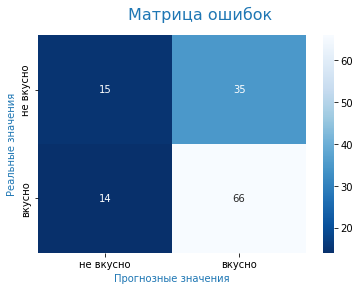

Точность модели - 0.623
Метрика Recall - 0.825
Метрика Precision - 0.653


In [150]:
# Изменение целевого признака для логистической регрессии
y = ferma_main.query("age == 'более_2_лет'")["milk_taste"]

# Определение необходимых категориальных и количественных признаков
qual_cols_lg1 = ["dad_breed", "landscape", "breed"]
quant_cols_lg1 = ["food_energy", "food_sugar_protein", 
                  "food_protein", "milk_protein"]

# Получение тренировочной и валидационной выборок
encoder_lg1 = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler_lg1 = StandardScaler()
encoder_ylg1 = LabelEncoder()
X_train, X_test, y_train, y_test = data_transform(X, y, qual_cols_lg1, 
                                                  quant_cols_lg1,
                                                  encoder=encoder_lg1,
                                                  scaler=scaler_lg1,
                                                  encoder_y=encoder_ylg1)
# Обучение модели логистической регрессии
model_lg1 = LogisticRegression().fit(X_train, y_train)

# Предсказание модели на валидационной выборке
show_lg_metrics(y_test, model_lg1.predict(X_test), invert=True)
y_proba_lg1 = model_lg1.predict_proba(X_test)

Модель логистической регрессии показывает невысокий результат, ошибки составляют 37.7% по валидационной выборке. Метрика Recall показывает достаточно высокое значение, только 17.5% вкусного молока определены неверно. Метрика Precision наоборот показывает, что 34.7% положительных предсказаний выполнены неверно. В целом по матрице ошибок заметно, что в большинстве случаев модель оценивает молоко коров как вкусное. 

Также необходимо рассмотреть влияние отцов коров, на случай совпадения быков производителей в стаде Заказчика и ЭкоФермы.

Количество параметров в исходной выборке: 13
Количество параметров для модели: 8
Количество данных в исходной выборке: 518
Количество данных в тренировочной выборке: 388 (75%)
Количество параметров после кодирования и масштабирования: 14
Преобразована целевая выборка: вкусно = 0; не вкусно = 1; 


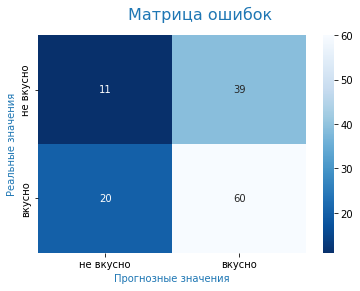

Точность модели - 0.546
Метрика Recall - 0.750
Метрика Precision - 0.606


In [129]:
# Определение необходимых категориальных и количественных признаков
qual_cols_lg2 = ["dad_breed", "landscape", "breed", "dad_name"]
quant_cols_lg2 = ["food_energy", "food_sugar_protein", 
                  "food_protein", "milk_protein"]

# Получение тренировочной и валидационной выборок
encoder_lg2 = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler_lg2 = StandardScaler()
encoder_ylg2 = LabelEncoder()
X_train, X_test, y_train, y_test = data_transform(X, y, qual_cols_lg2, 
                                                  quant_cols_lg2,
                                                  encoder=encoder_lg2,
                                                  scaler=scaler_lg2,
                                                  encoder_y=encoder_ylg2)
# Обучение модели логистической регрессии
model_lg2 = LogisticRegression().fit(X_train, y_train)

# Предсказание модели на валидационной выборке
show_lg_metrics(y_test, model_lg2.predict(X_test), invert=True)
y_proba_lg2 = model_lg2.predict_proba(X_test)

После добавления быков производителей в модель снизились все метрики - точность модели до 0.546, Recall до 0.75, Precision до 0.606. Это говорит о том, что увеличились ошибки как первого так и второго рода.

In [172]:
# Функция для поиска порога классификации
def get_thold(
    y_true, y_proba, func, up=True, invert=False, start=0.5, bins=50, ndigits=2
):
    if invert:
        y_true = 1 - y_true
        y_proba = y_proba[:,0]
    else:
        y_proba = y_proba[:,1]
    # Аргумент up устанавливает в какую сторону требуется изменение порога
    if up:
        thold = y_proba.max()
    # При up == False движение проверяются значения на понижение порога
    else:
        thold = y_proba.min()
    # Определение списка порогов для проверки
    tholds = [round(i, ndigits) for i in np.linspace(
        start, thold, num=bins, endpoint=False
    )]
    # Переводим y_proba в Series
    if not isinstance(y_proba, pd.Series):
        y_proba = pd.Series(y_proba, index=y_true.index)
    # Определяем достижение функцией значения 1
    for i in tholds:
        result = y_proba.apply(lambda x: 0 if x < i else 1)
        if func(y_true, result) == 1:
            if invert:
                result = 1 - result
            return i, result
    # Если значение не достигнуто возвращаем конечное значение
    result = y_proba.apply(lambda x: 0 if x < thold else 1)
    if invert:
        result = 1 - result
    return thold, result

Необходимо произвести настройку порогов классификации для минимизации ошибки первого рода (False Positive), чтобы невкусное молоко не определялось как вкусное. Для этого нам нужно увеличить порог классификации для логистической модели для максимизации метрики Precision.

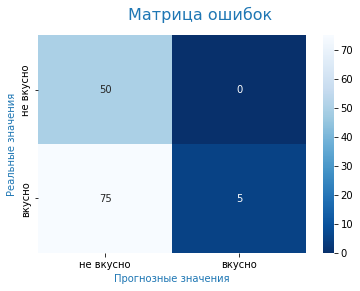

Точность модели - 0.423
Метрика Recall - 0.062
Метрика Precision - 1.000

Порог классификации: 0.82


In [173]:
thold_lg1, predictions["lg1"] = get_thold(
    y_test, y_proba_lg1, precision_score, invert=True
)

show_lg_metrics(y_test, predictions["lg1"], invert=True)
print(f"\nПорог классификации: {thold_lg1}")

Определен порог классификации в значении 0.82, при котором отсутствуют ошибки первого порядка, метрика Precision равна 1, однако точность модели значительно ухудшилась - 57.7% значений спрогнозированы неверно. Имеется только 5 верно предсказанных значений вкусного молока, что составляет всего 6,2% от всех таких значений в валидационной выборке, существенно увеличилась ошибка второго порядка.

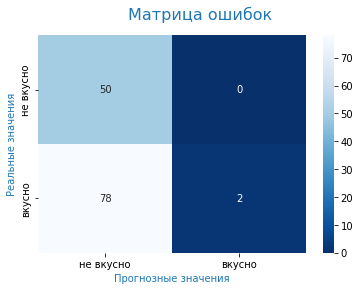

Точность модели - 0.400
Метрика Recall - 0.025
Метрика Precision - 1.000

Порог классификации: 0.88


In [160]:
thold_lg2, predictions["lg2"] = get_thold(
    y_test, y_proba_lg2, precision_score, invert=True
)

show_lg_metrics(y_test, predictions["lg2"], invert=True)
print(f"\nПорог классификации: {thold_lg2}")

После определения порога классификации для модели логистической регрессии с добавлением быков производителей в значении 0.88, верная оценка вкуса коров снизилась до 2 коров против 78 ложноотрицательных. Остальные прогнозы предсказывают не вкусное молоко.

Лучше использовать модель без добавления быков производителей, так как она дает более точные результаты.

### Прогнозирование вкуса молока

In [162]:
# Отдельная переменная для добавления дополнительных параметров
X_test = cow_buy.drop(columns=["current_milk_fat", "dad_name", "age"])
X_test.rename(columns={"current_milk_protein": "milk_protein"}, inplace=True)

# Добавление медианных значений параметров корма
for (col_name, col_data) in food_median.iteritems():
    X_test[col_name] = col_data

# 
X_test = pd.concat(
        [
            pd.DataFrame(
                encoder_lg1.transform(X_test[qual_cols_lg1]),
                columns=encoder_lg1.get_feature_names()
            ),
            pd.DataFrame(
                scaler_lg1.transform(X_test[quant_cols_lg1]),
                columns=quant_cols_lg1
            )        
        ],
        axis=1
)

result1["milk_taste"] = pd.Series(
    model_lg1.predict_proba(X_test)[:,0]
).apply(lambda x: "не вкусно" if x < thold_lg1 else "вкусно")

print("Прогноз без быков производителей:")
display(result1.query("match == True").drop(columns=["match"]))
result2["milk_taste"] = result1["milk_taste"]

print("Прогноз с учетом быков производителей:")
display(result2.query("match == True").drop(columns=["match"]))

print(f"По прогнозу модели количество коров ЭкоФермы, дающих вкусное молоко составляет:", end=" ")
print(len(result1.query("milk_taste == 'вкусно'")))

Прогноз без быков производителей:


,breed,landscape,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,result,milk_taste
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.000223,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6593.629537,не вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6555.535363,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6581.000223,не вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6593.629537,не вкусно
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,6581.000223,не вкусно
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,6593.629537,не вкусно
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6555.535363,не вкусно


Прогноз с учетом быков производителей:


,breed,landscape,dad_breed,dad_name,current_milk_fat,current_milk_protein,age,result,milk_taste
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6653.5,не вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6540.5,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6625.5,не вкусно
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6555.5,не вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6626.5,не вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6653.5,не вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6540.5,не вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6625.5,не вкусно
10,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,6352.5,не вкусно
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6626.5,не вкусно


По прогнозу модели количество коров ЭкоФермы, дающих вкусное молоко составляет: 0


### Промежуточные выводы

Проведено обучение модели логистической регрессии по следующим признакам:
1. Все категориальные признаки, кроме имени быка производителя, так как с ним прогноз модели ухудшается;
2. Количественные признаки корма коровы;
3. Из характеристик молока выбрано только содержание белков, так как жирность молока имеет высокую корреляцию с характеристиками корма и может измениться после смены подходов к кормлению скота Заказчиком.

Модель логистической регрессии показало довольно низкую точность, ошибки составляют 37.7% по валидационной выборке. Также высокий процент ложноположительных оценок - 34.7% положительных предсказаний показывают неверный результат. Это говорит, о довольно низкой корреляции используемых параметров со вкусом молока по личным критериям Заказчика.

Для снижения ошибки первого рода, чтобы модель не прогнозировала невкусное молоко как вкусное проведена настройка порога классификации, который составил 0.82. По результатам применения порога классификации количество верно спрогнозированных положительных оценок молока сократилось до 5-ти, количество ложноотрицательных оценок увеличилось до 75-х.

Проведено прогнозирование вкуса молока для коров из выборки с применением порога классификации, прогноз не определил ни одну корову, молоко которой можно с высокой долей вероятности считать вкусным по обученной модели.

## Итоговые выводы

**Выгрузка и предобработка**

В рамках данного проект проведена выгрузка данных:
1. Данные о стаде Заказчика `main_ferma` - 634 записи, пропуски отсутствуют;
2. Данные об отцах коров Заказчика `ferma_dad` - 629 записей, пропуски отсутствуют, однако записей меньше чем коров в стаде;
3. Данные о коровах «ЭкоФермы» для анализа в целях покупки `cow_buy` - 20 записей, пропуски отсустствуют. Отсутствую параметры корма.

Проведена предобработка данных, по результатам которой можно отметить следующее:
1. По данным Заказчика:
    - исключены 5 дубликатов коровы ID 637 в конце таблицы;
    - исключен явный выброс значения (строка 17) равное 45616 килограмм за год;
    - исправлены неявные дубликаты значения параметра типа пастбища.
2. По данным ЭкоФермы:
    - приведены к единым значения по параметру типа пастбища с выборкой Заказчика;
    - найдены 4 дубликата, которые вероятнее всего таковыми не являются, так как сравниваемых параметров выборки очень мало. Данный вопрос стоит уточнить в ЭкоФерме и в целом желательно иметь уникальные идентификационные данные по каждой корове, чтобы была возможность их явно отличать.

**Исследовательский и корреляционный анализ**

Проведен исследовательский анализ данных, по результатам которого можно отметить следующее:
1. Все параметры, кроме содержания белка в молоке коров Заказчика, не имеют нормального распределения - имеет место либо близкое к равномерному распределение, либо группировка в отдельные кластеры.
2. По быкам производителям выявлены следующие факты, которые стоит отметить:
    - Имеются дублирующиеся имена отцов коровы в стаде заказчика, имеющие разные породы и одинаковые имена - Барин и Соловчик породы Соверин, такой факт решено трактовать как наличие разных быков производителей с одним именем, либо нужно проверить исходные данные на наличие ошибок;
    - При сравнении с коровами ЭкоФермы выявлено дублирование имен быков производителей одной породы - Айдиал Буйный, Айдиал Геркулес, Соверин Барин и Соверин Соловчик. Так как других пересечений не наблюдается, есть вероятность, что стадо Заказчика и коровы ЭкоФермы могут иметь различных быков производителей имена и породы которых могут пересекаться, либо это одни и те же быки;
3. По характеристикам корма заметен очень сильный сдвиг по возрасту коровы Заказчика - для коров моложе 2-х лет корм предоставляется с заметно меньшими характеристиками ЭКЕ, СПО и по содержанию протеина.
4. По характеристикам молока можно отметить:
    - сдвиг характеристики содержания жиров в зависимости от возраста коровы;
    - небольшие отклонения по содержанию белка в зависимости от генетических особенностей - породы коровы и отица (Вис Бик Айдиал более жирное молоко), также по возрасту распределение более равномерное у молодых коров;
    - заметна более высокая жирность молока у коров ЭкоФермы, возможно питание коров отличается от методов кормления Заказчика.
5. По целевому параметру производительности (удой):
    - заметна гораздо меньшая производительность для коров моложе 2-х лет;
    - имеется небольшое преимущество по породе отца коровы Айдиал, которые показывают более высокий удой;
    - также более высокие показатели удоя показывают коровы с холмистым типом пастбища.
6. По целевому параметру вкуса молока можно отметить:
    - более высокое соотношение вкусного молока по холмистому типу пастбища;
    - более высокое соотношение вкусного молока у коров старше 2-х лет.

Проведен корреляционный анализ, по результатам которого можно отметить следующее:
1. Наиболее высокая корреляция с годовой производительностью коровы показывает признак возвраста коровы, практически отсутствует удой более 6000 килограмм в год у коров моложе 2-х лет.
2. Достаточно высокая корреляция и близкая к линейной зависимости у признака ЭКЕ корма. 
3. Умеренная корреляция по признаку содержания протеина в корме и зависимость можно также отнести к линейной, но с очень большим разбросом значений.
4. Остальные признаки сложно назвать линейными.
5. По признаку СПО корма заметно разделение на две группы значений, где значения СПО ниже 0.91 показывают удой в основном меньше 6000 килограмм, а значения выше в основном более 6000 килограмм в год. Также можно отметить, что коэффициент корреляции Спирмена для данного признака выше, чем для ЭКЕ корма.

В части мультиколлинеарности между признаками можно отметить следующее:
5. Полная коллинеарность между признаками отсуствует, однако имеется высокая корреляция между ЭКЕ корма и жирностью молока.
6. Также имеется умеренная корреляция между ЭКЕ и СПО корма по коэффициенту Фи, при этом коэффициент корреляции Спирмена между этими значениями говорит о высокой взаимосвязи.

По результатам исследовательского и корреляционного анализа для дальнейшего прогнозирования удоя коров на перспективу, вне зависимости от текущего возраста, принято решение отказаться от использования параметра возраста коровы и исключить молодых коров из выборки.

**Прогнозирование годовой производительности**

Для прогнозирования годовой производительности коров проведено обучение 3-х моделей линейной регрессии. Модели обучались только на взрослых коровах, так как показатели удоя у коров менее 2-х лет в основном не превышают 6000 килограмм в год, вследствие чего модель отклонит всех коров моложе 2-х лет. Таким образом Заказчик может отказаться от перспективных молодых коров.

В моделях использовались различные признаки исходной выборки:
1. Модель 1 была обучена на исходной выборке с применением категориальных признаков породы отца, типу пастбища и породы коровы, а также количественных признаков ЭКЕ корма и содержание протеина в корме.
2. Модель 2 была обучена на аналогичных признаках, кроме ЭКЕ корма, которое было приведено к более линейному виду путем возведения в квадрат, а также добавлен признак СПО корма в виде категориального, разделение которого произведено по значению 0.91.
3. Модель 3 была обучена на выборке модели 2, дополнительно в которую был включен признак имени отца коров.

Проведен анализ моделей:
1. По результатам анализа моделей было установлено, что наиболее подходящей моделью для прогнозирования удоя коров является модель 3, но только в том случае, когда имеются одни и те же быки производители в стаде Заказчика и в списке на приобретение. Также не должно быть отличающихся имен быков производителей в списке для прогнозирование удоя, так как их не было в тренировочной выборке.
2. В случае, если быки производители различаются, то лучше выбрать модель 2 для прогнозирования.
3. Определены доверительные интервалы для двух моделей.

По 2-м моделям произведено прогнозирование удоя:
1. По модели 2 определены 8 коров, удой которых с вероятностью 97.5% превышает 6000 килограмм в год.
2. По модели 3 определены 16 коров, удой которых с вероятностью 97.5% превышает 6000 килограмм в год.

**Прогнозирование вкуса молока**

Проведено обучение модели логистической регрессии по всем категориальным признакам, кроме имени быка производителя, количественным признакам корма коровы, а также по содержанию белков в молоке. Имена отцов не были включены в модель, так как их добавление ухудшает предсказание. Также жирность молока не включена, так как имеет высокую корреляцию с характеристиками корма и может измениться после смены подходов к кормлению скота Заказчиком.

Модель логистической регрессии показало довольно низкую точность, ошибки составляют 37.7% по валидационной выборке. Также высокий процент ложноположительных оценок - 34.7% положительных предсказаний показывают неверный результат. Это говорит, о довольно низкой корреляции используемых параметров со вкусом молока по личным критериям Заказчика.

Проведена настройка порога классификации для снижения ошибок первого рода, когда модель предсказывает невкусное молока как вкусно, порог составил 0.82. По результатам применения порога классификации снизилась общая точность модели, количество верно спрогнозированных положительных оценок молока существенно сократилось до 5-ти, количество ложноотрицательных оценок увеличилось до 75-х.

Проведено прогнозирование вкуса молока для коров из выборки с применением порога классификации, прогноз не выявил вкусное молоко.

**Подведение итогов**
1. Обучены две модели линейной регрессии для прогнозирования удоя коров: 
    - первая модель на случай отсутствия одних и тех же быков производителей у Заказчика и предлагаемых к покупке коров. Модель определила 8 коров, удой которых с высокой вероятностью превышает 6000 килограммов в год;
    - в случае совпадения части быков производителей модель логистической регрессии с учетом быков производителей имеет более высокие показатели. Модель определила 16 коров ЭкоФермы, удой которых с высокой вероятностью превышает 6000 килограммов в год.
2. Обучена модель логистической регрессии, по результатам прогнозирования которой не выявлено ни одной коровы ЭкоФермы, молоко которых с максимальной вероятностью являются вкусным по критериям Заказчика.

Для определения коров под требования Заказчика необходимо пересмотреть подходы к определению вкуса молока, либо на вкус молока могут влиять другие параметры, которые не входят в представленные выборки. Желательно провести исследования для определения признаков, которые могут влиять на вкус молока.

Также стоит отметить, что удой коровы и характеристики корма взаимозависимые, подход к кормлению коров должен формироваться на основании их удоя, чтобы восстановить элементную базу для производства молока коровой, но также от характеристик корма зависит удой коров. Желательно провести исследования, какое влияние оказывает смена рациона на характеристики молока и удой одних и тех же коров.